# About this Notebook

This is a Python notebook. This is the notebook you'll use to run and create the analysis code on pickle data sets. Pickle files are created and premanufactured from ROOT files from MicroBooNE LAr experiment.

You should have access to: example_neutrino.ipynb, neutrino_function.py, data folder. You are free to modify neutrino_function.py or create your own plotting functions.

**IMPORTANT:** It is strongly recommended that only **one** student of a lab pair should edit this notebook and the files contained within the server directories. This is because both students cannot see the same live edit of the notebook or files at the same time, and it is easy to accidently overwrite each other.

Code that is commented out with two hashtags should be uncommented when in use.

# All imports

The basic libraries, you may import more if there are present on the server's environment. If you dont have these packages installed on your local machine, you can use **pip install X** or **pip3 install X** to start using them.

In [2]:
import numpy as np
import uproot3
import pickle

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import Neutrino_functions

from math import *
import scipy as sci
import xgboost as xg

# MACHINE LEARNING IMPORTS
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Opening the MC and data frames

In [3]:
# Initialises data from MC simulation (Beam interaction) and uBooNE (Cosmic interaction when beam is turned off) to a variable to be read out by the pandas dataframe 
# MC_EXT contains MC data simulating interactions from when the muon beam is on, and real data of interactions due to external particles
MC_file = './true_data/MC_EXT_flattened.pkl' 

# Initialises completely real data from uBooNE (Both the beam and external particle interactions in LArTPC) to a variable to be read out by the pandas dataframe
data_file = './true_data/data_flattened.pkl'


# Open files as pandas dataframe
MC_EXT = pd.read_pickle(MC_file)
data = pd.read_pickle(data_file)


# removing 'Subevent' from data
# Subevents are multiple events with the same or incredibly similar energy and track. They happen cause the detector has to take a snapshot in time.
MC_EXT = MC_EXT.drop('Subevent', axis = 1)
data = data.drop('Subevent', axis = 1)

# You can display the dataframe by uncommenting these lines and running the cell

In [4]:
# limits the maximum columns the dataframe will display. This is just  atrick to make the display show all the columns 
# instead of having some columns ignored as "..." and skipping to the end column 
pd.set_option('display.max_columns', 100)
# displays first 10 results of the dataframe from top to bottom
data.head(10)

_closestNuCosmicDist   trk_len_v trk_distance_v  category  \
0             48.170196  230.178085       0.289455         0   
1             48.170196   19.862617      20.065849         0   
2            177.083498  174.338699       0.057629         0   
3              0.067737  264.553223     196.515564         0   
4             36.361293  493.096283       0.465464         0   
5            127.613429  181.327194       0.272344         0   
6            127.613429   10.863928       0.334015         0   
7            101.562292    8.869122     265.905823         0   
8            181.173178  168.925873       0.349405         0   
9            162.177990   47.523987       0.030297         0   

   topological_score trk_sce_end_z_v trk_sce_end_y_v trk_sce_end_x_v  \
0           0.932121      662.713745      -10.419758        0.564317   
1           0.932121      467.605438      -41.015533       40.286861   
2           0.588847      978.765259        9.115969      153.437668   
3           0.002079      998.799072       18.552534      225.164139   
4           0.983048      865.795166      -56.678547       80.313004   
5           0.021950      264.979065       92.158607      255.202988   
6           0.021950      226.903671      -91.896515      218.480057   
7           0.036152       110.97657       81.228905         30.3652   
8           0.517549      517.184326       67.922836      156.103348   
9           0.336266      892.599304      -59.251465        37.77512   

  trk_score_v trk_llr_pid_score_v trk_sce_start_z_v trk_sce_start_y_v  \
0         1.0            0.981798        443.558472        -71.411057   
1    0.460725            0.722245          455.0065        -55.723381   
2    0.999995            0.970214        852.828674        -36.029785   
3         1.0            0.977688        797.282776         63.213791   
4         1.0            0.990403        408.639801         96.316406   
5    0.999972            0.958479        230.559982        -81.870941   
6    0.791141           -0.287616        229.998383        -81.993217   
7    0.011572            0.133134        114.274597         86.827835   
8    0.999998            0.959285          406.7724         114.33268   
9     0.93185            0.761358         870.96521        -33.337875   

  trk_sce_start_x_v  reco_nu_vtx_sce_x  reco_nu_vtx_sce_y  reco_nu_vtx_sce_z  \
0          32.10228          32.137272         -71.675980         443.439148   
1         36.461731          32.137272         -71.675980         443.439148   
2         42.856102          42.869896         -35.978130         852.848938   
3         63.001648         160.463943        -113.297066         772.441833   
4        141.032898         141.039246          96.385994         408.178772   
5         221.46637         221.349503         -81.868439         230.311829   
6          221.4086         221.349503         -81.868439         230.311829   
7         36.310745         170.431870          59.736755         340.503021   
8         40.269585          40.016575         114.483635         406.585693   
9          71.00219          71.004707         -33.363049         870.948181   

   trk_energy_tot trk_range_muon_mom_v trk_mcs_muon_mom_v  
0    10000.021584             0.624387           0.672995  
1    10000.021584             0.145945              0.159  
2        0.629191             0.502137           0.551996  
3    10000.778217             0.700354           0.627999  
4        1.296849             1.220361           1.124005  
5     9999.794868             0.517367           0.527997  
6     9999.794868             0.114687              0.102  
7     9999.221455             0.106222              0.101  
8     9999.828041             0.490352           0.428998  
9        0.286233             0.220104              0.228

In [5]:
MC_EXT.head(10) #displays MC_EXT

_closestNuCosmicDist   trk_len_v trk_distance_v  category  \
0            124.478148  225.284348       1.286398        21   
1            124.478148    7.850903     131.947891        21   
2            141.086923  251.017548       0.025229         5   
3             10.511966   58.736591      10.511966         4   
4             10.511966    9.962337       3.888895         4   
5            147.929810  289.265442       0.152002         5   
6             96.691013   56.727428      27.846855        21   
7             96.691013   67.758522       0.264366        21   
8             96.691013   25.262609       7.398347        21   
9            106.679589   73.540779       0.226748         5   

   topological_score trk_sce_end_z_v trk_sce_end_y_v trk_sce_end_x_v  \
0           0.994485      510.146088      -19.997118      191.864334   
1           0.994485      389.239197       46.669083      183.160797   
2           0.007706      766.055969      -50.159794       172.77446   
3           0.066952      213.629105      117.414757       88.746597   
4           0.066952      235.423004       46.921162       80.265305   
5           0.515178     1031.704712         52.0289       83.527153   
6           0.998477     1036.508911      -38.234692       19.931959   
7           0.998477     1036.692261      -78.989571       24.593576   
8           0.998477      987.487305      -65.503288          5.5114   
9           0.040650      769.010193      110.767021       45.539276   

  trk_score_v trk_llr_pid_score_v trk_sce_start_z_v trk_sce_start_y_v  \
0         1.0            0.977081        343.433655         35.865448   
1    0.041434            0.486446        382.998871         47.109879   
2         1.0            0.972468        658.480286        117.427391   
3    0.929871            0.870984        224.018387         60.914005   
4    0.372258            0.404711        226.829147         51.903919   
5         1.0              0.9848        761.951172          -6.10771   
6    0.065278            0.902933        992.340698        -65.519211   
7    0.966078            0.940751        969.034668        -81.002808   
8    0.082593             0.79802        972.884705        -76.234444   
9    0.950805            0.911611         759.31604         53.225922   

  trk_sce_start_x_v  reco_nu_vtx_sce_x  reco_nu_vtx_sce_y  reco_nu_vtx_sce_z  \
0         54.776821          53.900658          36.203041         342.578735   
1        178.486572          53.900658          36.203041         342.578735   
2         20.797407          20.804905         117.408989         658.495789   
3         78.242538          78.443840          50.530334         223.597870   
4         80.192444          78.443840          50.530334         223.597870   
5          1.388844           1.357146          -6.141214         761.806335   
6          22.75659          25.337120         -80.776207         969.163696   
7          25.39159          25.337120         -80.776207         969.163696   
8         20.853903          25.337120         -80.776207         969.163696   
9          1.124355           1.250130          53.412140         759.350220   

   trk_energy_tot trk_range_muon_mom_v trk_mcs_muon_mom_v    weight    true_E  \
0        1.164239             0.613618           0.624997  0.000002  1.371928   
1        1.164239             0.101568              0.093  0.000002  1.371928   
2     9999.989363             0.670372           0.740995  0.158957  1.798278   
3     9999.441230             0.246837              0.234  0.192390  0.777679   
4     9999.441230              0.11096              0.131  0.192390  0.777679   
5     9999.934871             0.755327           0.761996  0.986006  1.214413   
6    10000.275867             0.242116              0.188  0.158957  1.857195   
7    10000.275867             0.267746           0.346999  0.158957  1.857195   
8    10000.275867             0.161958              0.099  0.158957  1.857195   
9     9999

# Machine learning for Particle Classification

First, look at a sub-sample of our Monte Carlo data.

In [6]:
# Reduce the amount of data for visualisation purposes
# Counts number of rows in dataframe and randomly keeps only one-tenth of the data
MC_EXT_VIS = MC_EXT.sample(int(len(MC_EXT)/10))

# Resetting the index (redefines the row labels back to 0, 1, 2, 3, etc.) so that they are in order after we removed one-tenth of the data
MC_EXT_VIS.reset_index(drop=True, inplace=True)

# Removing high energy (unphysical) monte carlo results
# trk_energy_tot is the reconstructed energy of the neutrino in the interaction. 2 was chosen arbitrarily because it cuts out most of the problematic energies 
# while keeping most of the relevant ones
MC_EXL_VIS = MC_EXT_VIS.drop(MC_EXT_VIS[MC_EXT_VIS.trk_energy_tot > 2].index, inplace = True)

# Resetting the index again
MC_EXT_VIS.reset_index(drop=True, inplace=True)

# Displaying dataframe
print("Length of new data sample: {}".format(len(MC_EXT_VIS)))
MC_EXT_VIS.head(10)

Length of new data sample: 14271


_closestNuCosmicDist   trk_len_v trk_distance_v  category  \
0            140.389152   14.481792       0.760792        21   
1             64.960824  127.381699       0.235272         7   
2              0.698064   20.159136      76.678329         7   
3            128.680191   101.53083       0.510441         7   
4            155.462928  213.606094       0.398249        21   
5            155.923508  295.300751        0.15415        21   
6             62.499017  561.746765       0.110856        21   
7            133.764184  400.255341       1.246384        21   
8             99.553838   34.097298       0.476796        21   
9            136.723120   66.885033        0.30546        21   

   topological_score trk_sce_end_z_v trk_sce_end_y_v trk_sce_end_x_v  \
0           0.582752      469.412323      -54.116135      216.929993   
1           0.028581      389.431763      -29.339981       12.767227   
2           0.062339       105.75827       14.476683       70.684349   
3           0.016601      742.123474        7.156748      133.525864   
4           0.591159      524.855103      -47.049126      179.214172   
5           0.954158      320.686981      -37.079391       31.172522   
6           0.851227      649.788025       95.706436      175.446762   
7           0.816889      700.571106       82.897148      101.126038   
8           0.053924      115.960732        -70.3591       30.661829   
9           0.969227      335.820251      -57.476898      123.699875   

  trk_score_v trk_llr_pid_score_v trk_sce_start_z_v trk_sce_start_y_v  \
0    0.494294            0.243527        457.841064         -45.53064   
1    0.999881            0.958074        348.380096         85.398788   
2    0.176051            0.594284        110.871529         -3.448912   
3    0.999594            0.951427        756.282349        106.837936   
4         1.0            0.977456        362.213226         73.031677   
5         1.0            0.979497          64.56044         43.327682   
6         1.0             0.98994         95.589401         98.379921   
7         1.0            0.981439        341.042053         -86.42524   
8    0.934436            0.643546        117.842712        -83.528328   
9    0.960335            0.886321        283.614746        -54.205818   

  trk_sce_start_x_v  reco_nu_vtx_sce_x  reco_nu_vtx_sce_y  reco_nu_vtx_sce_z  \
0        215.817505         215.360245         -44.845768         457.964996   
1         35.415604          35.404411          85.519218         348.582642   
2         70.311783          20.564163         -25.229048          57.739273   
3        133.899094         133.903458         106.815804         756.792664   
4        117.283035         117.151955          73.215759         361.892975   
5        152.620224         152.561646          43.469418          64.550568   
6        153.727814         153.736969          98.389046          95.479103   
7         63.265106          62.791401         -85.383018         340.456421   
8         61.851818          61.436916         -83.276360         117.833199   
9         82.355568          82.355286         -54.466480         283.592285   

   trk_energy_tot trk_range_muon_mom_v trk_mcs_muon_mom_v    weight    true_E  \
0        0.988680             0.128329              0.124  0.158957  1.006989   
1        0.680192             0.400002           0.358999  0.257732  1.000000   
2        0.965461             0.146855              0.086  0.257732  1.000000   
3        0.359122             0.343429              0.306  0.257732  1.000000   
4        0.820850             0.587965           0.550998  0.181785  0.844880   
5        0.842612               0.7688           0.777998  0.171062  0.913353   
6        1.469964             1.381448           1.295009  0.207111  1.391416   
7        1.146208             1.005984           0.968998  0.158957  1.745513   
8        0.274712             0.186262               0.16  0.409824  0.262601   
9        0

# Exercise 5 Data Visualisation
Lets visualise some of the variables using *seaborn*

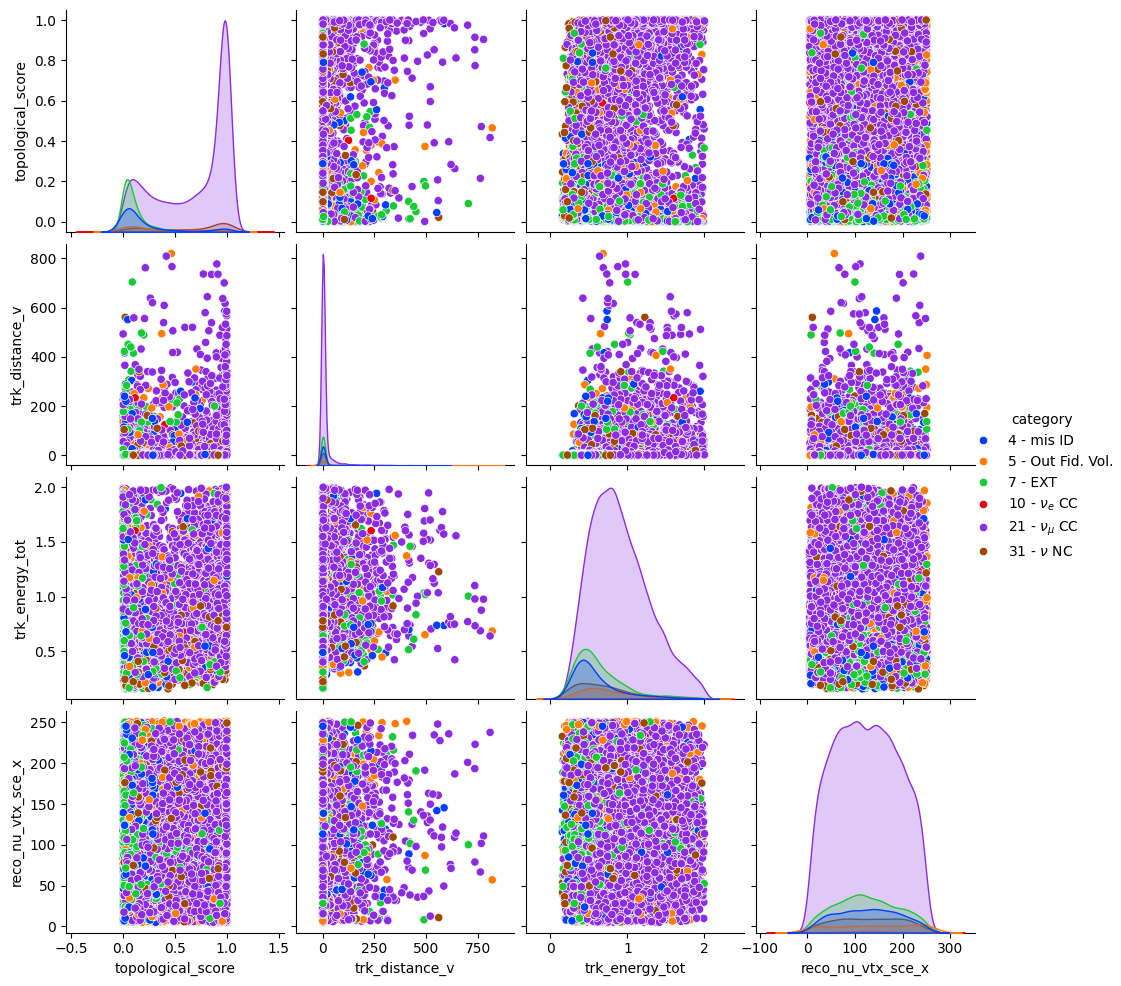

In [7]:
# Visualising a couple of variables.
variable_list = ['category', 'topological_score', 'trk_distance_v', 'trk_energy_tot', 'reco_nu_vtx_sce_x']

# List of categories in text rather than number form 
ptype = [r"mis ID", r"Out Fid. Vol.", r"EXT", r"$\nu_e$ CC", r"$\nu_{\mu}$ CC", r"$\nu$ NC"]

# Plot data such that each numeric variable in data will by shared across the y-axes across a single row and the x-axes across a single column. 
# The diagonal plots are treated differently: a univariate distribution plot is drawn to show the marginal distribution of the data in each column.
fig = sns.pairplot(MC_EXT_VIS[variable_list], hue = 'category', palette = 'bright')

# Change location of legend
fig._legend.set_bbox_to_anchor((1.05, 0.5))

# Add Category number and type to legend
for t, l in zip(fig._legend.texts, ptype):
   t.set_text(str(t.get_text()) + " - " + str(l))

In [8]:
# Create a deep copy of MC_EXT_VIS without signal events (For our purposes, signal event is muon neutrino event). This leaves us with only background events
MC_EXT_VIS_nosig = MC_EXT_VIS.drop(MC_EXT_VIS[MC_EXT_VIS.category == 21].index, inplace = False)

MC_EXT_VIS_nosig.reset_index(drop=True, inplace=True)

print("Length of new data sample: {}".format(len(MC_EXT_VIS_nosig)))
MC_EXT_VIS_nosig.head(10)

Length of new data sample: 3926


_closestNuCosmicDist   trk_len_v trk_distance_v  category  \
0             64.960824  127.381699       0.235272         7   
1              0.698064   20.159136      76.678329         7   
2            128.680191   101.53083       0.510441         7   
3            161.289460  102.492531        0.26148         7   
4             26.838542  142.340408       0.408685         7   
5             62.746745   38.021088        0.46601         5   
6              0.175824   36.653427       0.175824         4   
7             62.046655  190.540054       0.249419         7   
8             23.464753  111.252869       0.810704         7   
9            141.369442   115.09465       1.236686        31   

   topological_score trk_sce_end_z_v trk_sce_end_y_v trk_sce_end_x_v  \
0           0.028581      389.431763      -29.339981       12.767227   
1           0.062339       105.75827       14.476683       70.684349   
2           0.016601      742.123474        7.156748      133.525864   
3           0.075007      127.120102       45.330963      117.989204   
4           0.135360      628.632935      -35.033249        111.6651   
5           0.384795       31.320169      -115.50547      197.236923   
6           0.037060      114.650787      -84.477859       58.622406   
7           0.084123      721.470642      -90.405327      151.544693   
8           0.039245      436.947479      106.811798       58.343689   
9           0.886766      527.564697       15.797414       57.158684   

  trk_score_v trk_llr_pid_score_v trk_sce_start_z_v trk_sce_start_y_v  \
0    0.999881            0.958074        348.380096         85.398788   
1    0.176051            0.594284        110.871529         -3.448912   
2    0.999594            0.951427        756.282349        106.837936   
3    0.999614              0.9008        107.021919        -50.010902   
4    0.999981            0.927584        739.858521         43.887051   
5    0.920263            0.894151         67.370857       -104.741638   
6    0.888875            0.792255        110.205925       -102.669846   
7         1.0            0.862022        720.372375         47.679321   
8    0.999704            0.947154        413.038696          6.665143   
9    0.999825            0.964637        443.477448         88.056259   

  trk_sce_start_x_v  reco_nu_vtx_sce_x  reco_nu_vtx_sce_y  reco_nu_vtx_sce_z  \
0         35.415604          35.404411          85.519218         348.582642   
1         70.311783          20.564163         -25.229048          57.739273   
2        133.899094         133.903458         106.815804         756.792664   
3        147.417694         147.598541         -50.197769         106.941742   
4         88.603104          88.598816          44.222050         739.597534   
5        200.840744         200.924927        -104.559410          67.783791   
6         27.169512          27.008757        -102.700272         110.146355   
7         41.299995          41.335011          47.880711         720.230896   
8         99.941971          99.963280           6.632767         413.848358   
9         27.236673          26.892471          88.294426         442.316162   

   trk_energy_tot trk_range_muon_mom_v trk_mcs_muon_mom_v    weight    true_E  \
0        0.680192             0.400002           0.358999  0.257732  1.000000   
1        0.965461             0.146855              0.086  0.257732  1.000000   
2        0.359122             0.343429              0.306  0.257732  1.000000   
3        0.361148             0.345547           0.315999  0.257732  1.000000   
4        0.925309             0.432551           0.390998  0.257732  1.000000   
5        0.559251             0.196456              0.151  0.158957  1.686132   
6        0.324298             0.192937              0.275  0.259532  0.382509   
7        0.600925             0.537473           0.446998  0.257732  1.000000   
8        0.379594             0.364783           0.438998  0.257732  1.000000   
9        0

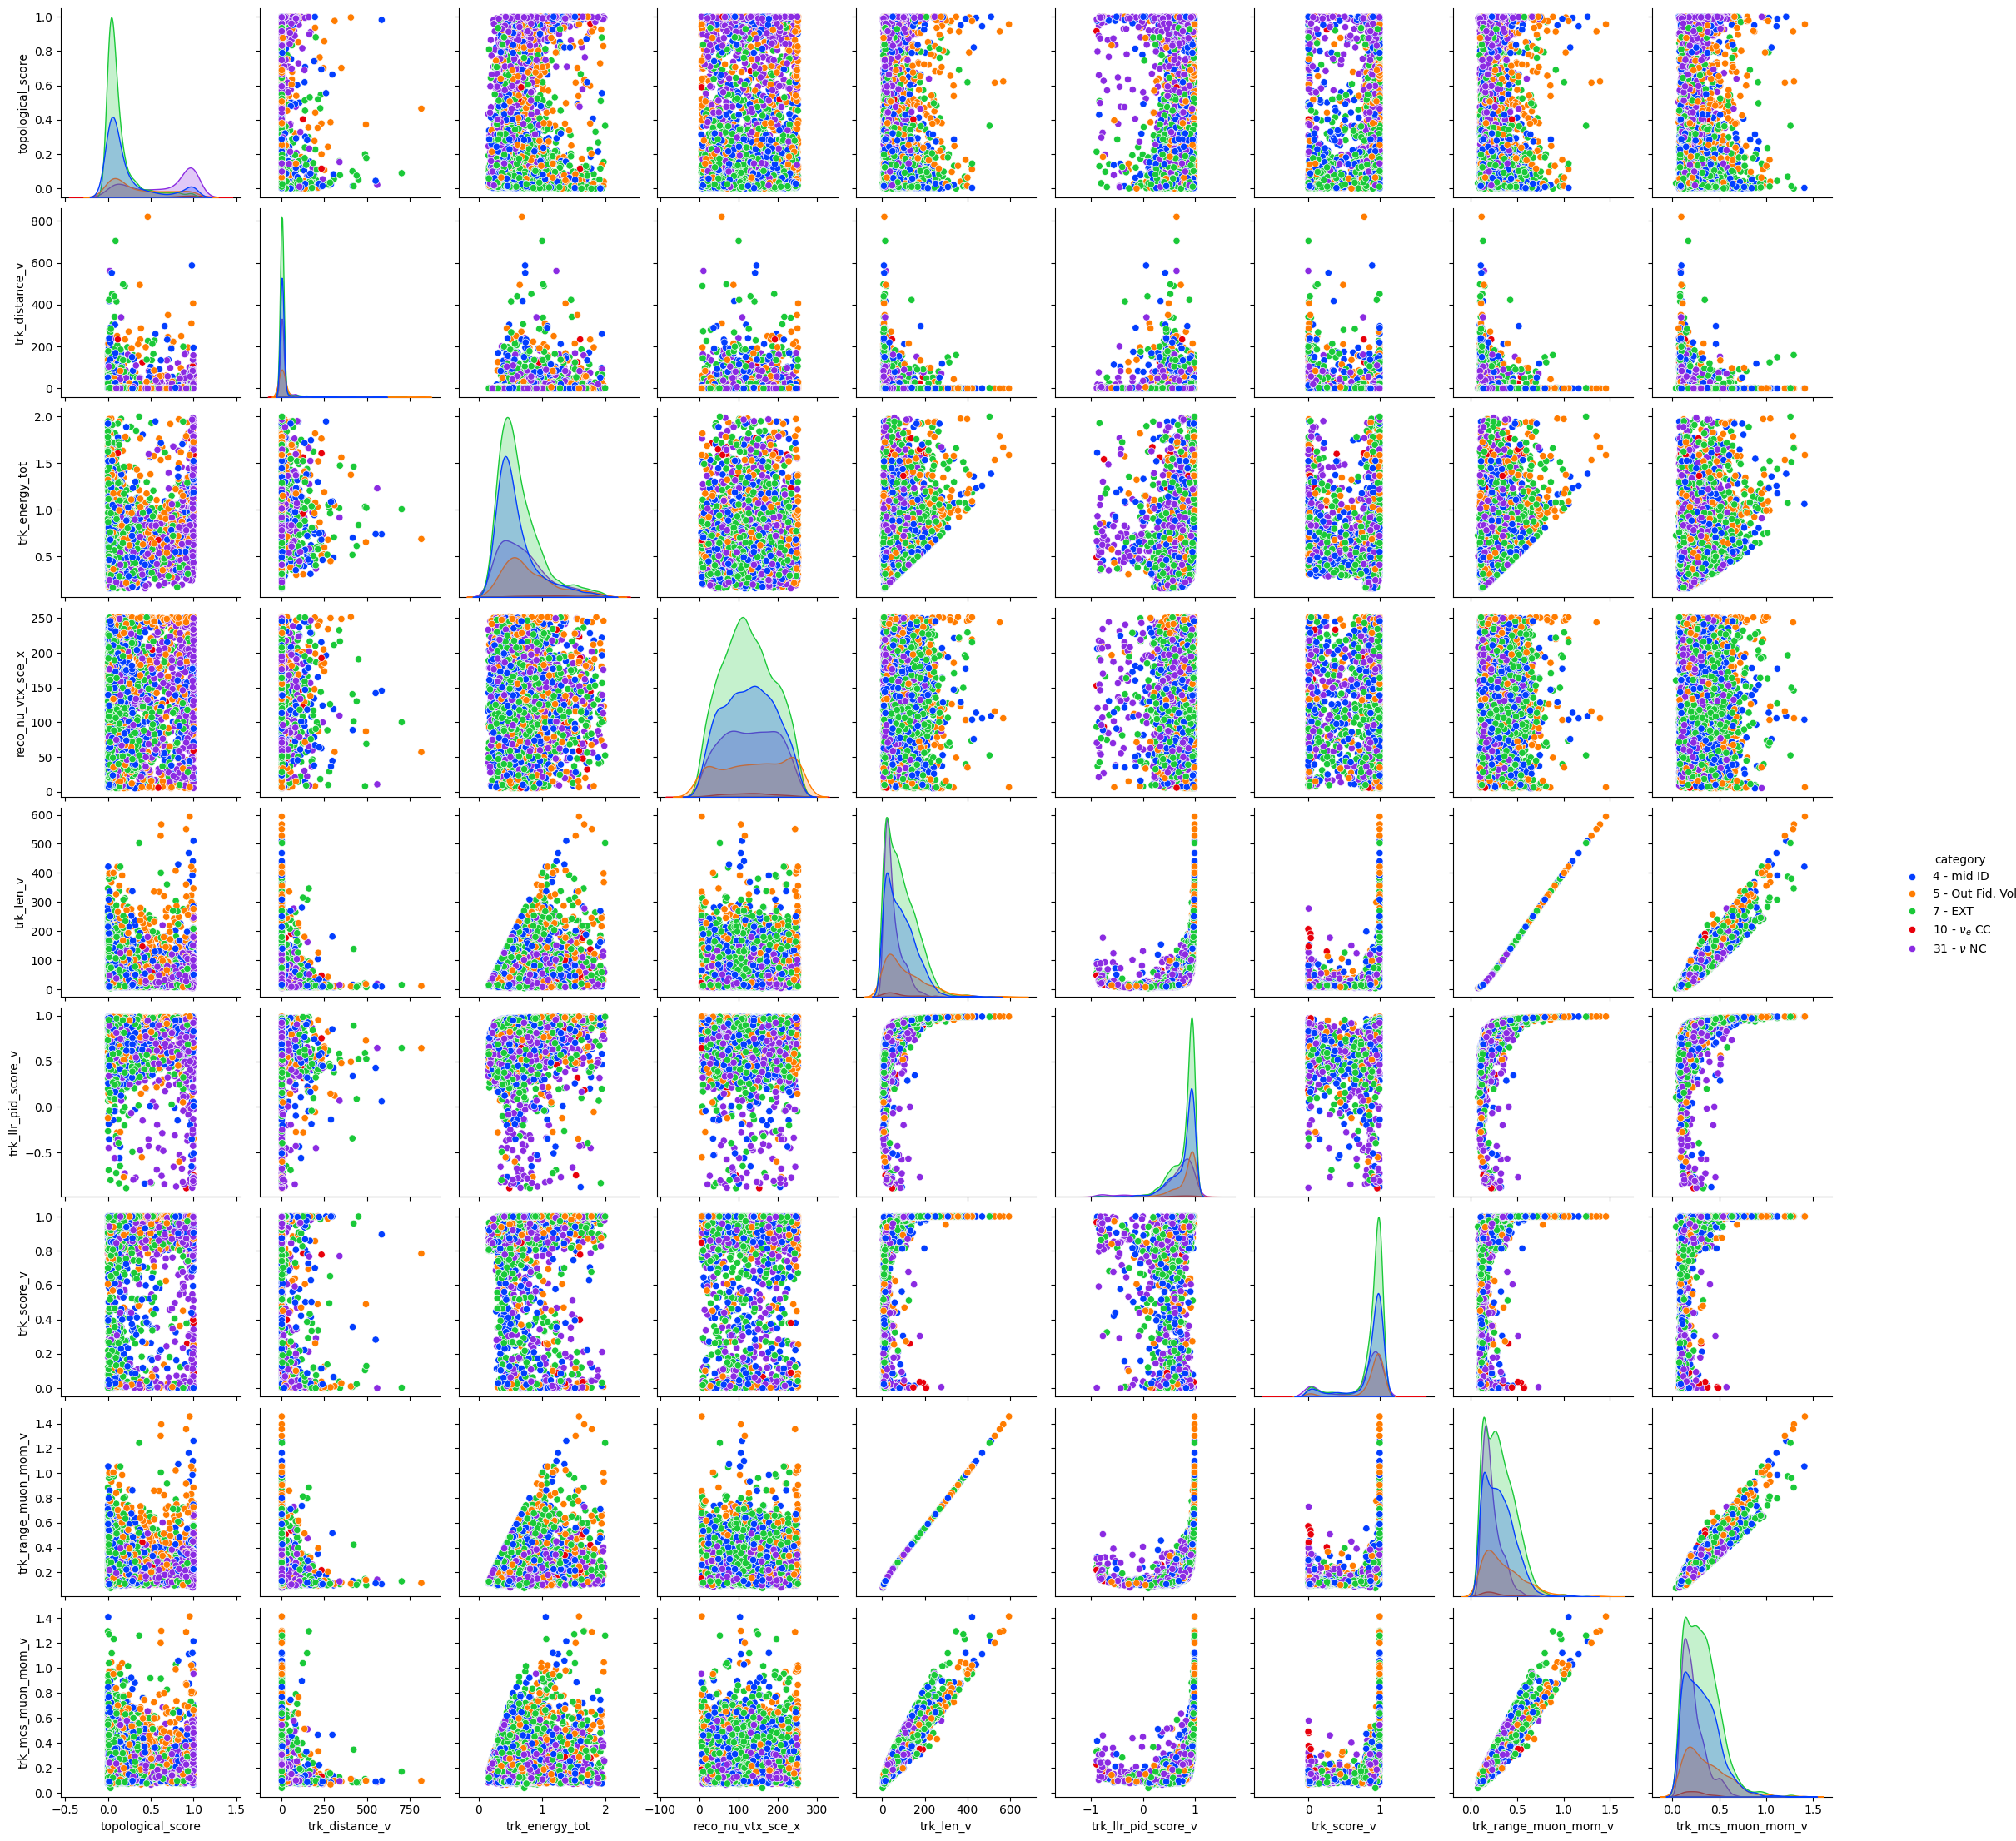

In [9]:
# Plotting the background events using sns.pairplot
variable_list_1 = ['category', 'topological_score', 'trk_distance_v', 'trk_energy_tot', 'reco_nu_vtx_sce_x', 'trk_len_v', 'trk_llr_pid_score_v', 'trk_score_v', 'trk_range_muon_mom_v', 'trk_mcs_muon_mom_v']

fig_nosig = sns.pairplot(MC_EXT_VIS_nosig[variable_list_1], hue = 'category', palette = 'bright')

# List of categories (excluding signal) in text
ptype_no_mu = [r"mid ID", r"Out Fid. Vol.", r"EXT", r"$\nu_e$ CC", r"$\nu$ NC"]

fig_nosig._legend.set_bbox_to_anchor((1.05, 0.5))

for t, l in zip(fig_nosig._legend.texts, ptype_no_mu):
   t.set_text(str(t.get_text()) + " - " + str(l))

In [10]:
# Make sure to delete dataframe copies if you no longer need them! This helps increase runtime of the entire code
del MC_EXT_VIS_nosig

# Exercise 6: Random Forest applications

Here we shall modify the shape of our data for its usage in a decision tree, then apply the *RandomForest* method from the scikit-learn package.

In [11]:
# Adjust data shape
features = ['_closestNuCosmicDist', 'trk_len_v', 'trk_distance_v', 'topological_score', 'trk_sce_end_z_v', 'trk_sce_end_y_v', 'trk_sce_end_x_v', 'trk_score_v', 'trk_llr_pid_score_v', 'trk_sce_start_z_v', 'trk_sce_start_y_v', 'trk_sce_start_x_v', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 'trk_energy_tot']
output = ['category']

# Setup new database, NEED MORE VALUES
MC_EXT_ML = MC_EXT.copy(deep = True) # deep copies MC_EXT. This means we will not affect the original MC_EXT we modified

# Repeat same process as earlier and retain one-tenth of the sample 
MC_EXT_ML = MC_EXT.sample(int(len(MC_EXT)/10)) 


# Remove muon neutrino and electron neutrino events.This is because they are too dominant in the dataset. 
# We will only focus on classifying the background events for now
MC_EXT_ML = MC_EXT_ML.drop(MC_EXT_ML[MC_EXT_ML.category == 10].index, inplace = False)
MC_EXT_ML.reset_index(drop=True, inplace=True)
MC_EXT_ML = MC_EXT_ML.drop(MC_EXT_ML[MC_EXT_ML.category == 21].index, inplace = False)
MC_EXT_ML.reset_index(drop=True, inplace=True)

#display(MC_EXT_ML)

# Print length of dataframe,, with length N
print("Length of MC dataframe: ", len(MC_EXT_ML))

Length of MC dataframe:  31790


In [12]:
# Setting up input parameters for random forest.
X = MC_EXT_ML[features]
y = np.array(MC_EXT_ML['category'])

# Display shape of X and y, should be (N, 16) (N) where is number of samples.
print("(X) (y) shape:")
print(np.shape(X), np.shape(y))

# Then split the data up into a "training set" and "test set" using train_test_split.
# Keep the random_state=1 in your arguments
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1) # 80/20 training/test split

# Print the shape, should now be 
print("\n(x_train) (y_train) shape: ")
print(np.shape(x_train), np.shape(y_train))


(X) (y) shape:
(31790, 16) (31790,)

(x_train) (y_train) shape: 
(25432, 16) (25432,)


Produce your randomforest model and fit it (dont worry, there is no explicit output, but make sure you haven't made your model too big! It shouldn't take any more than a couple of minutes at most to fit).

In [13]:
# Produce randomforest classifier model and fit to training data
# Keep the random_state=1 in your arguments
##rf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=8, random_state=1)

# Fitting takes the input and "truth" data for classification purposes
##rf.fit(x_train, y_train)

Test the accuracies of your results:

In [14]:
# Produce predictions for the classification of your training dataset using your model:
##y_pred = rf.predict(x_train)

# plot the accuracies of said predictions
##print("Accuracy on training dataset:",metrics.accuracy_score(y_train, y_pred))
##rf_acc_train = metrics.accuracy_score(y_train, y_pred)
##y_pred = rf.predict(x_test)
##print("Accuracy on testing dataset:",metrics.accuracy_score(y_test, y_pred))
##rf_acc_test = metrics.accuracy_score(y_test, y_pred)

If your training accuracy is similar to your testing accuracy, this demonstrates that you haven't overfit your data!

#### Confusion matrix and variable importance

Produce a confusion matrix for your model to quantify its ability to predict your different interaction types.

In [15]:
# For labelling your confusion matrix
##ptype_no_mu_e = [r"Cosmic", r"Out Fid. Vol.", r"EXT", r"$\nu$ NC"]

# plot your confusion matrix
##cm = confusion_matrix( y_test, y_pred, normalize = 'true')
##disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ptype_no_mu_e)
##disp.plot()
##plt.show()

Plot the importance of your different parameters.

In [16]:
# Plot importance
##importance = rf.feature_importances_
##ytix = features

##plt.barh(range(16), importance)
##plt.yticks(range(16), features)
##plt.xlabel("Importance")
##plt.ylabel("Features")
##plt.show()


# Neutrino_functions.py

You are given access to a couple of template functions provided within Neutrino_functions.py, which may be helpful in completing this lab. One such function is 'Neutrino_functions.histogram_plot', which can be seen below, but you can create your own functions if you wish.

In [17]:
#This command shows what input you should give the plotting function. The inputs with =None can be left out when calling the function
help(Neutrino_functions.histogram_plot)

Help on function histogram_plot in module Neutrino_functions:

histogram_plot(MC_frame, variable, bins, name, scaling, xlims=[], plot_fig=True, plot_data=False, logscale=None, dataFrame=None, Stat_func=None)
    MC_frame: pandas dataframe - MC dataframe
    variable: string - name of the variable
    bins: int - number of bins
    name: string - name of the plot. The plot is saved
    scaling: array/list - weights you want to apply on MC data
    plot_data: boolean - if True then plots data as well
    logscale: boolean - if True then y axis is log scale
    dataFrame: pandas dataframe - data dataframe



# Exercise 7: Selection Cuts and Histogram plotting

Modify selection cuts. Remember to cut the same variables in both data sets.

In [18]:
def Selections(frame):
    
    # Basic variables present in dataframe 
    trk_sce_start_x_v = frame['trk_sce_start_x_v']        # cm
    trk_sce_start_y_v = frame['trk_sce_start_y_v']        # cm
    trk_sce_start_z_v = frame['trk_sce_start_z_v']        # cm
    trk_sce_end_x_v = frame['trk_sce_end_x_v']            # cm
    trk_sce_end_y_v = frame['trk_sce_end_y_v']            # cm
    trk_sce_end_z_v = frame['trk_sce_end_z_v']            # cm
    reco_nu_vtx_sce_x = frame['reco_nu_vtx_sce_x']               # cm
    reco_nu_vtx_sce_y = frame['reco_nu_vtx_sce_y']               # cm
    reco_nu_vtx_sce_z = frame['reco_nu_vtx_sce_z']               # cm
    topological_score = frame['topological_score']          # N/A
    trk_score_v = frame['trk_score_v']                # N/A
    trk_distance_v = frame['trk_distance_v']               # cm
    trk_len_v = frame['trk_len_v']                    # cm
    trk_energy_tot = frame['trk_energy_tot']          # GeV 
    trk_llr_pid_score_v = frame['trk_llr_pid_score_v']
    
    
    
    # select the conditions you want to apply, here is an initial condition to get you started.
    trk_sce_start_x_v_selection = ((trk_sce_start_x_v > 5) & (trk_sce_start_x_v < 250))
    trk_sce_start_y_v_selection = ((trk_sce_start_y_v > -110) & (trk_sce_start_y_v < 110))
    trk_sce_start_z_v_selection = ((trk_sce_start_z_v > 30) & (trk_sce_start_z_v < 990))
    trk_sce_end_x_v_selection = ((trk_sce_end_x_v > 0) & (trk_sce_end_x_v < 250))
    trk_sce_end_y_v_selection = ((trk_sce_end_y_v > -120) & (trk_sce_end_y_v < 110))
    trk_sce_end_z_v_selection = ((trk_sce_end_z_v > 10) & (trk_sce_end_z_v < 1030))
    trk_distance_v_selection = (trk_distance_v < 10)
    reco_nu_vtx_sce_x_selection = ((reco_nu_vtx_sce_x > 5) & (reco_nu_vtx_sce_x < 250))
    reco_nu_vtx_sce_y_selection = ((reco_nu_vtx_sce_y > -110) & (reco_nu_vtx_sce_y < 105))
    reco_nu_vtx_sce_z_selection = ((reco_nu_vtx_sce_z > 30) & (reco_nu_vtx_sce_z < 980))
    trk_len_v_selection =  ((trk_len_v > 0) & (trk_len_v < 1037))
    trk_score_v_selection = (trk_score_v > 0)
    topological_score_selection = (topological_score > 0)
    trk_llr_pid_score_v_selection = (trk_llr_pid_score_v > -1)
    trk_energy_tot_selection = (trk_energy_tot < 2)
    
    
    # Apply selection on dataframe
    frame = frame[trk_energy_tot_selection]

    total_events = len(frame.index)
    muon_total_events = len(frame[frame['category']==21].index)

    frame = frame[topological_score_selection]
    topological_score_events = len(frame.index)
    muon_topological_score_events = len(frame[frame['category']==21].index)
    
    #frame = frame[trk_sce_start_x_v_selection]
    #trk_sce_start_x_v_events = len(frame.index)
    #muon_trk_sce_start_x_v_events = len(frame[frame['category']==21].index)
    
    #frame = frame[trk_sce_start_y_v_selection]
    #trk_sce_start_y_v_events = len(frame.index)
    #muon_trk_sce_start_y_v_events = len(frame[frame['category']==21].index)
    
    #frame = frame[trk_sce_start_z_v_selection]
    #trk_sce_start_z_v_events = len(frame.index)
    #muon_trk_sce_start_z_v_events = len(frame[frame['category']==21].index)
    
    #frame = frame[trk_sce_end_x_v_selection]
    #trk_sce_end_x_v_events = len(frame.index)
    #muon_trk_sce_end_x_v_events = len(frame[frame['category']==21].index)
    
    #frame = frame[trk_sce_end_y_v_selection]
    #trk_sce_end_y_v_events = len(frame.index)
    #muon_trk_sce_end_y_v_events = len(frame[frame['category']==21].index)
    
    #frame = frame[trk_sce_end_z_v_selection]
    #trk_sce_end_z_v_events = len(frame.index)
    #muon_trk_sce_end_z_v_events = len(frame[frame['category']==21].index)
    
    #frame = frame[trk_distance_v_selection]
    #trk_distance_v_events = len(frame.index)
    #muon_trk_distance_v_events = len(frame[frame['category']==21].index)
    
    #frame = frame[reco_nu_vtx_sce_x_selection]
    #reco_nu_vtx_sce_x_events = len(frame.index)
    #muon_reco_nu_vtx_sce_x_events = len(frame[frame['category']==21].index)
    
    #frame = frame[reco_nu_vtx_sce_y_selection]
    #reco_nu_vtx_sce_y_events = len(frame.index)
    #muon_reco_nu_vtx_sce_y_events = len(frame[frame['category']==21].index)
    
    #frame = frame[reco_nu_vtx_sce_z_selection]
    #reco_nu_vtx_sce_z_events = len(frame.index)
    #muon_reco_nu_vtx_sce_z_events = len(frame[frame['category']==21].index)
    
    #frame = frame[trk_len_v_selection]
    #trk_len_v_events = len(frame.index)
    #muon_trk_len_v_events = len(frame[frame['category']==21].index)
    
    #frame = frame[trk_score_v_selection]
    #trk_score_v_events = len(frame.index)
    #muon_trk_score_v_events = len(frame[frame['category']==21].index)
    
    #frame = frame[trk_llr_pid_score_v_selection]
    #trk_llr_pid_score_v_events = len(frame.index)
    #muon_trk_llr_pid_score_v_events = len(frame[frame['category']==21].index)

    events = [total_events, topological_score_events]
#trk_sce_start_x_v_events, trk_sce_start_y_v_events, trk_sce_start_z_v_events, trk_sce_end_x_v_events, 
 #             trk_sce_end_y_v_events, trk_sce_end_z_v_events, trk_distance_v_events, reco_nu_vtx_sce_x_events, reco_nu_vtx_sce_y_events,
  #            reco_nu_vtx_sce_z_events, trk_len_v_events, trk_score_v_events, trk_llr_pid_score_v_events]
    muon_events = [muon_total_events, muon_topological_score_events]
#muon_trk_sce_start_x_v_events, muon_trk_sce_start_y_v_events, muon_trk_sce_start_z_v_events, muon_trk_sce_end_x_v_events, 
 #             muon_trk_sce_end_y_v_events, muon_trk_sce_end_z_v_events, muon_trk_distance_v_events, muon_reco_nu_vtx_sce_x_events, muon_reco_nu_vtx_sce_y_events,
  #            muon_reco_nu_vtx_sce_z_events, muon_trk_len_v_events, muon_trk_score_v_events, muon_trk_llr_pid_score_v_events]
    
    return frame, events, muon_events

## Calls the selection function on the dataframes

In [19]:
selections = Selections(MC_EXT)
MC_EXT_cuts = selections[0]
data_frame = Selections(data)[0]

events = np.array(selections[1])
print(events)
muon_events = np.array(selections[2])
efficiency = events/events[0]
purity = muon_events/events
print(efficiency)
print(purity)

C:\Users\louis\AppData\Local\Temp\ipykernel_21756\99312000.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  frame = frame[topological_score_selection]


[144211 144151]
[1.         0.99958394]
[0.72869615 0.72886765]


C:\Users\louis\AppData\Local\Temp\ipykernel_21756\99312000.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  frame = frame[topological_score_selection]


In [20]:
selections = Selections(MC_EXT)
MC_EXT_cuts = selections[0]
data_frame = Selections(data)[0]

events = np.array(selections[1])
print(events)
muon_events = np.array(selections[2])
efficiency = events/events[0]
purity = muon_events/events
print(efficiency)
print(purity)

C:\Users\louis\AppData\Local\Temp\ipykernel_21756\99312000.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  frame = frame[topological_score_selection]


[144211 144151]
[1.         0.99958394]
[0.72869615 0.72886765]


C:\Users\louis\AppData\Local\Temp\ipykernel_21756\99312000.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  frame = frame[topological_score_selection]


# Plot all variables and decide on selection cuts
Here is the section with the example histogram plots for each variable. Create a new cell and implement your own function to plot all the histograms.

In [21]:
# Common variables in both dataframes
all_variables_to_plot = list(set(list(MC_EXT_cuts)).intersection(list(data_frame)))
print(all_variables_to_plot)


['trk_energy_tot', 'trk_range_muon_mom_v', 'trk_mcs_muon_mom_v', 'trk_sce_end_x_v', 'trk_sce_end_z_v', 'topological_score', 'trk_distance_v', 'trk_sce_start_z_v', 'category', 'reco_nu_vtx_sce_x', '_closestNuCosmicDist', 'trk_sce_end_y_v', 'trk_sce_start_x_v', 'reco_nu_vtx_sce_z', 'reco_nu_vtx_sce_y', 'trk_score_v', 'trk_sce_start_y_v', 'trk_len_v', 'trk_llr_pid_score_v']


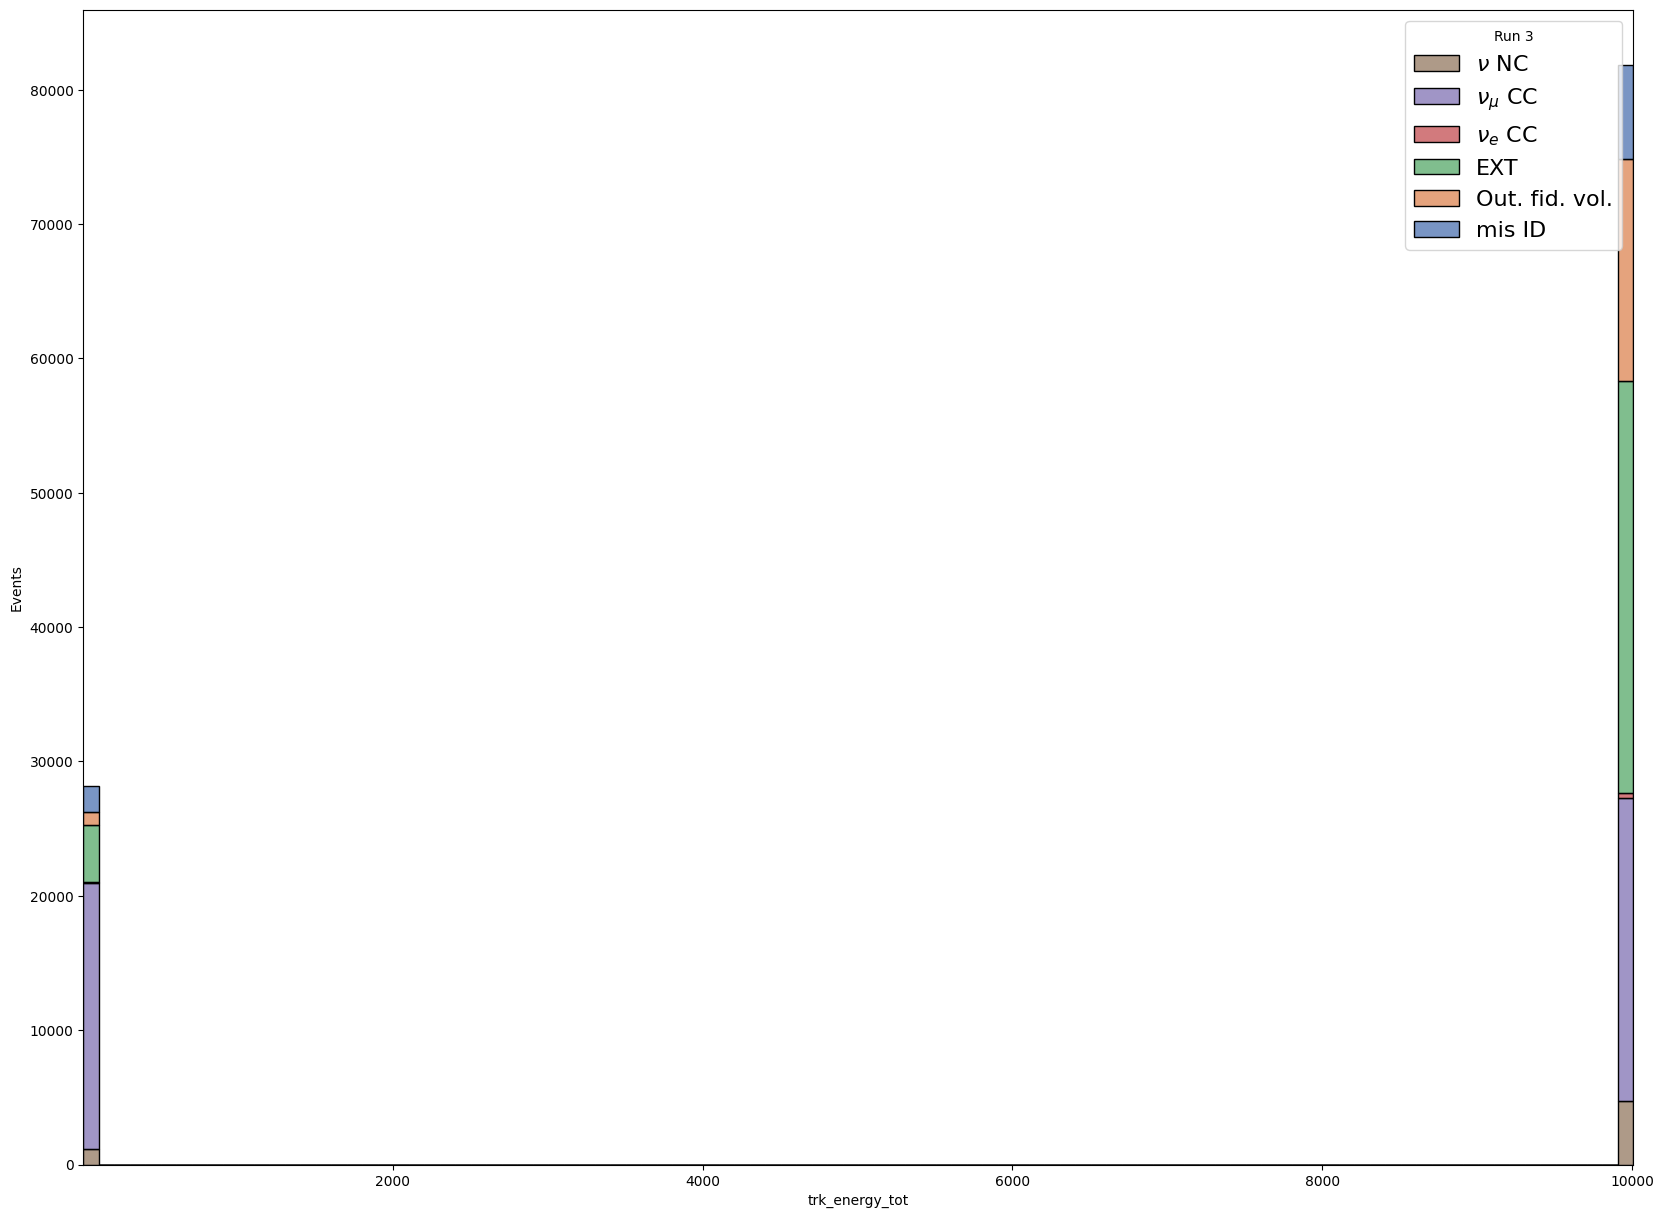

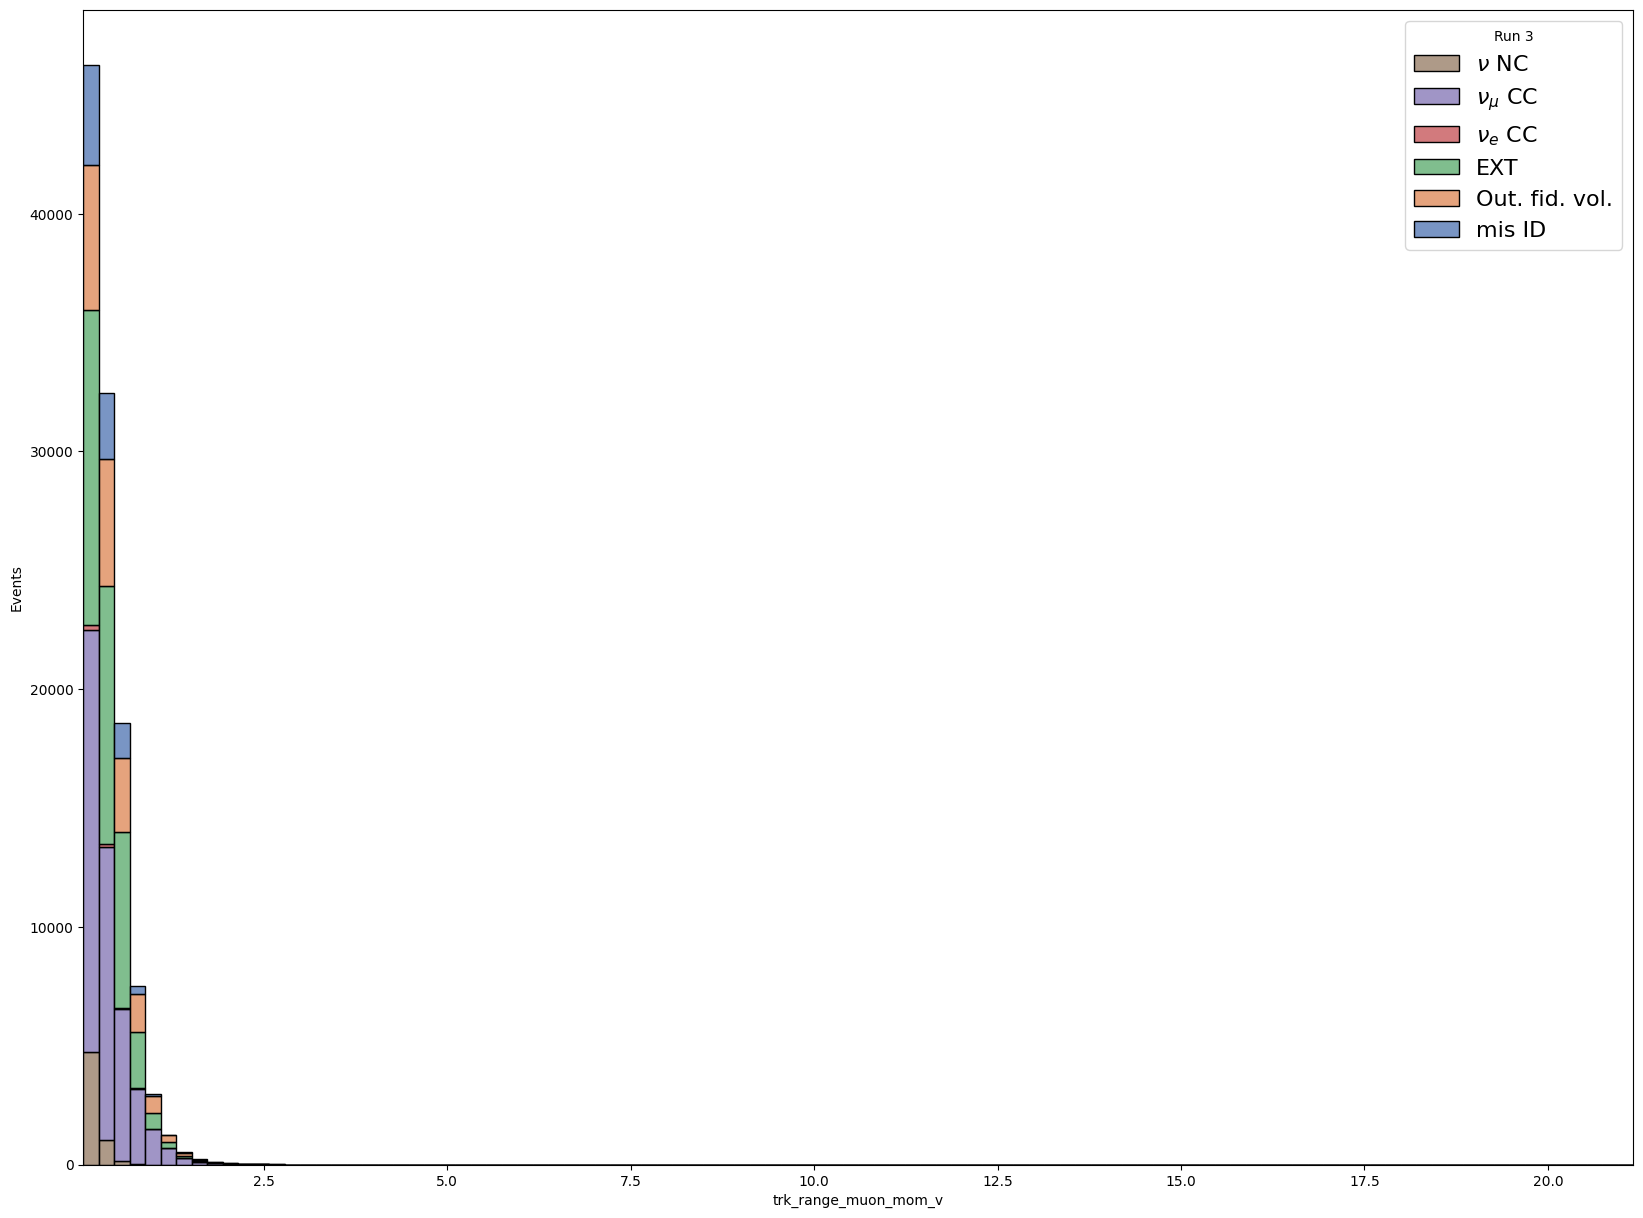

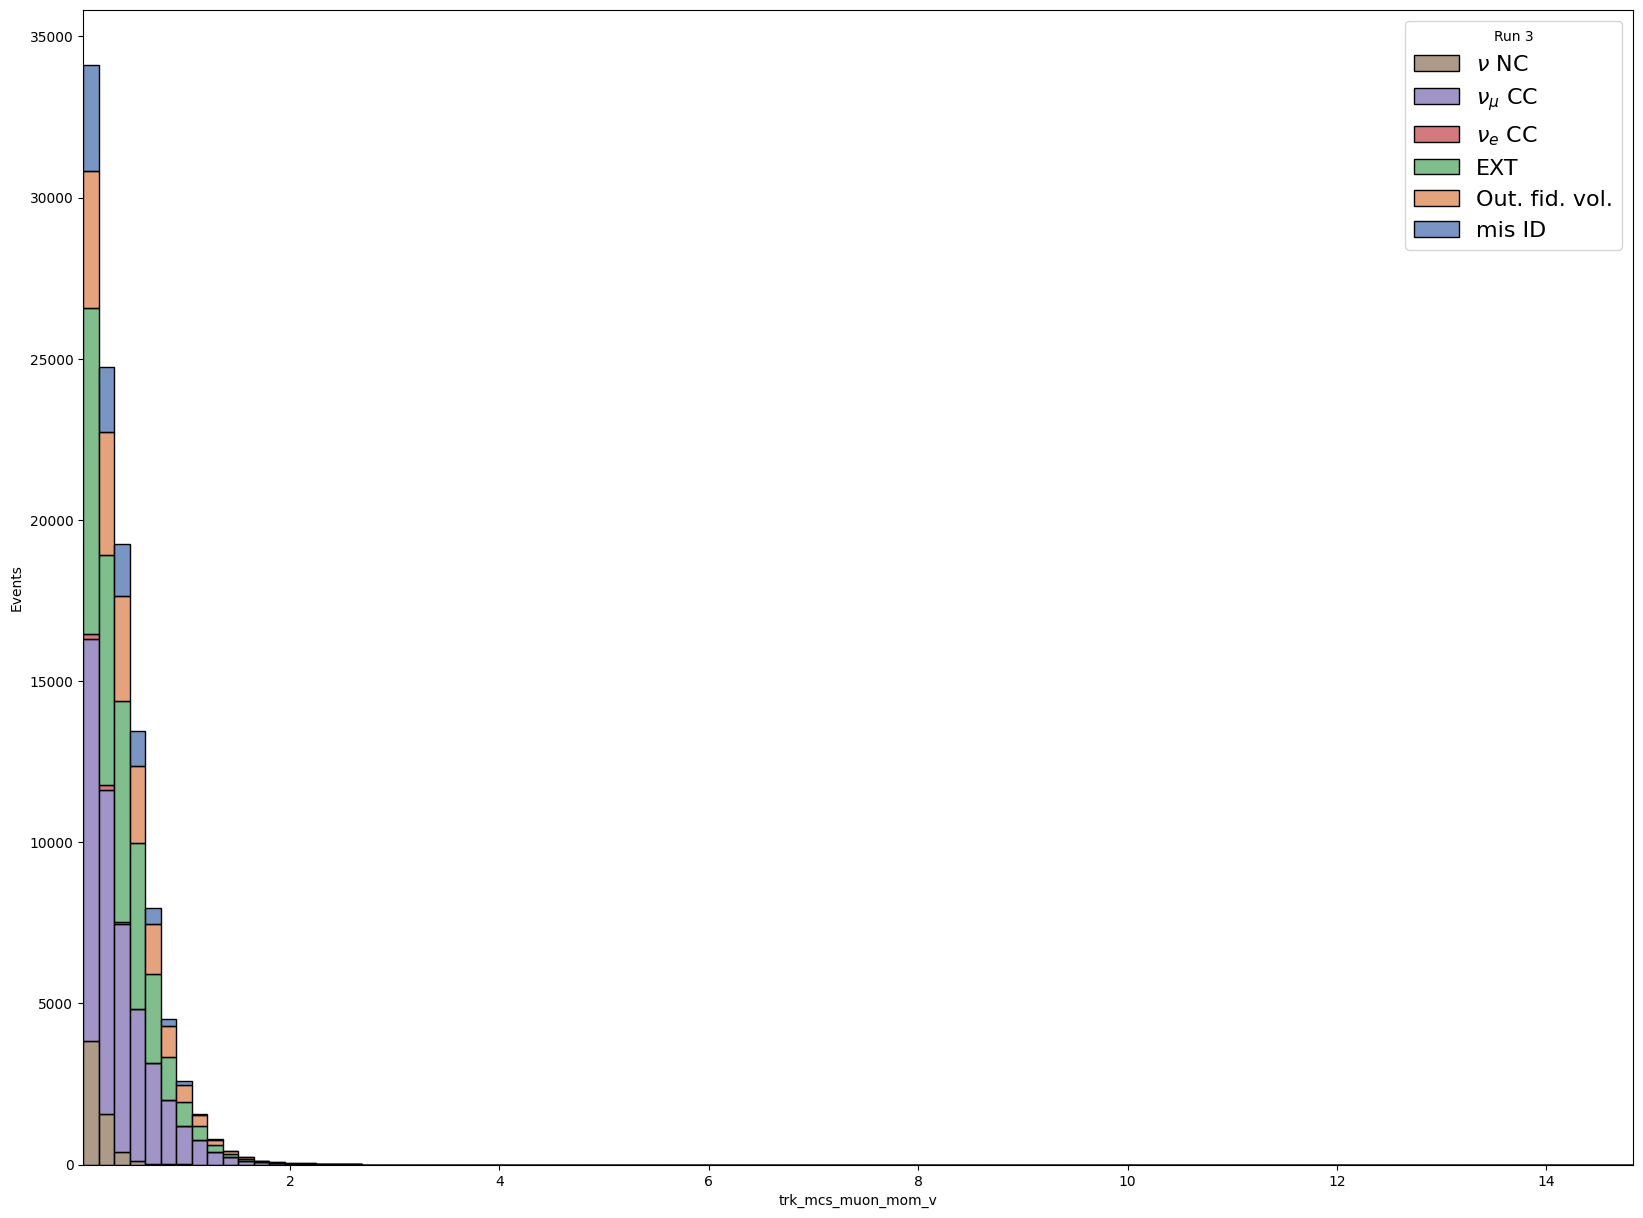

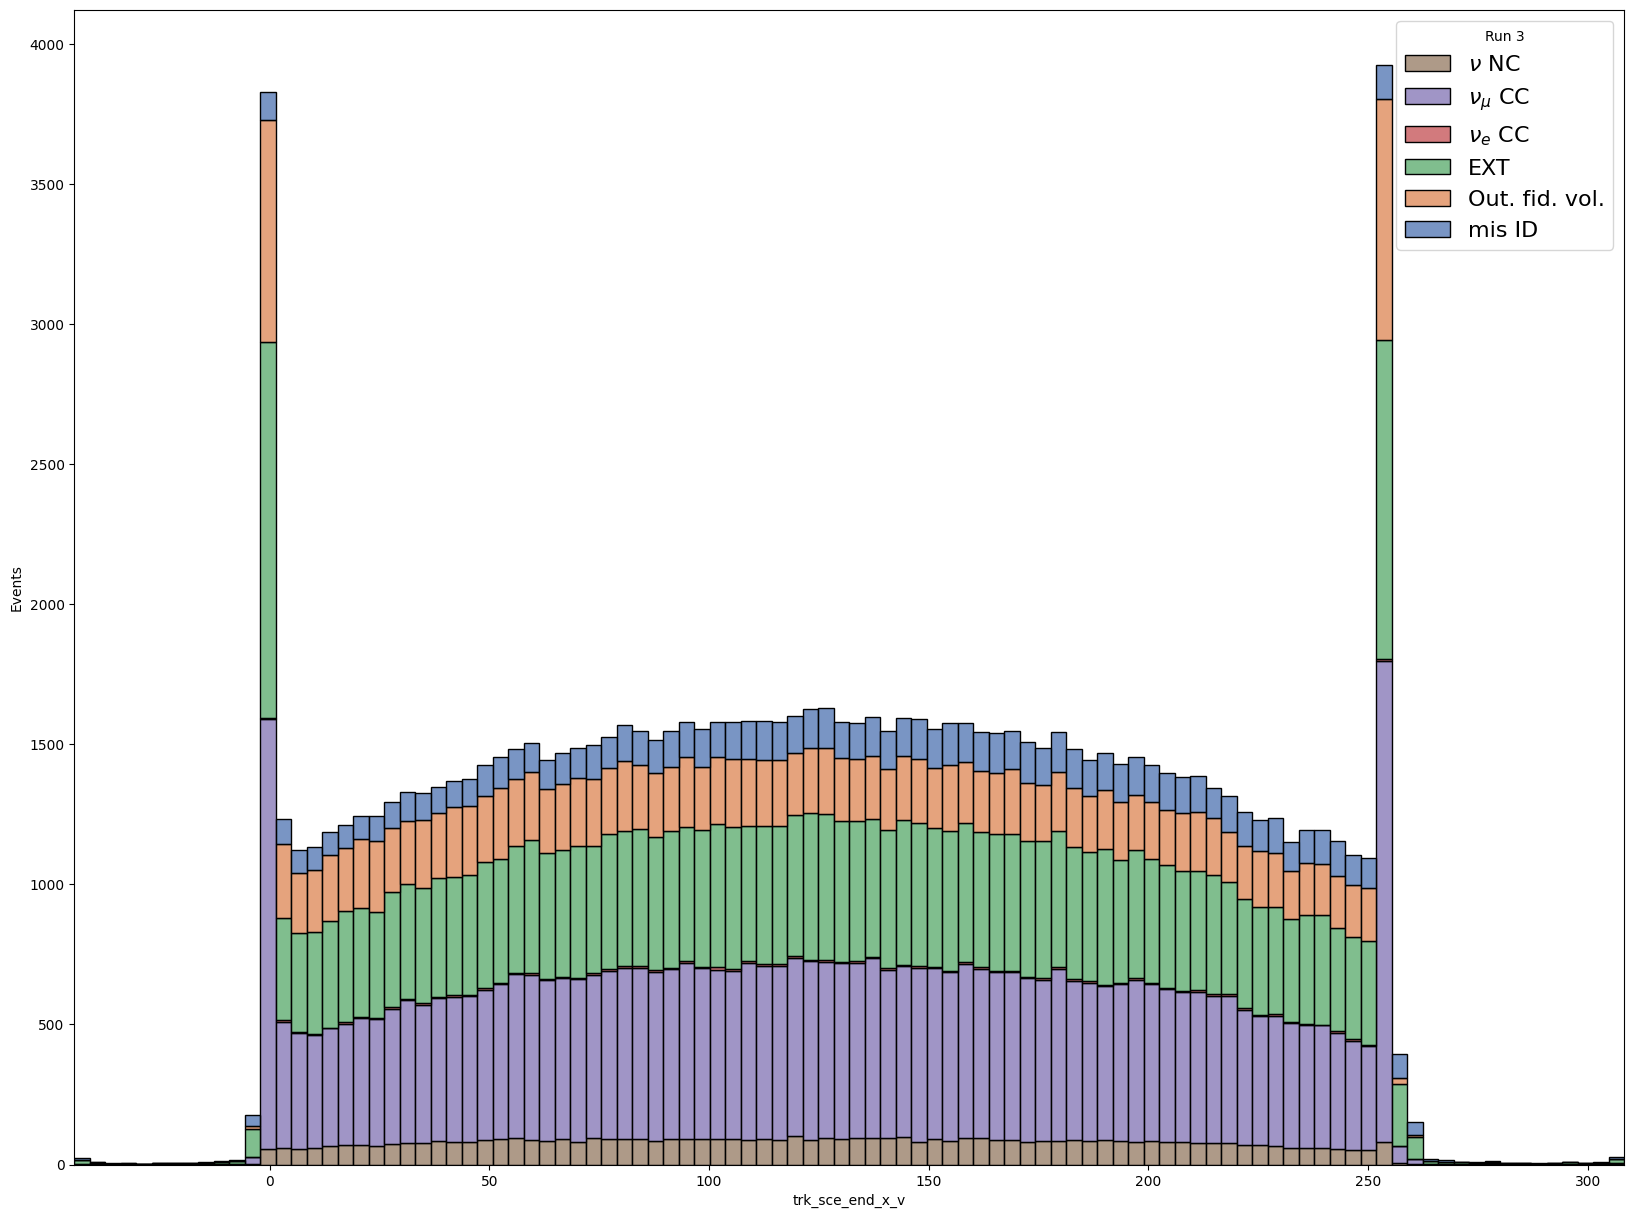

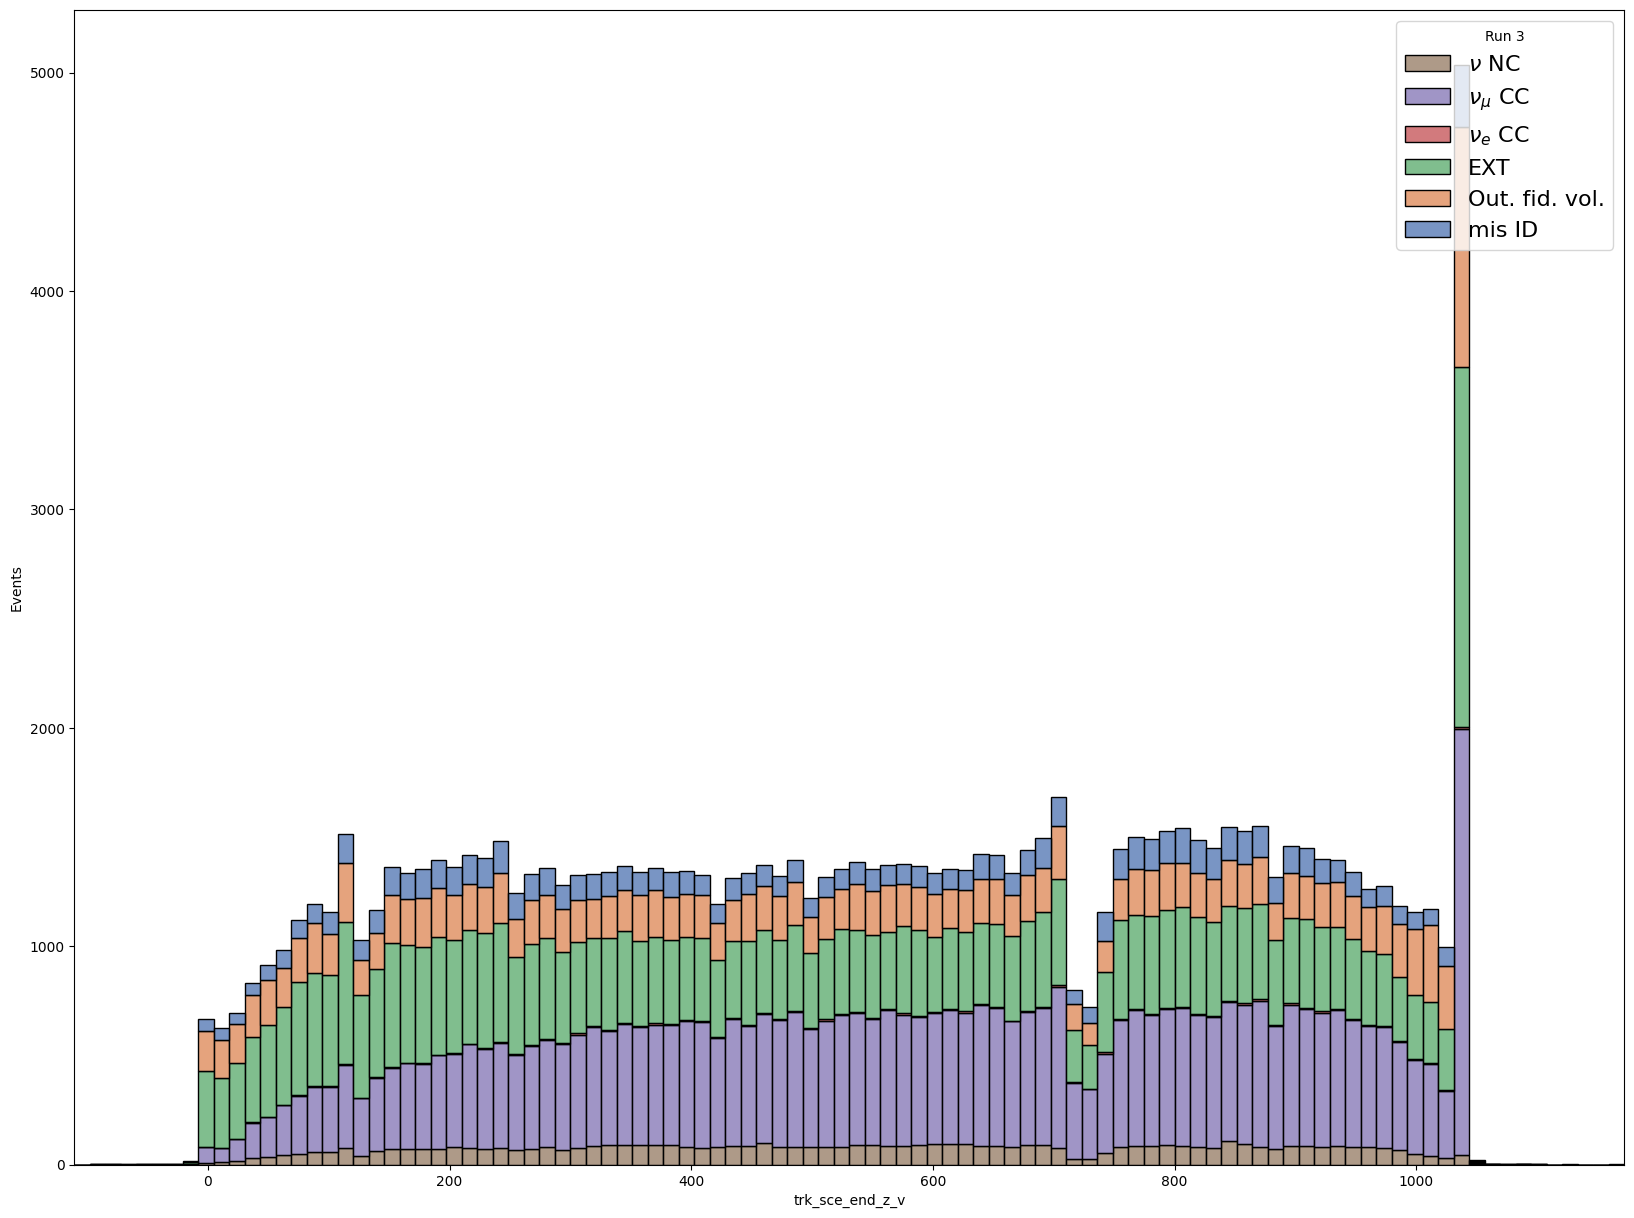

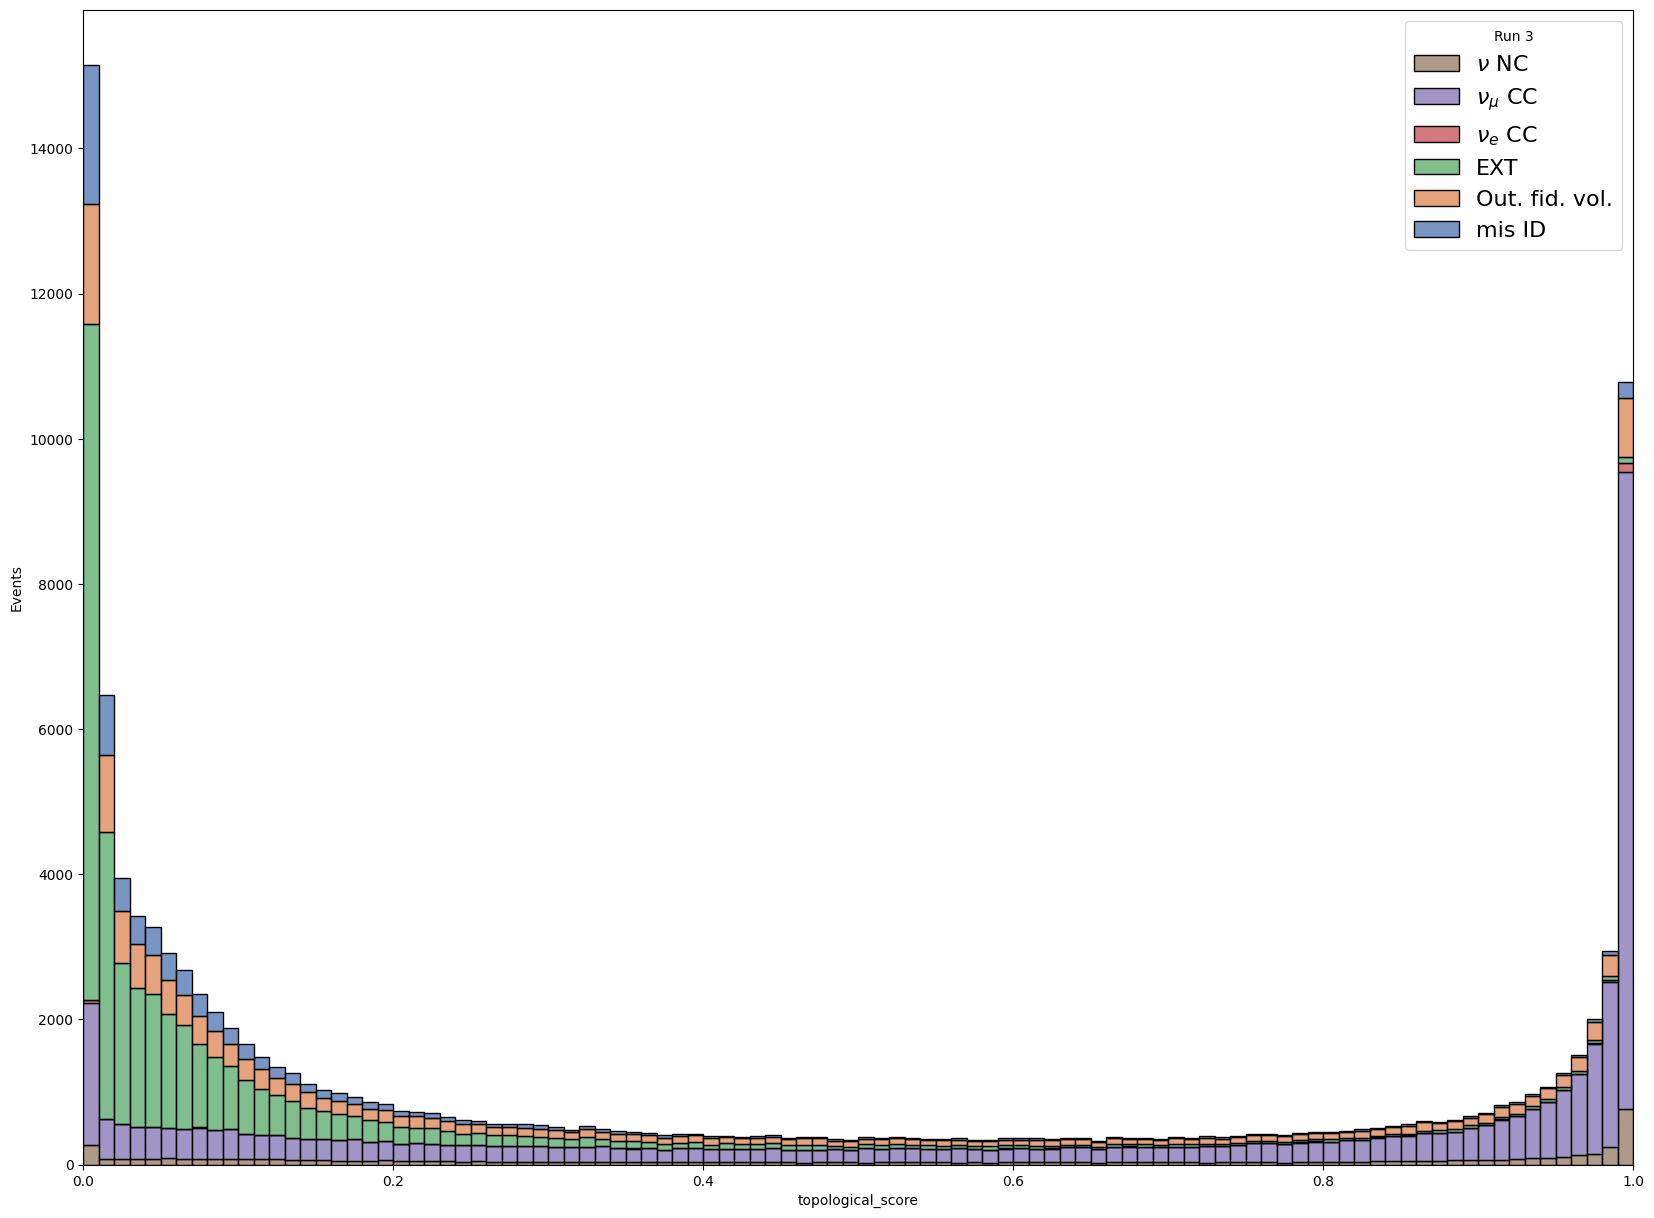

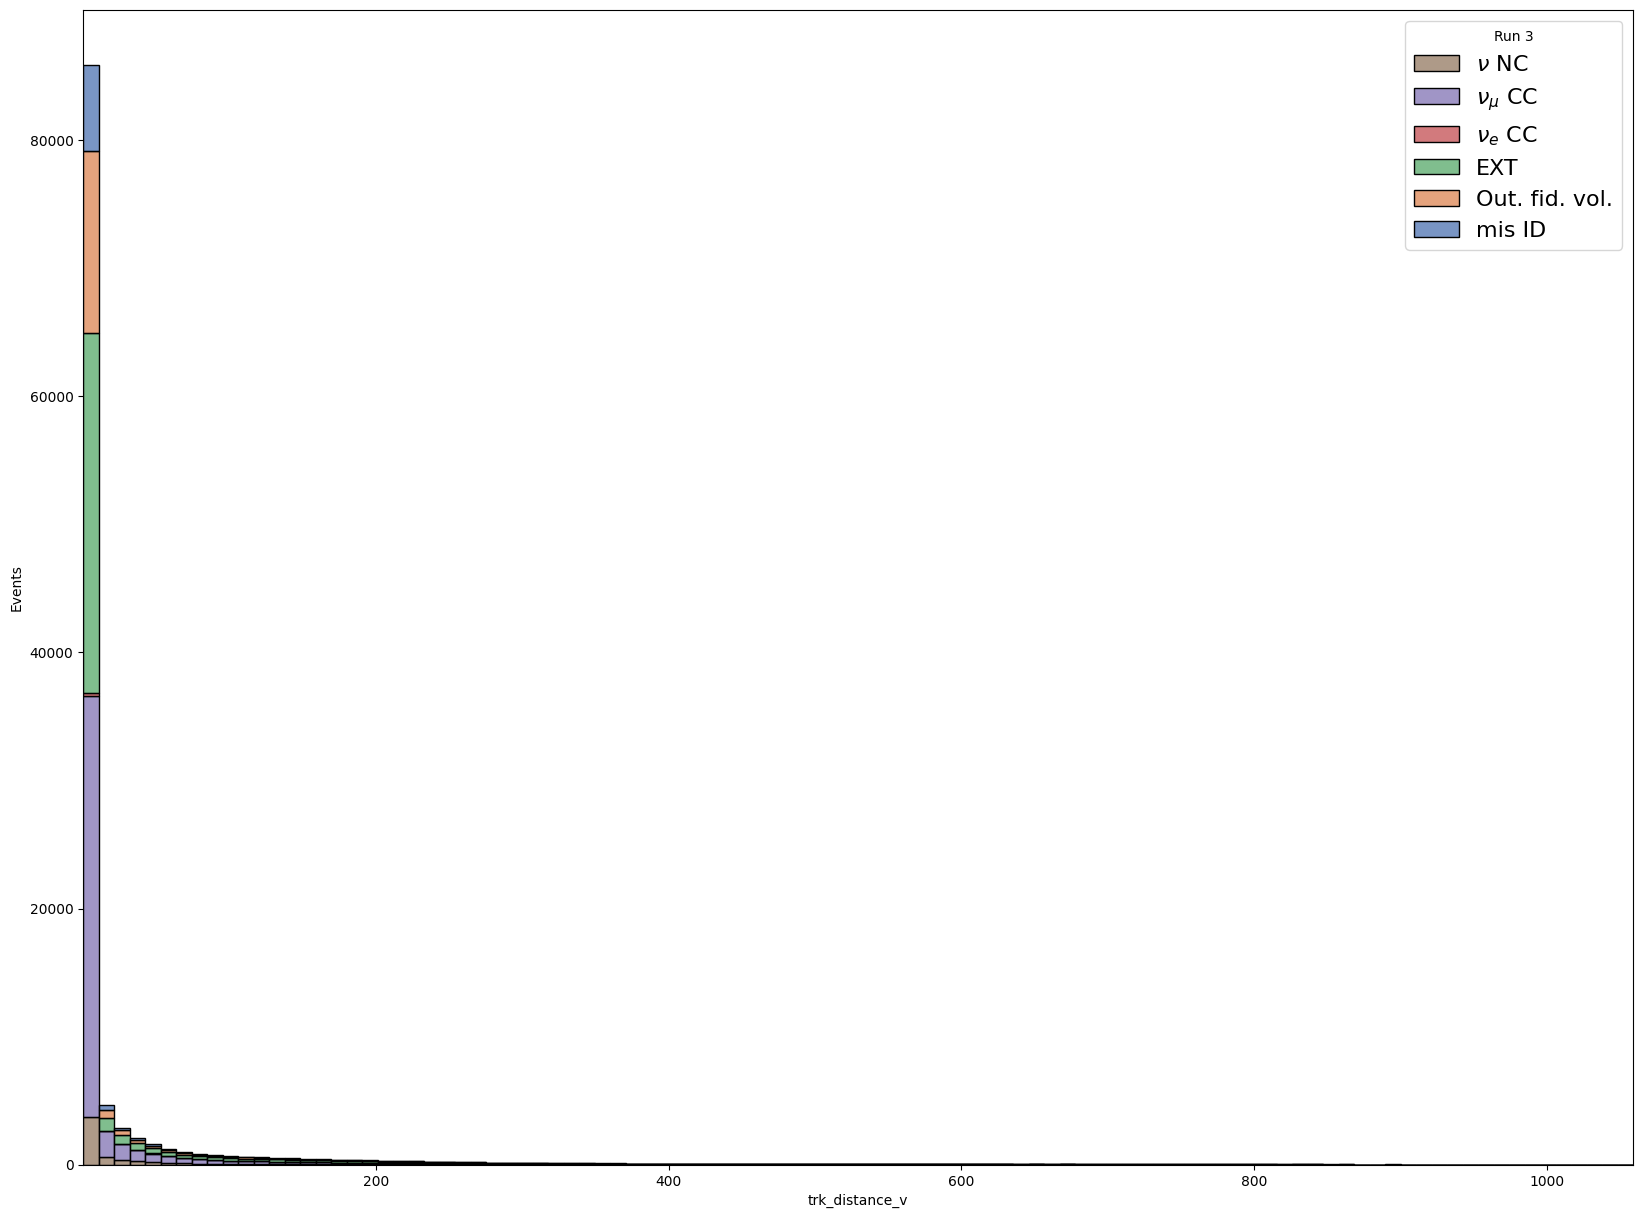

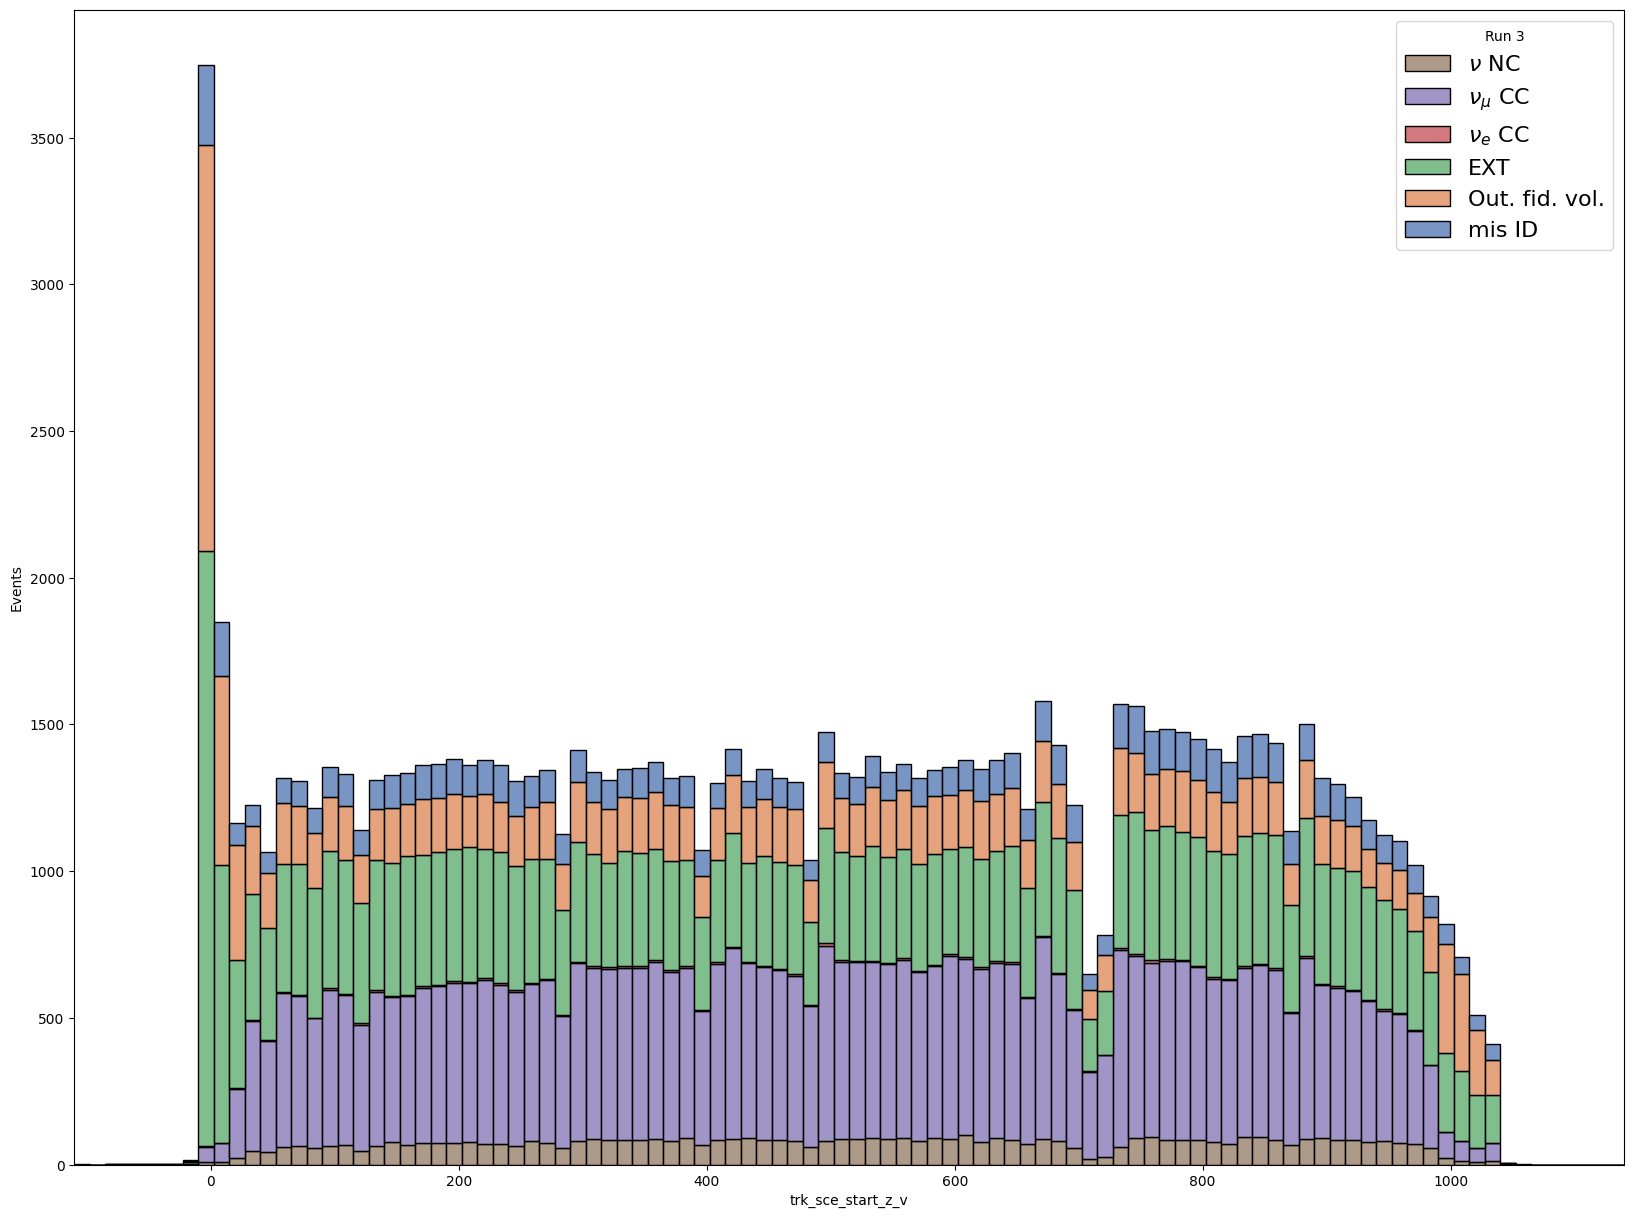

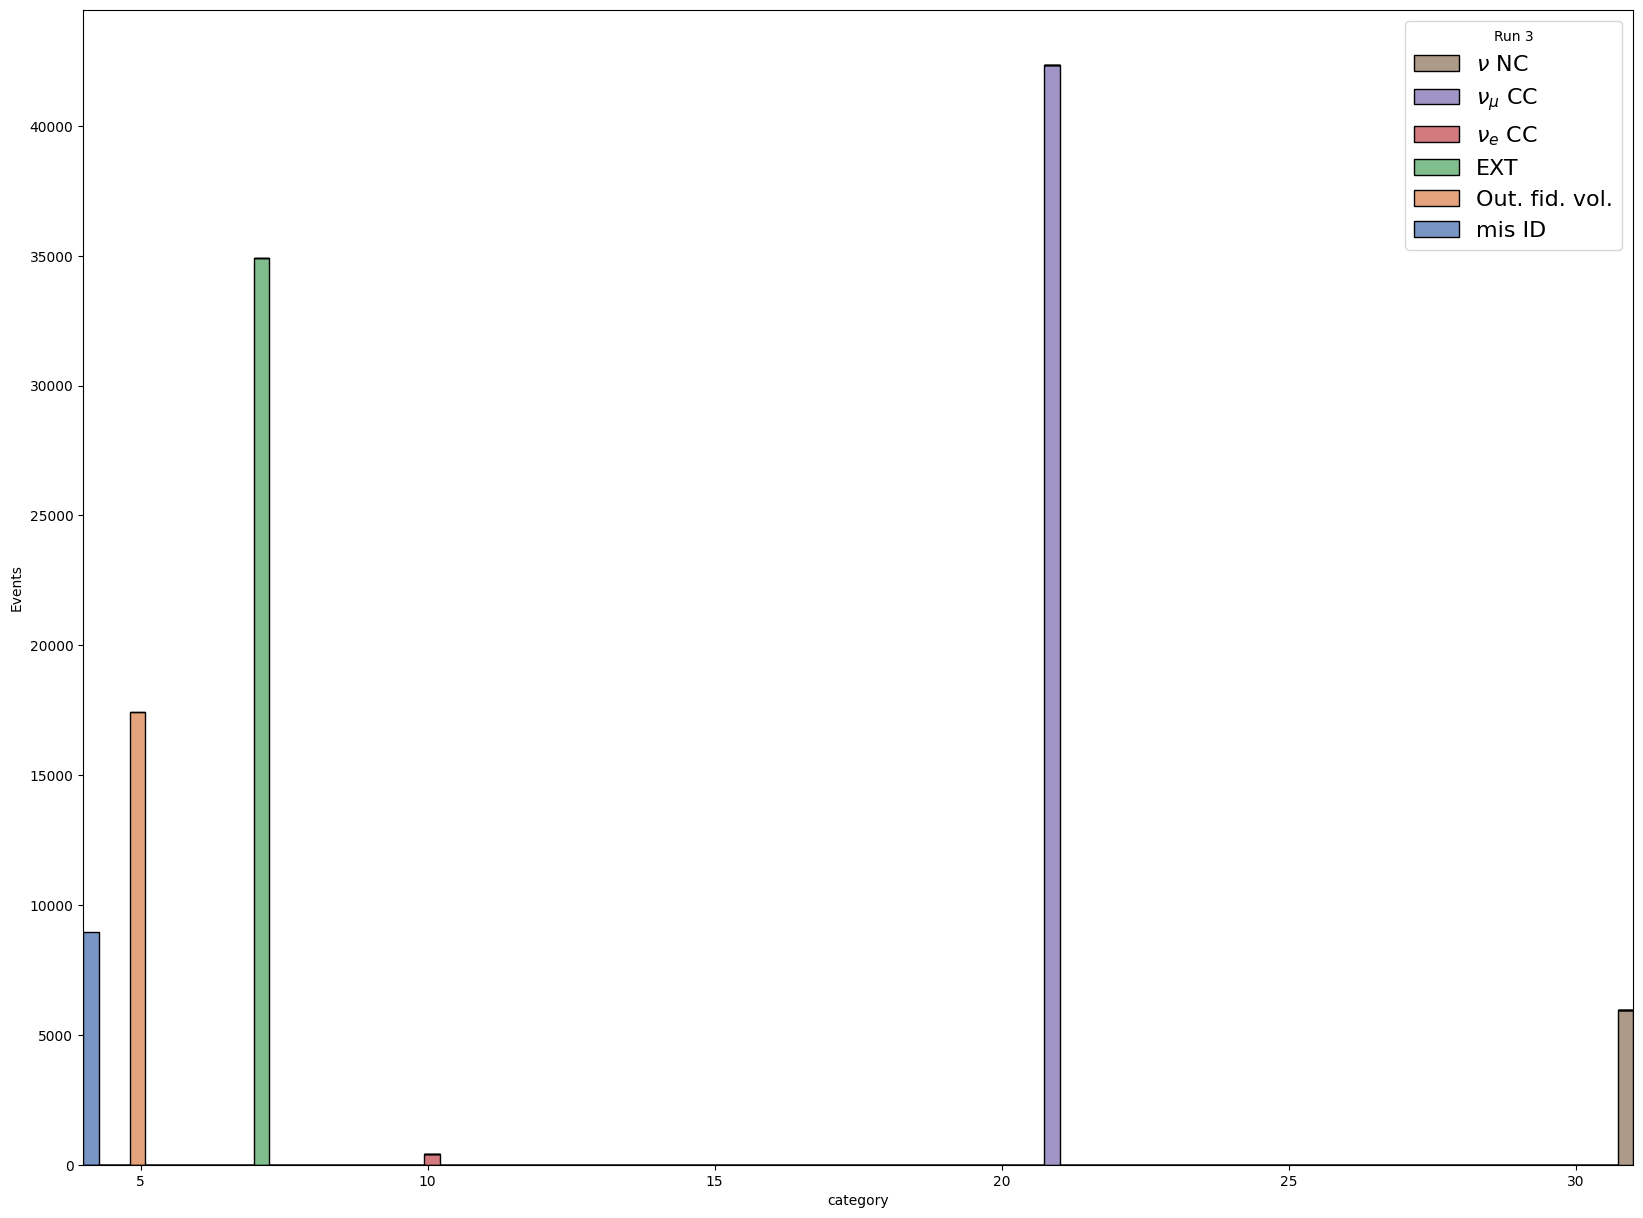

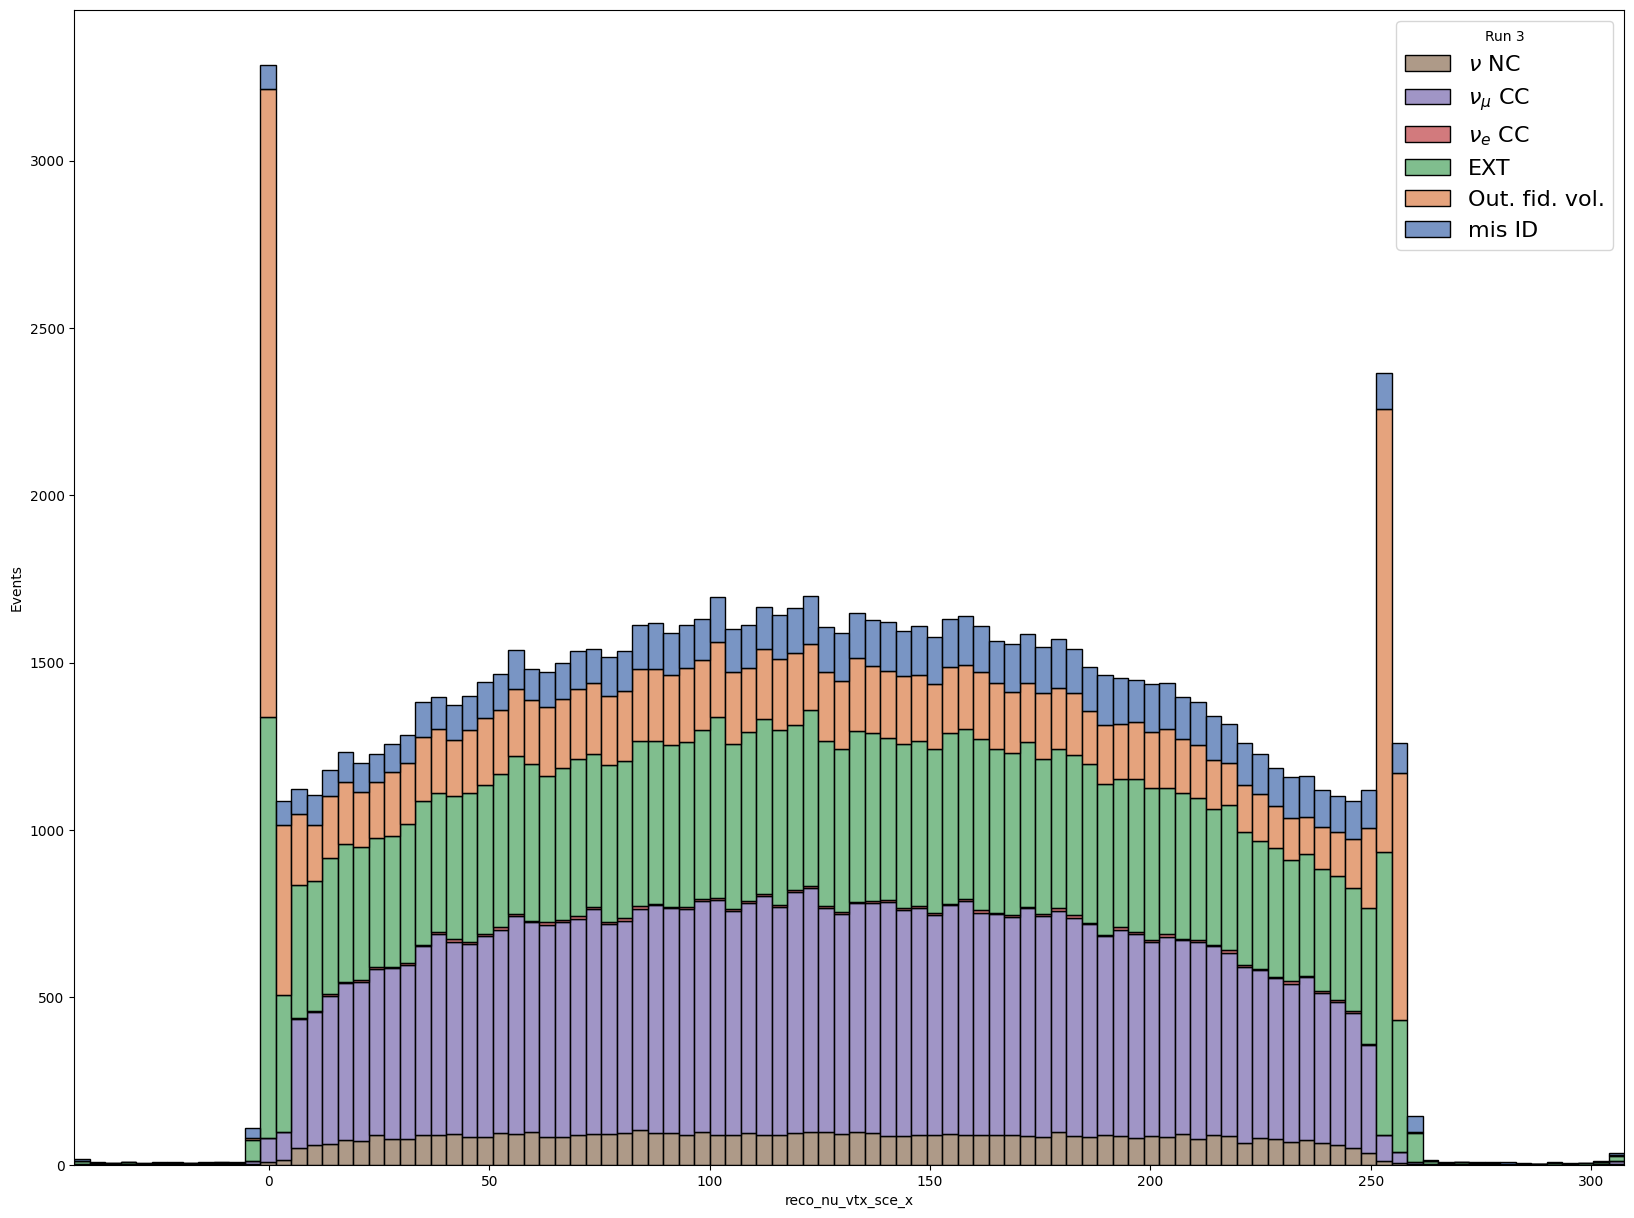

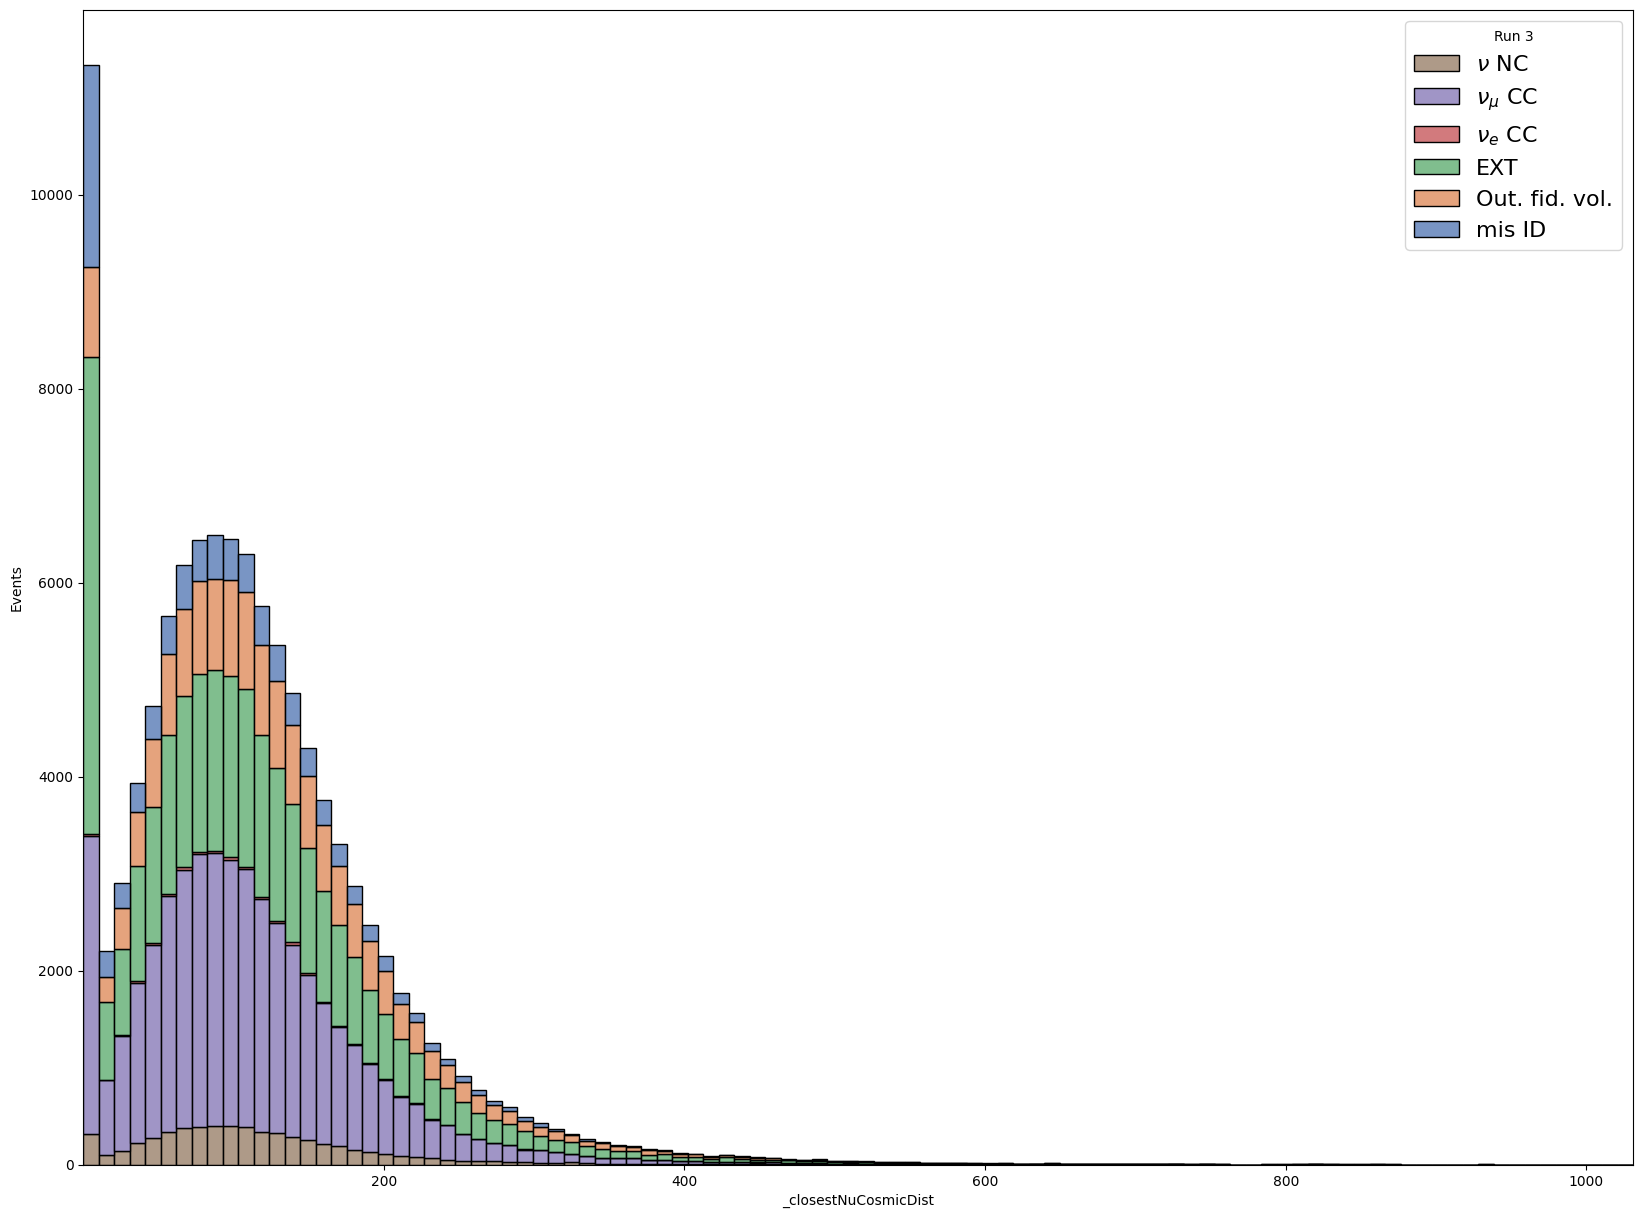

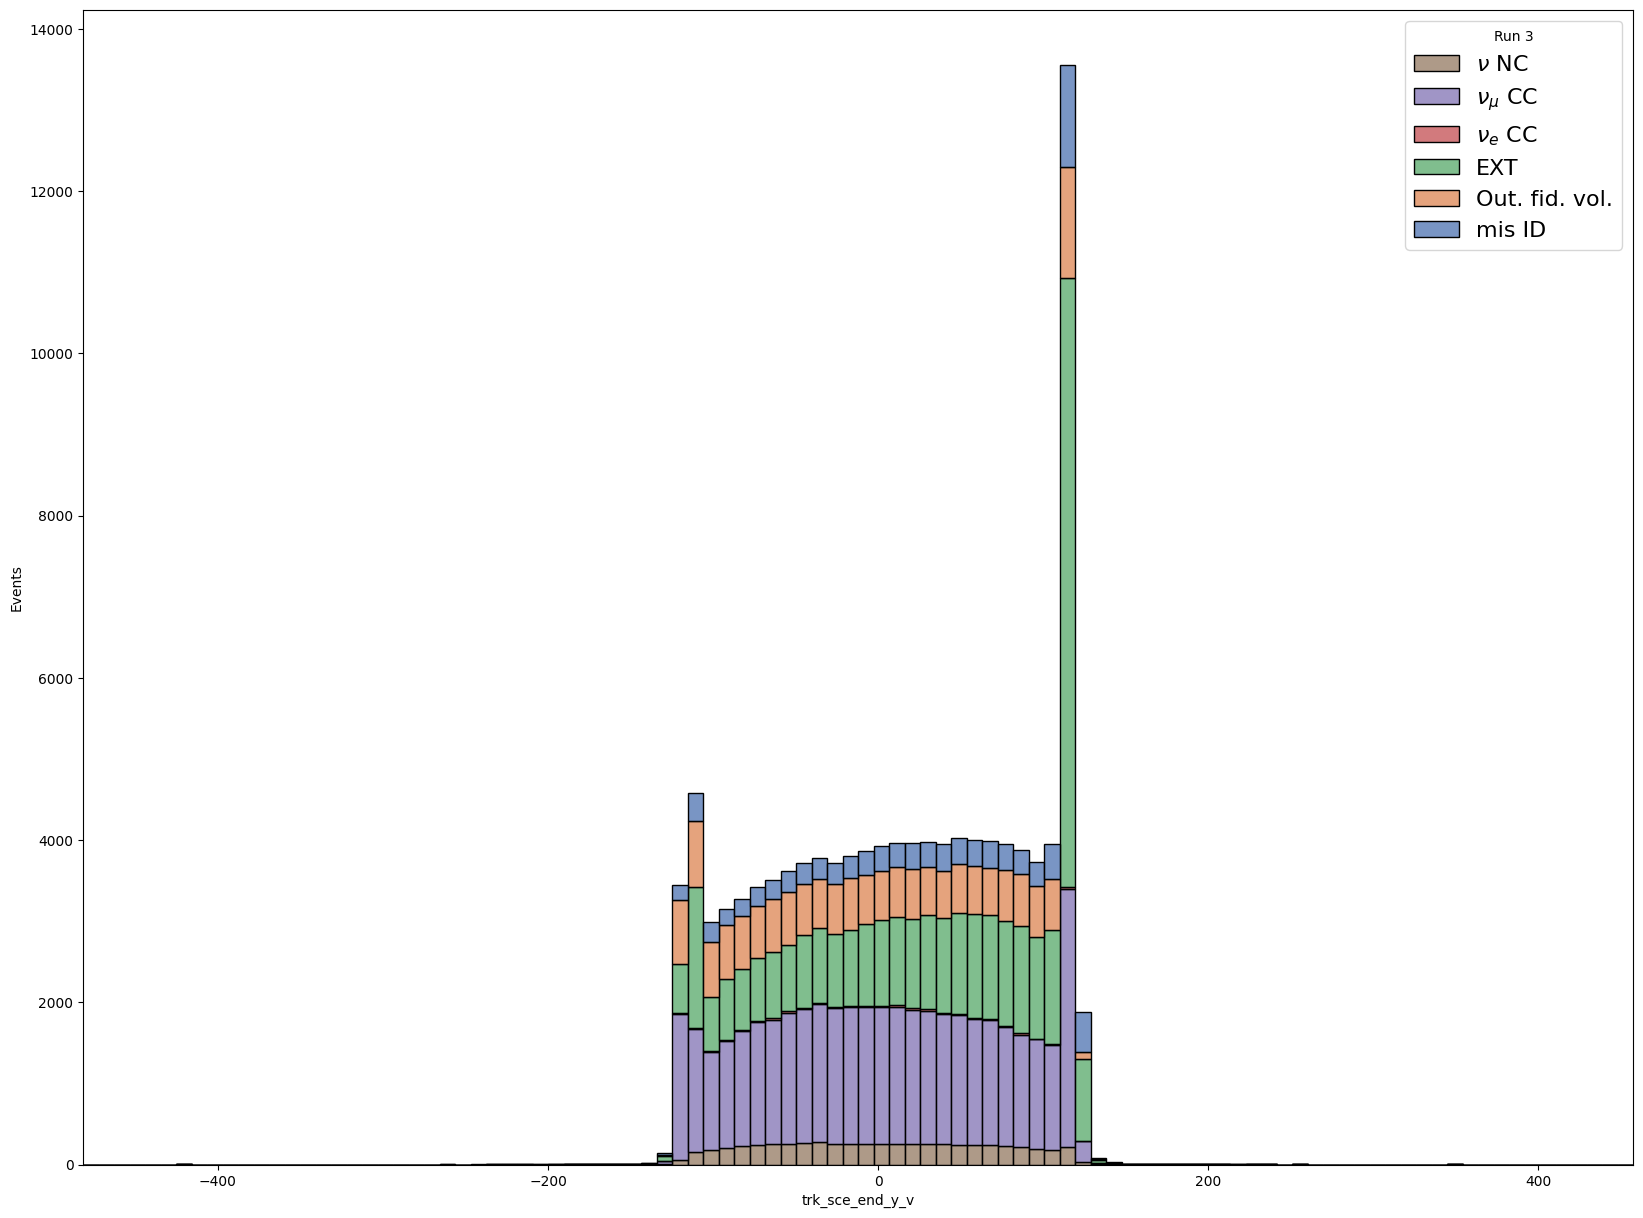

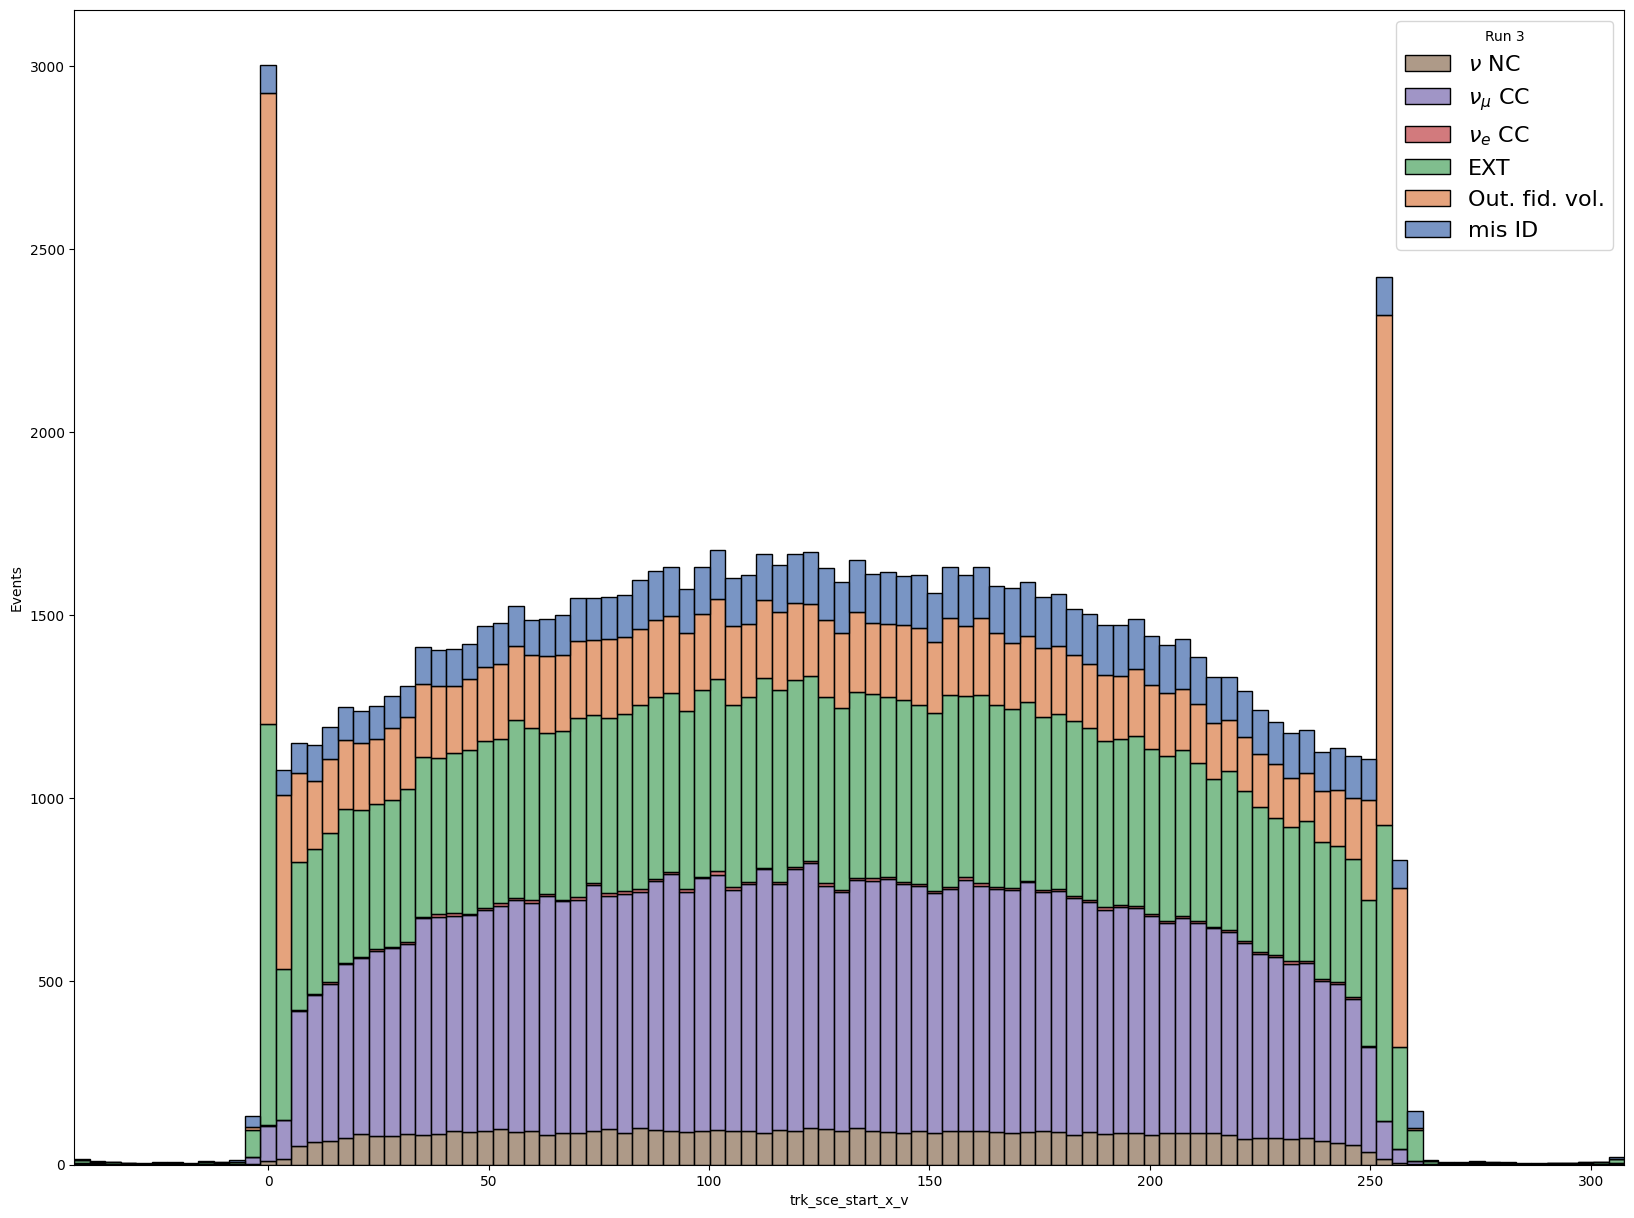

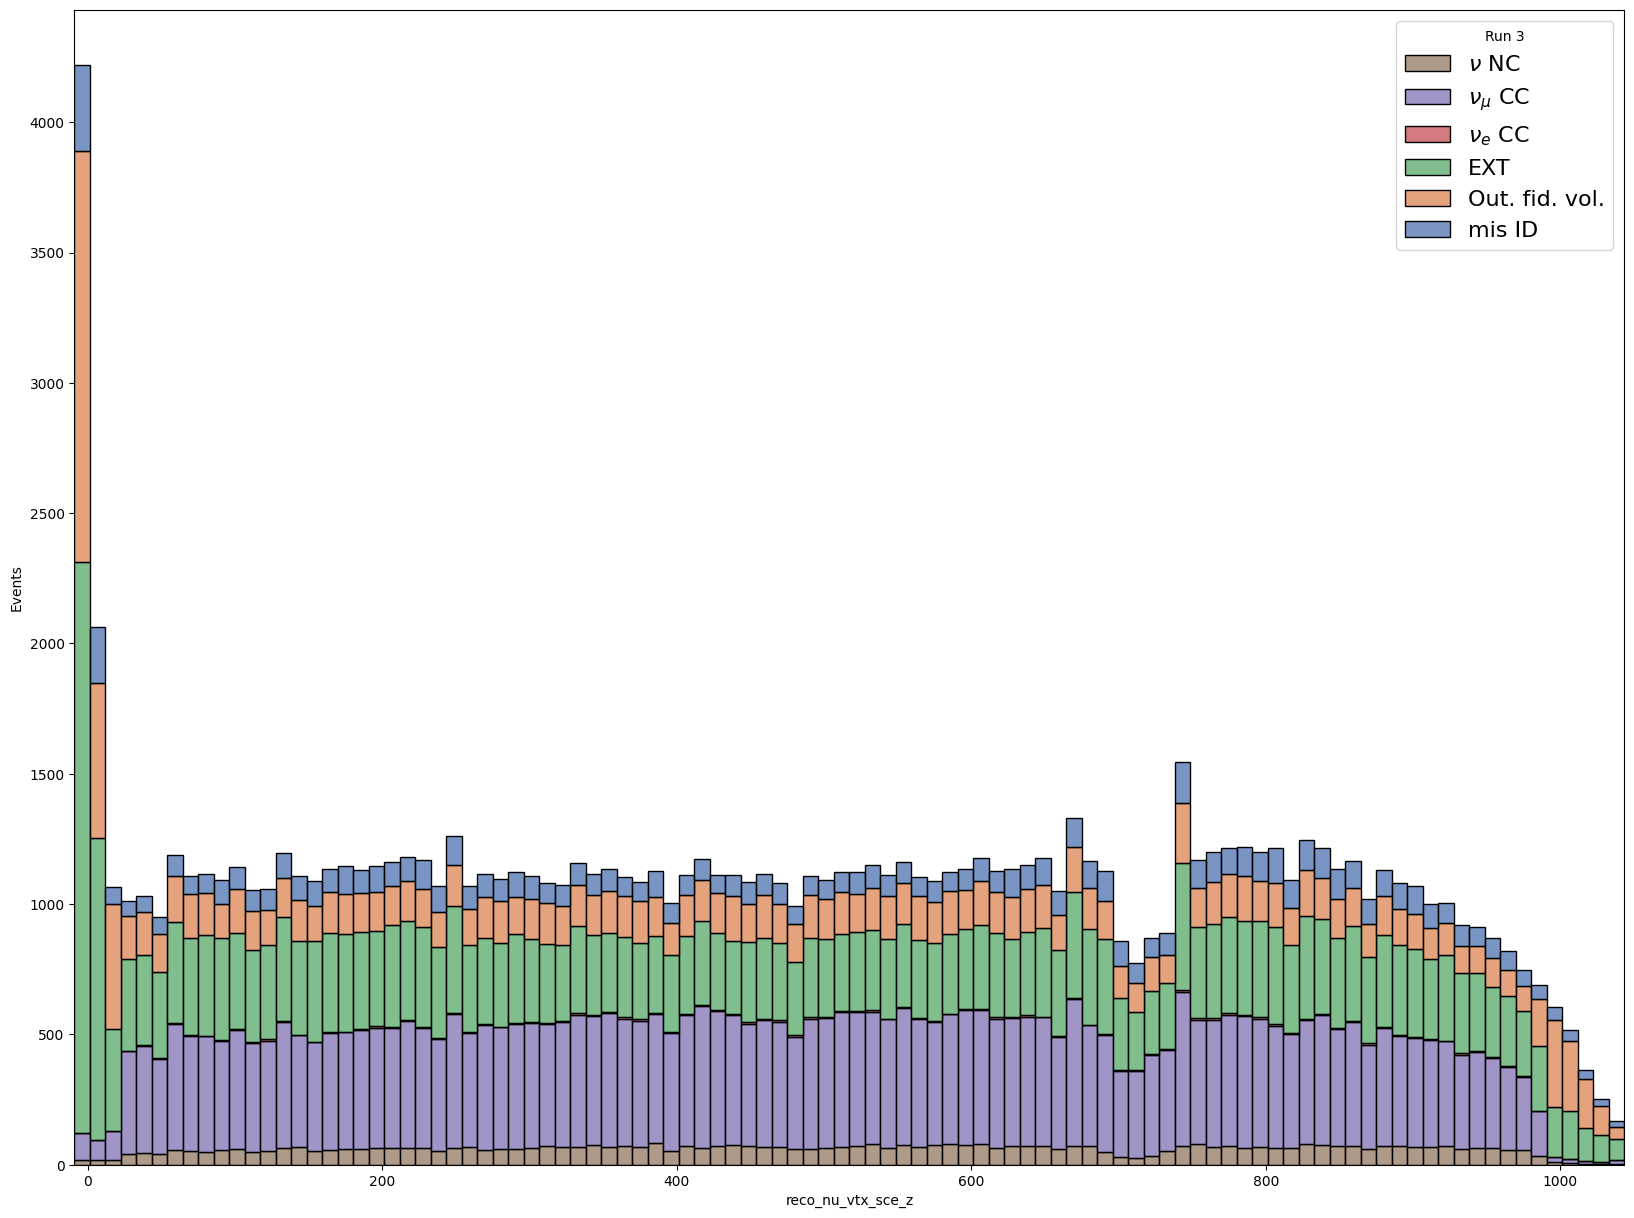

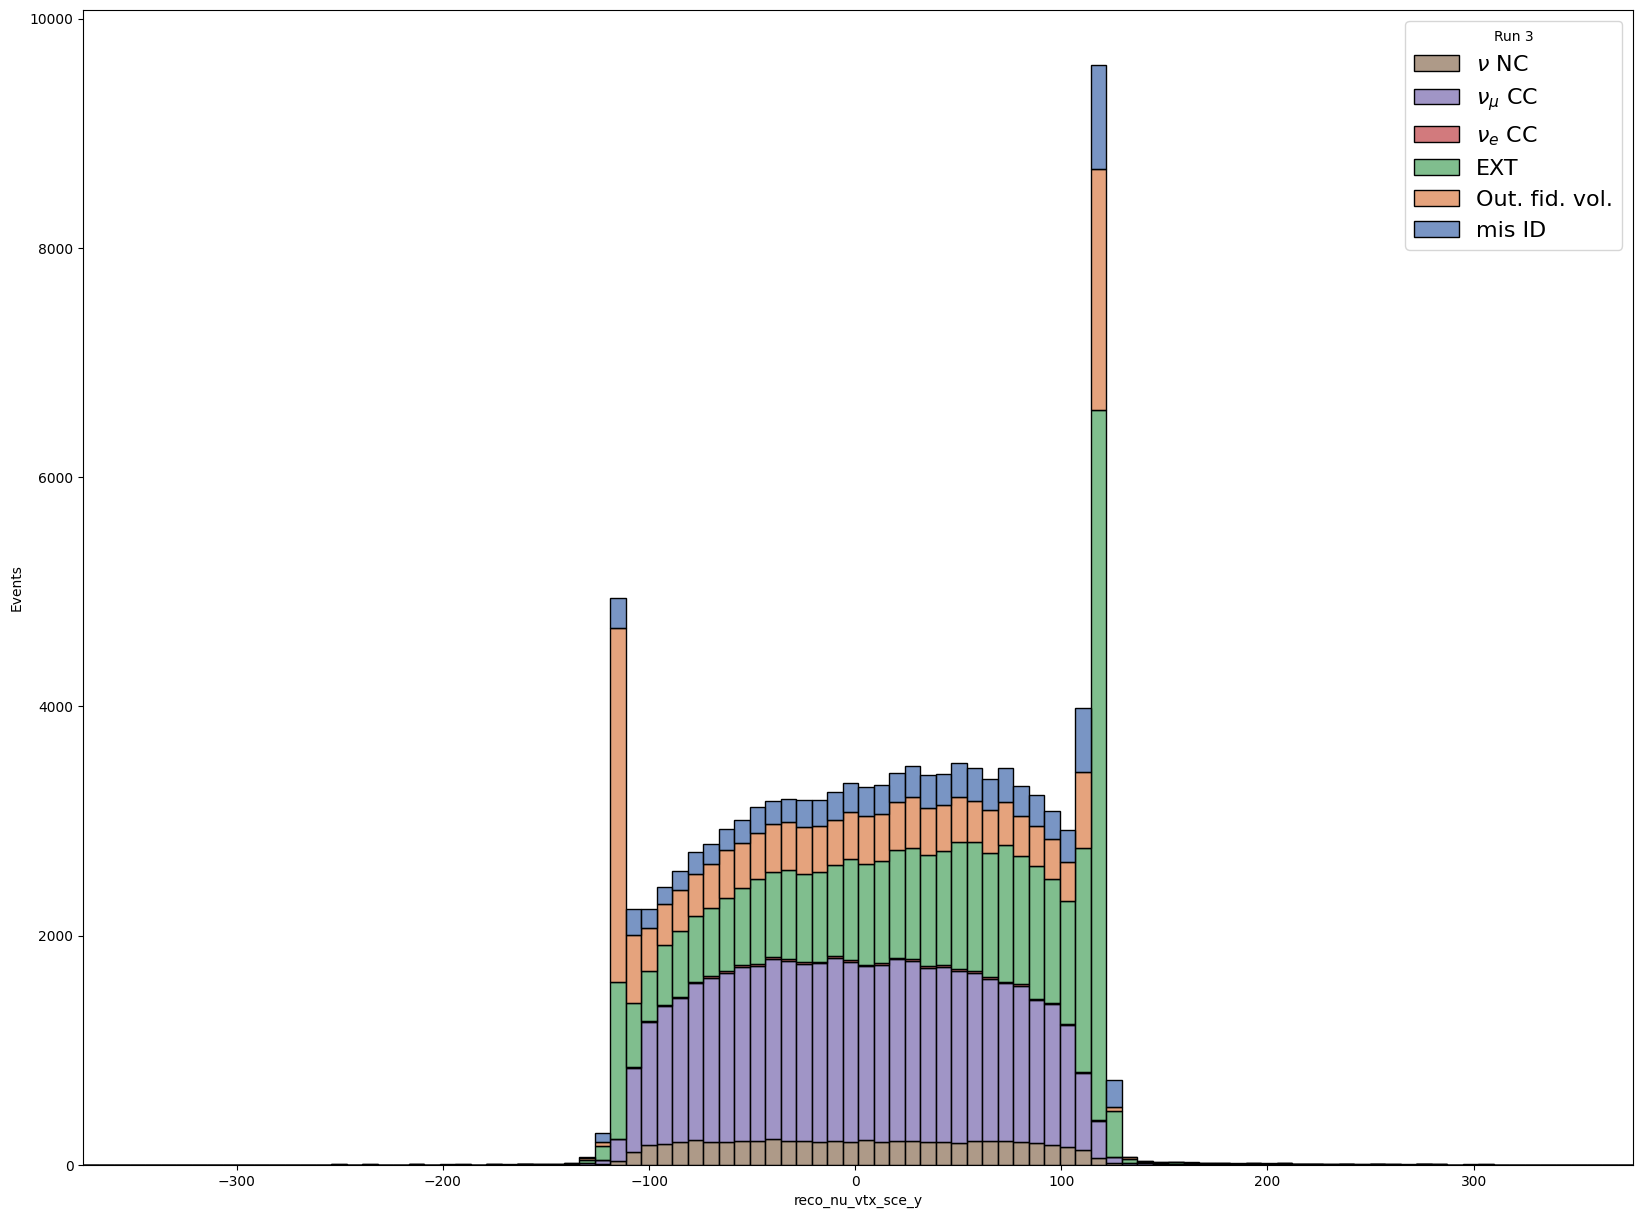

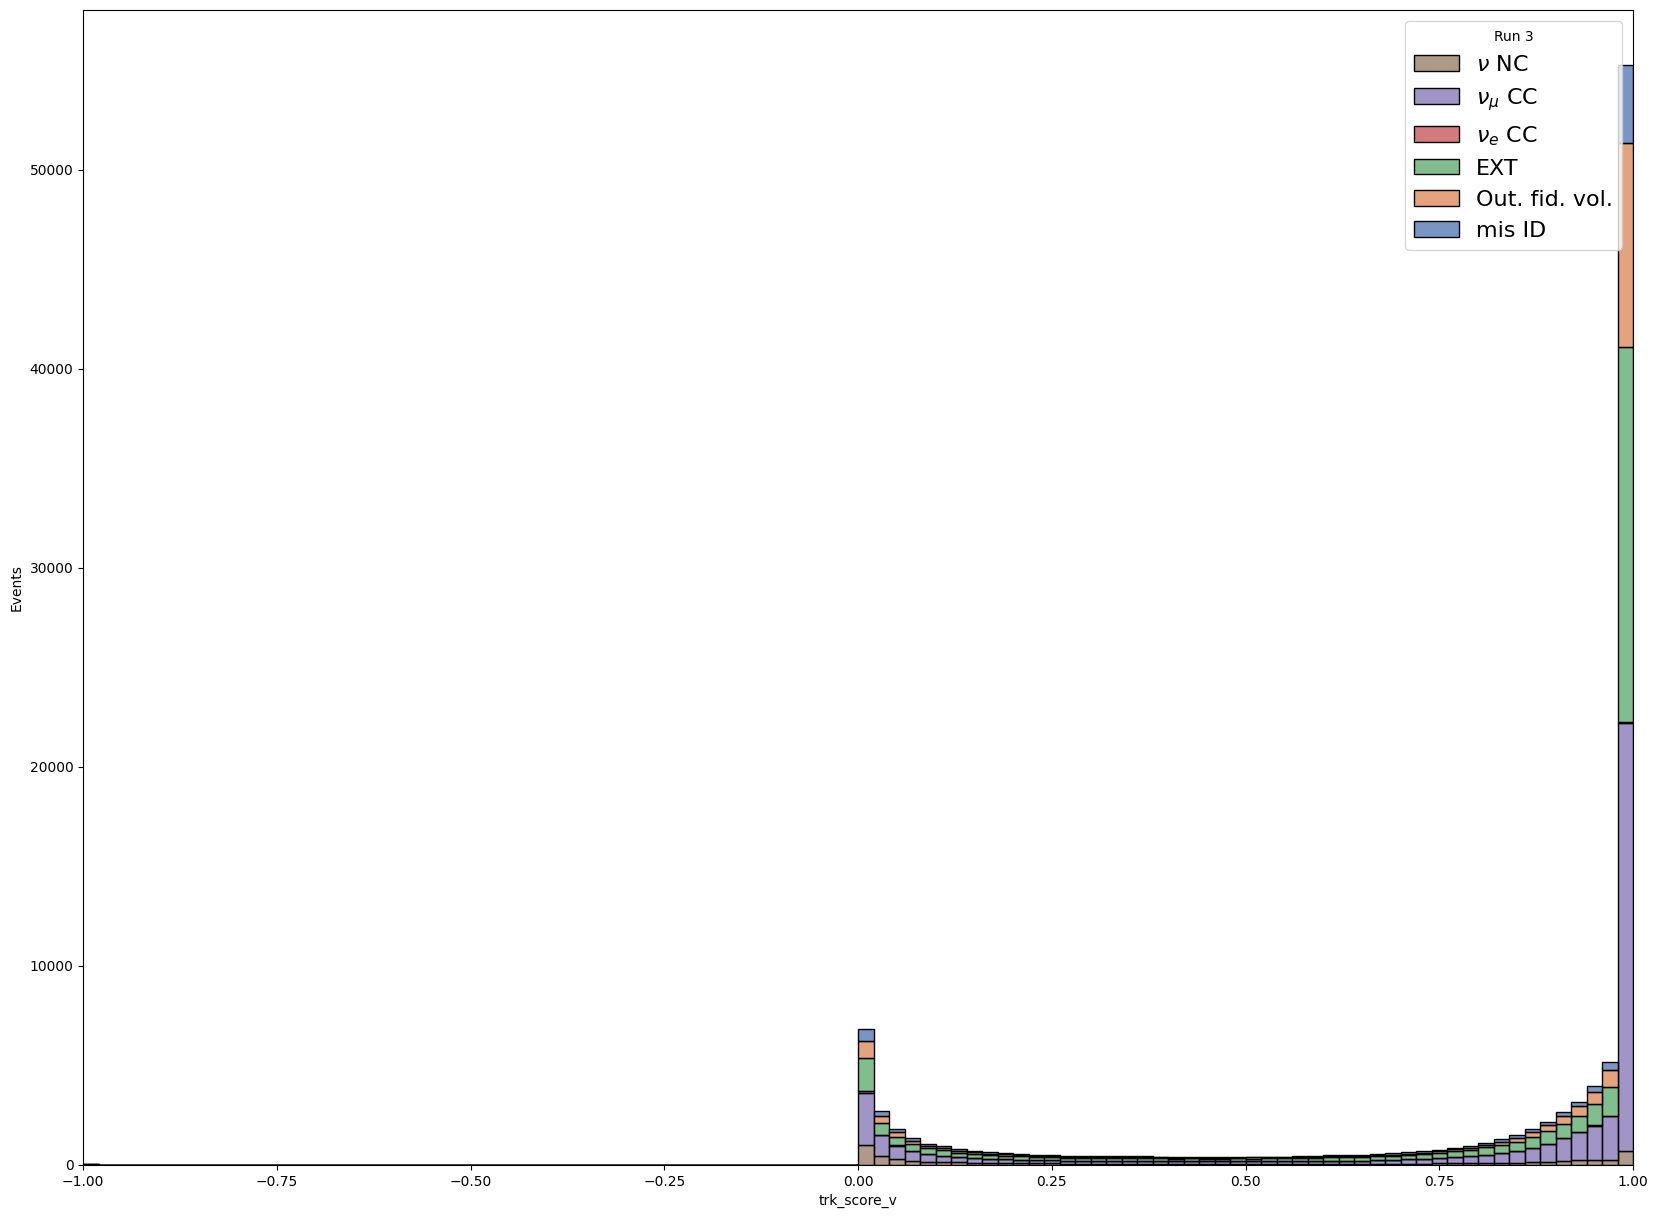

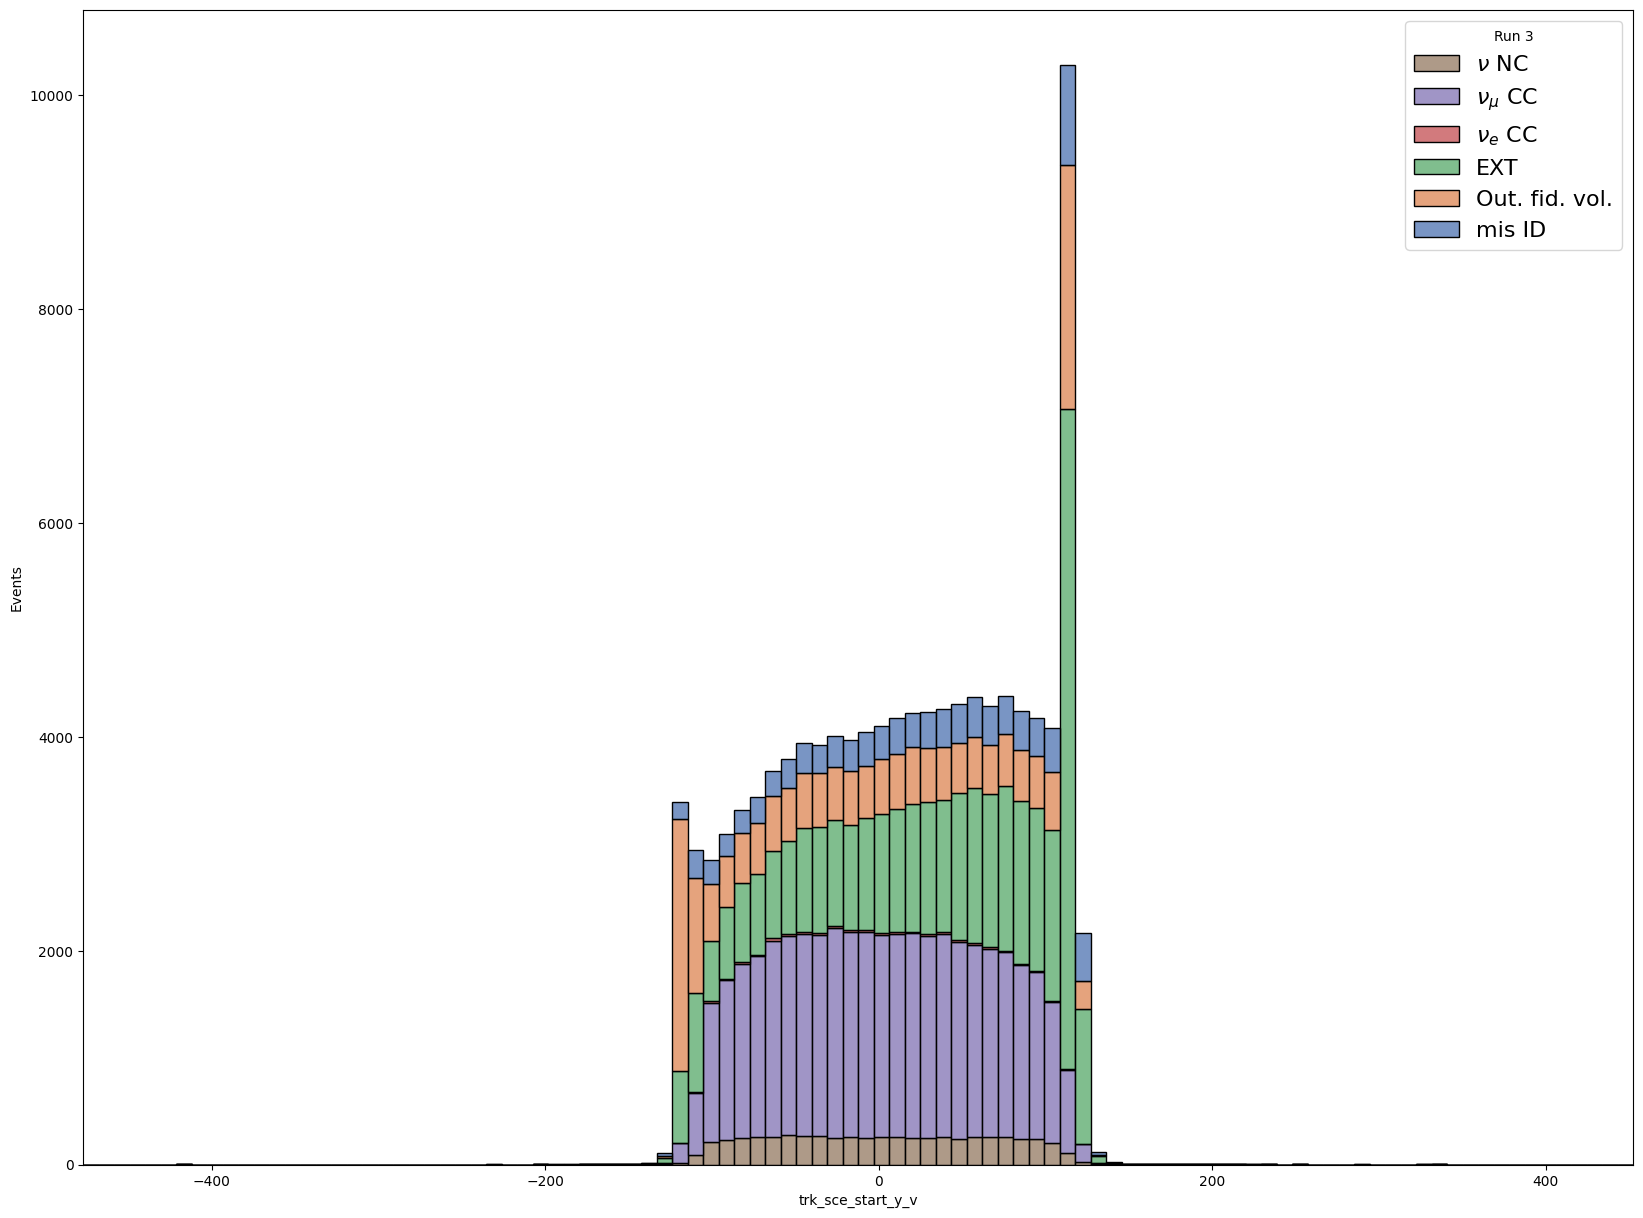

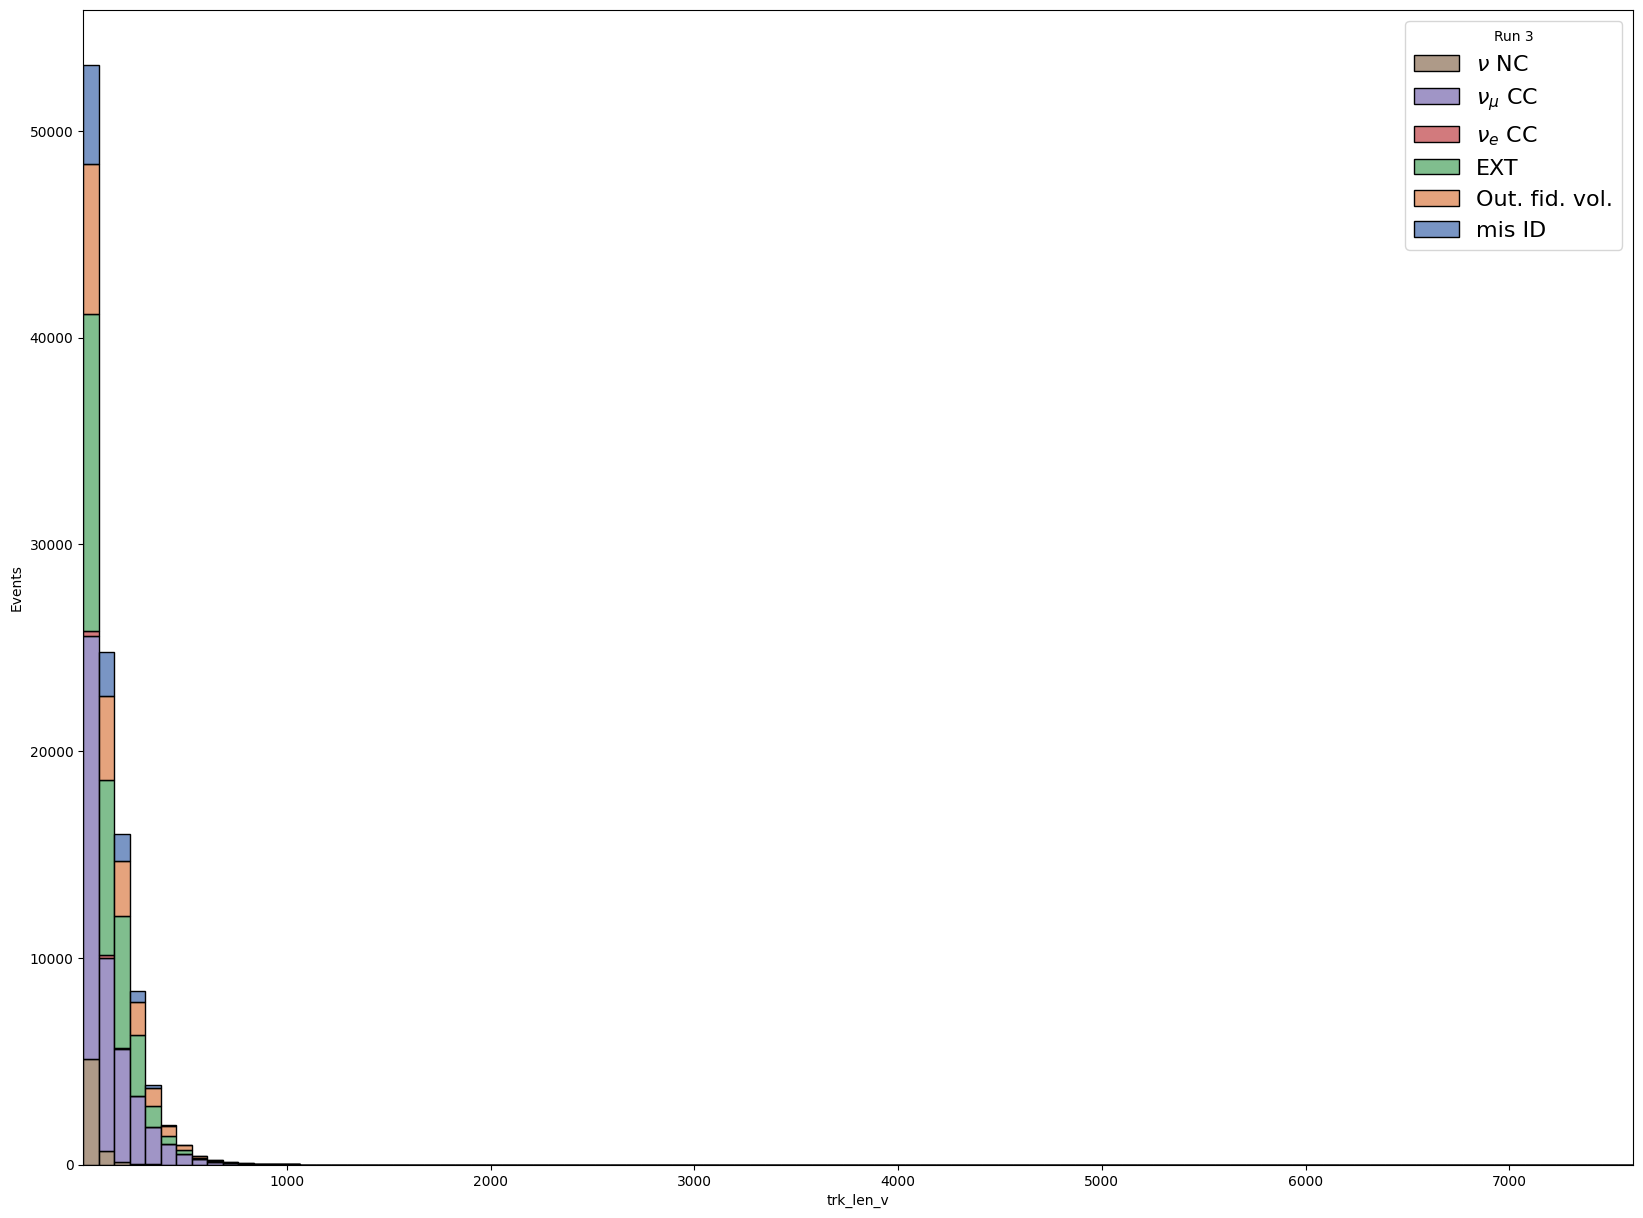

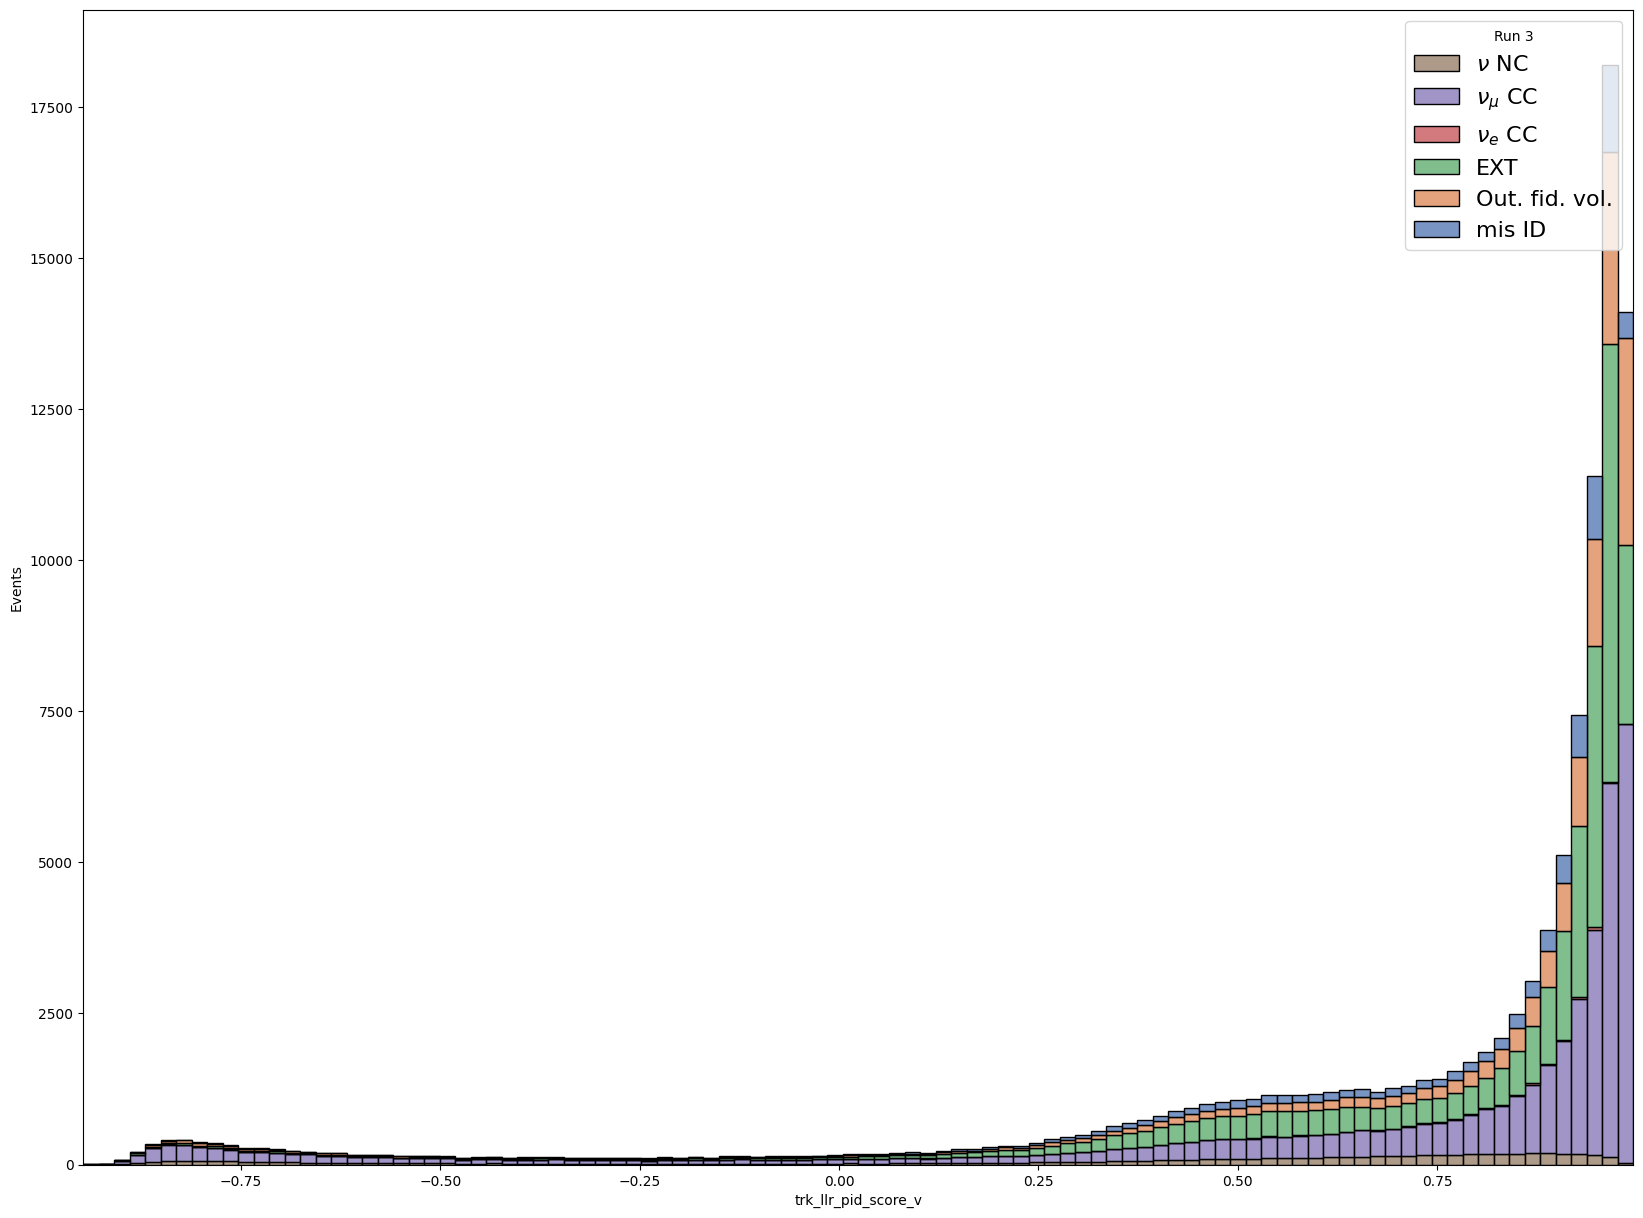

In [22]:
for variable in all_variables_to_plot:
    BIN = 100
    plt.figure(figsize=(20,15))
    i = sns.histplot(data=MC_EXT, x=variable, multiple="stack", hue="category", palette = 'deep', weights = MC_EXT['weight'], bins = BIN, legend = False)
    i.set(xlabel=variable, ylabel = "Events")

    #plt.yscale('log')
    plt.xlim([np.min(MC_EXT[variable]), np.max(MC_EXT[variable])])
    #plt.xticks(np.arange(np.min(MC_EXT[variable]), np.max(MC_EXT[variable]), 0.1))
    plt.legend(title='Run 3',fontsize=16, loc='upper right', labels=[r"$\nu$ NC", r"$\nu_{\mu}$ CC", r"$\nu_e$ CC", r"EXT", r"Out. fid. vol.", r"mis ID"])
    plt.show(i)

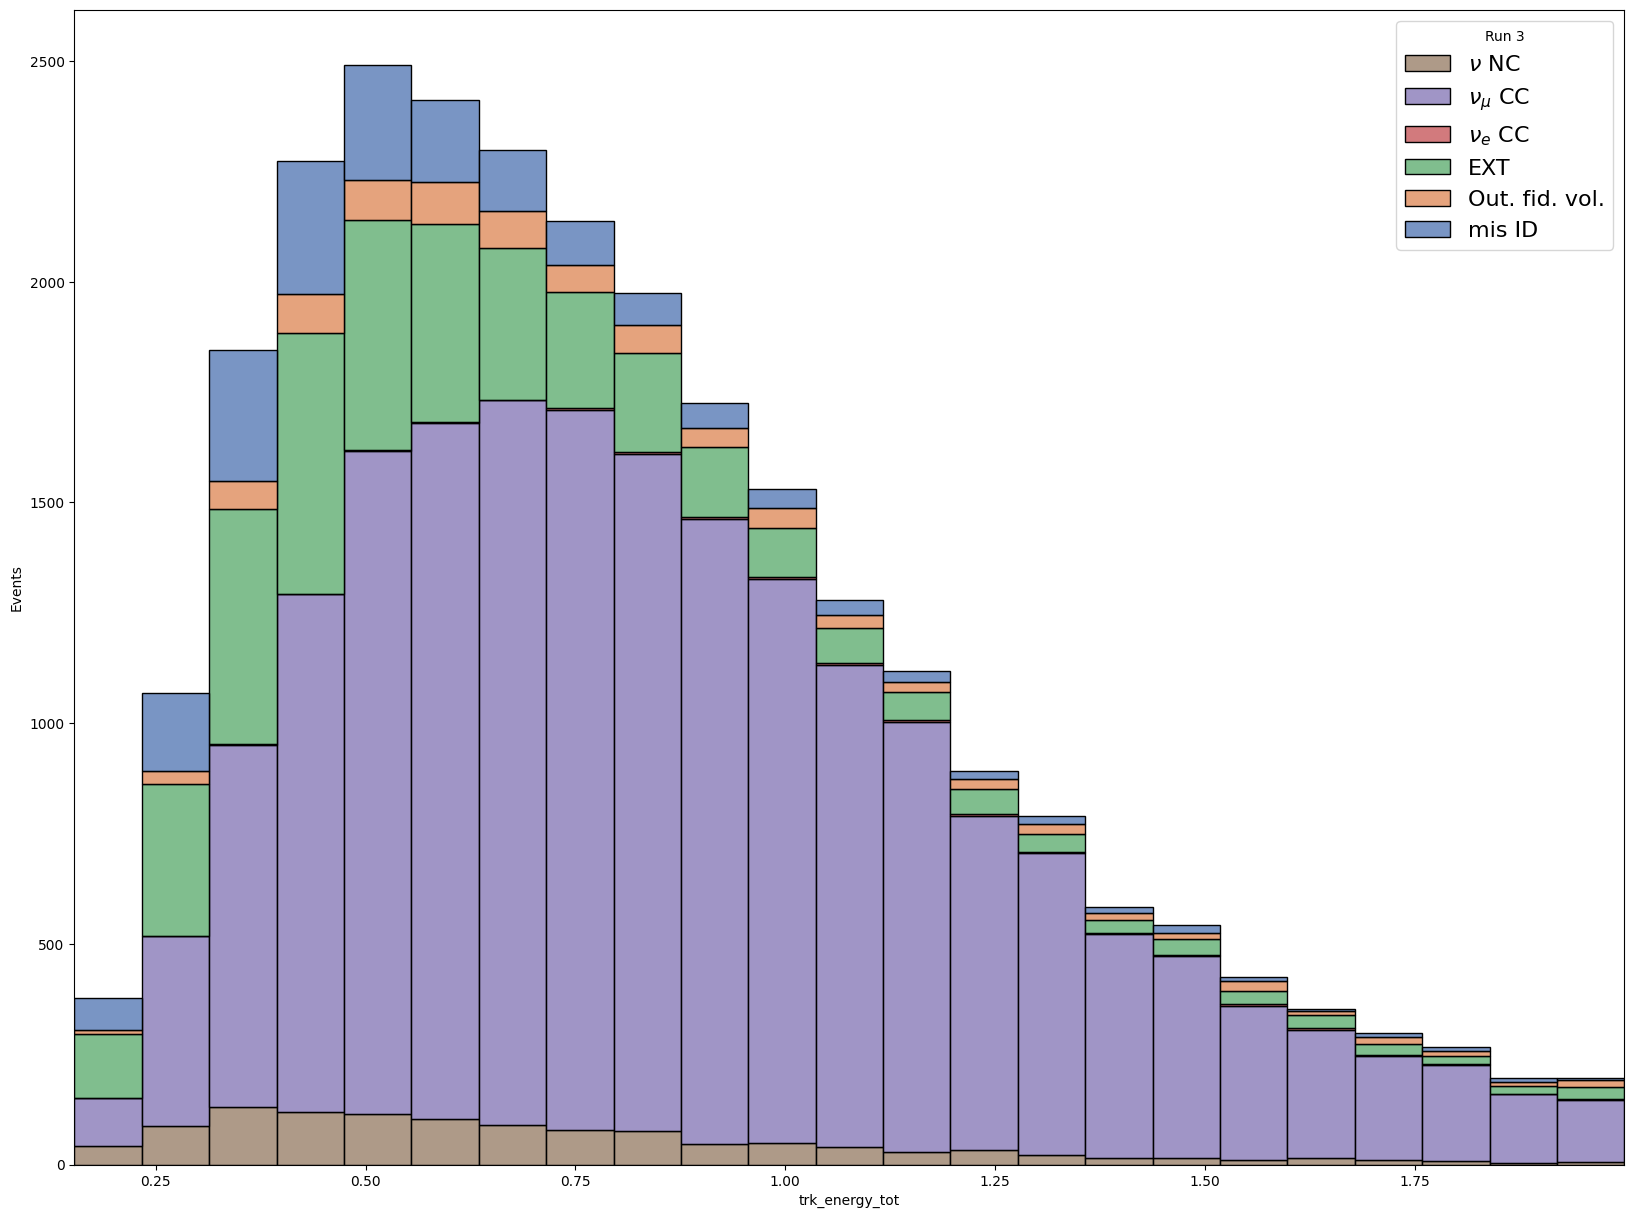

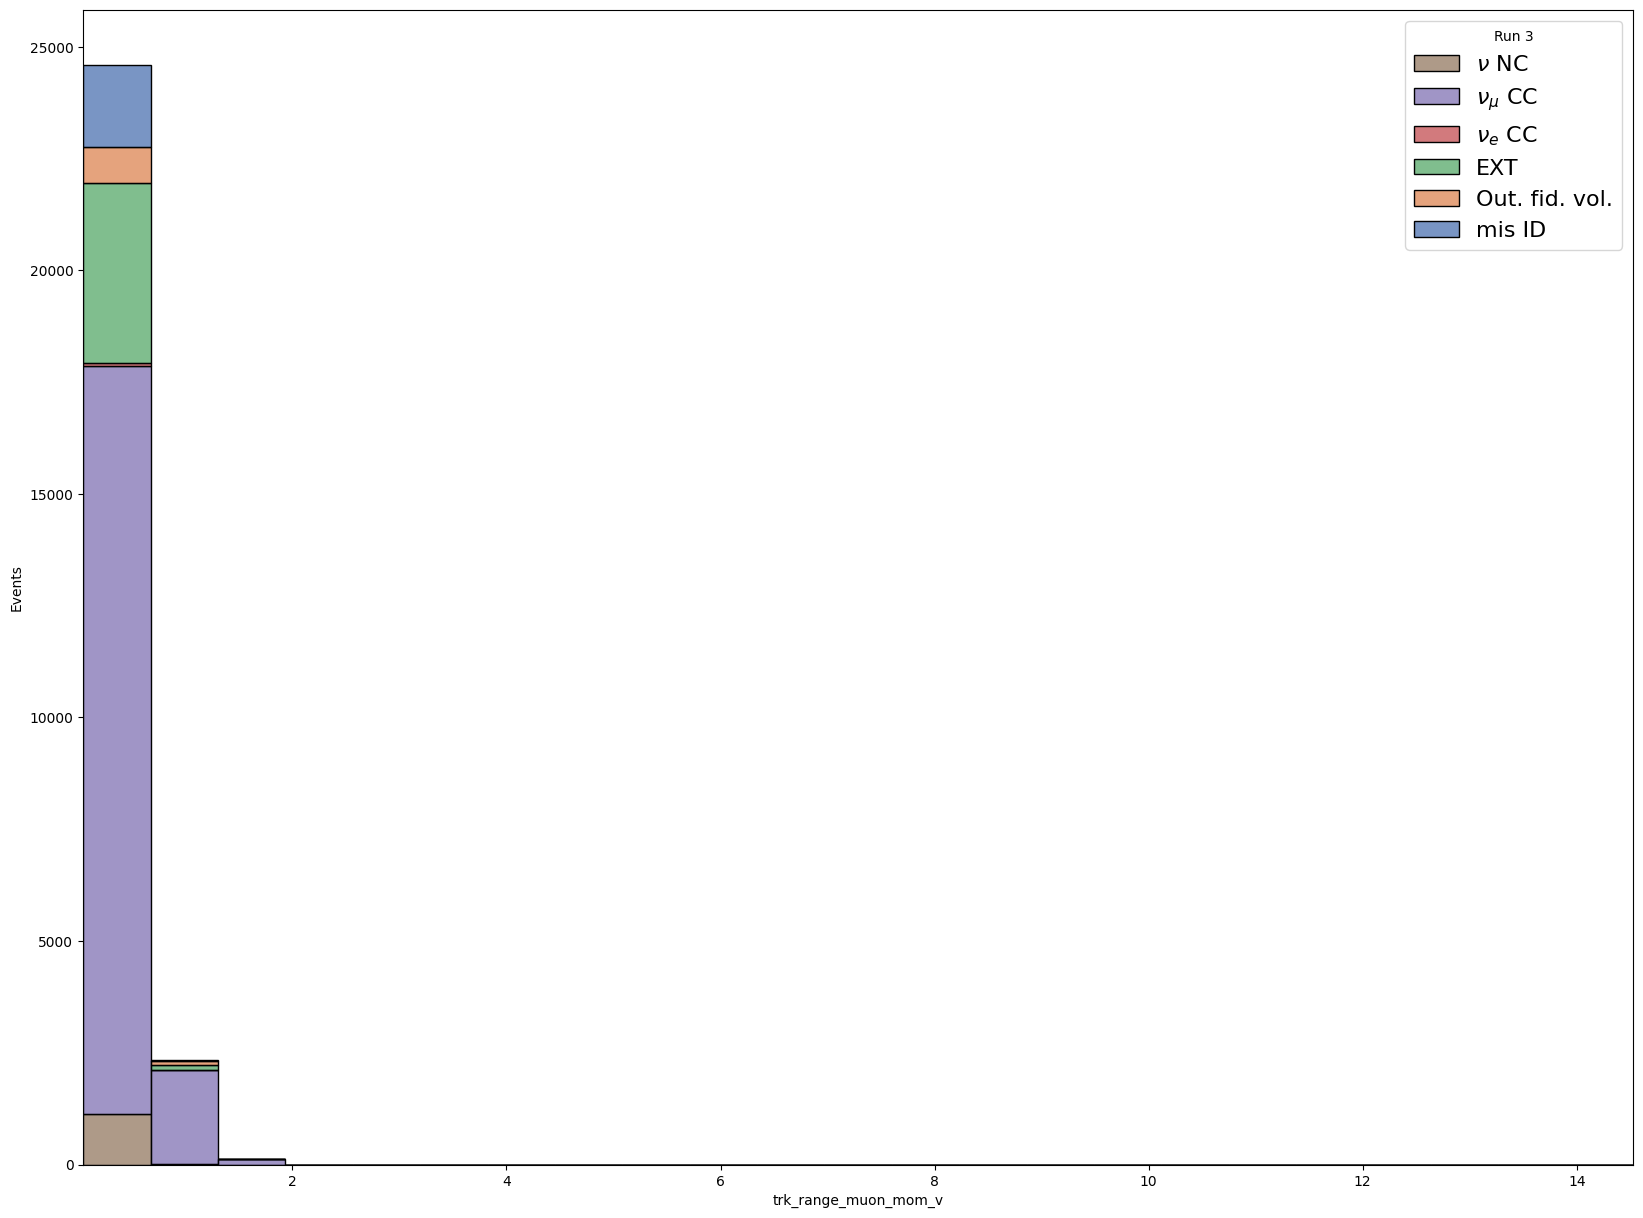

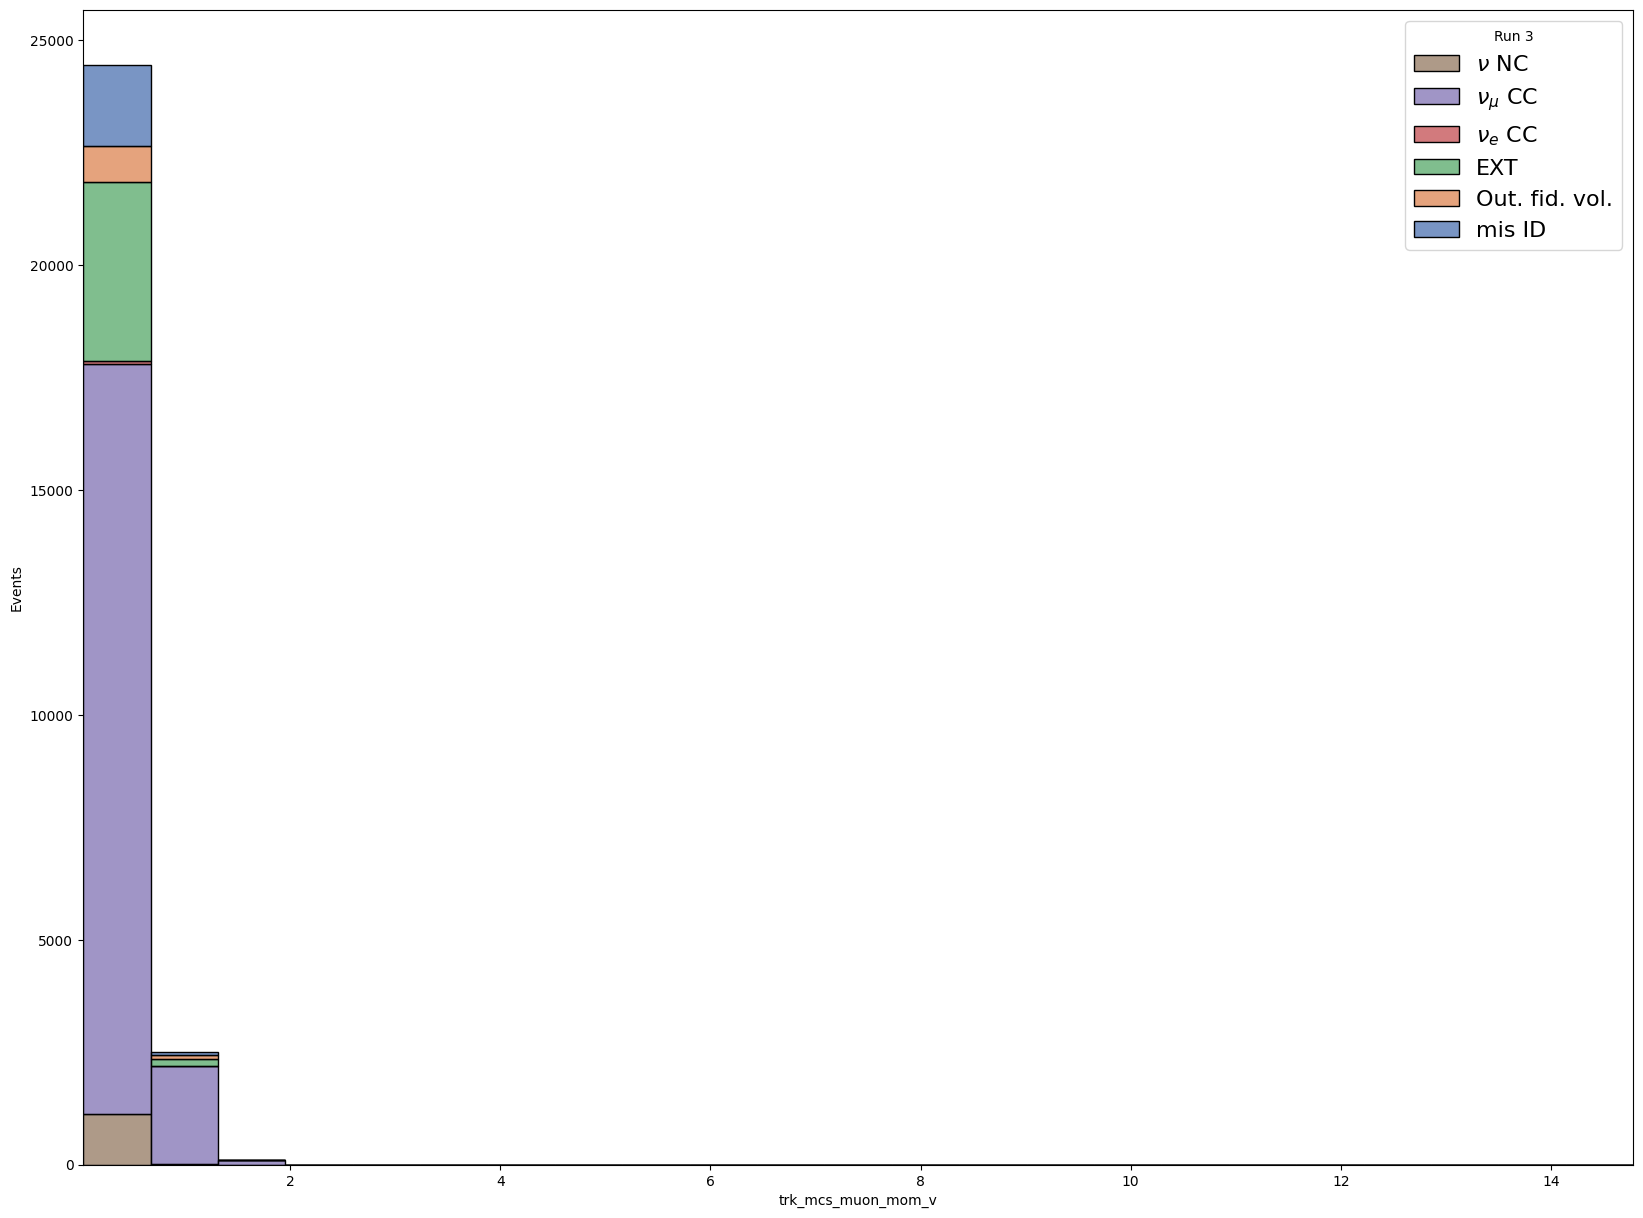

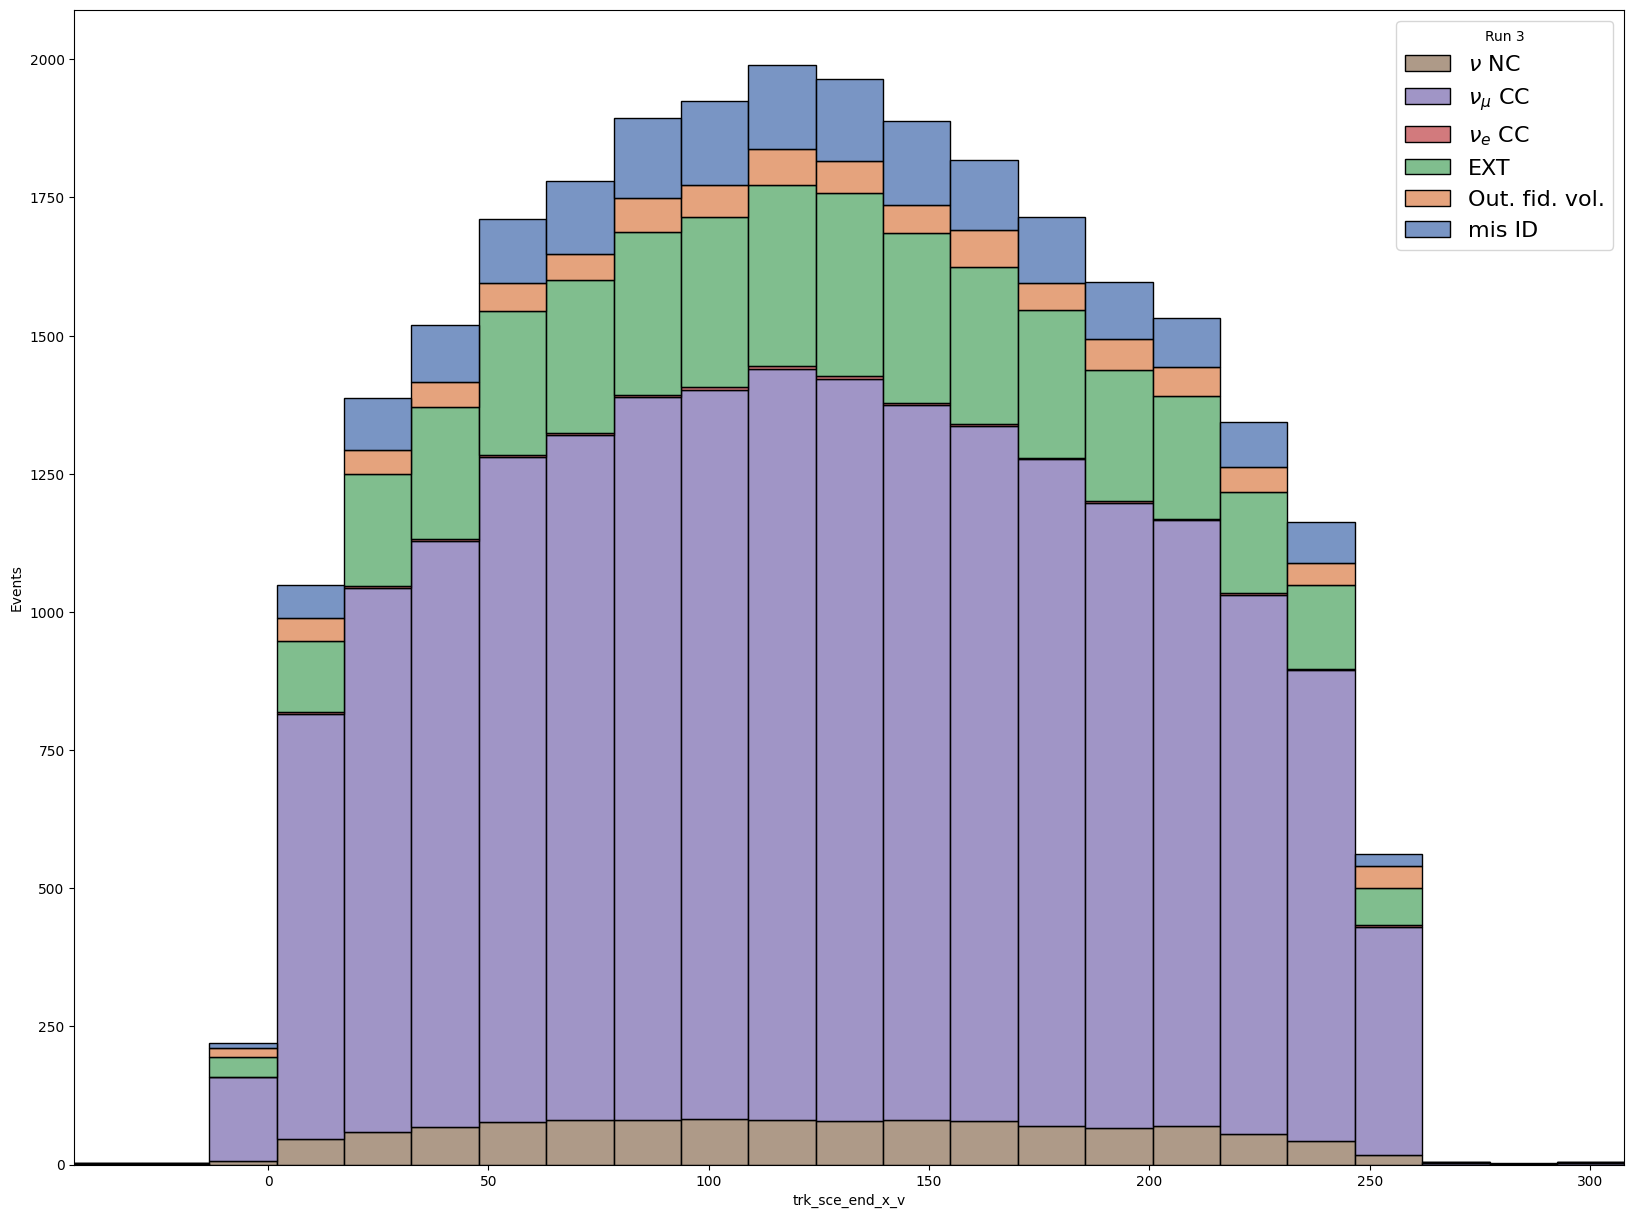

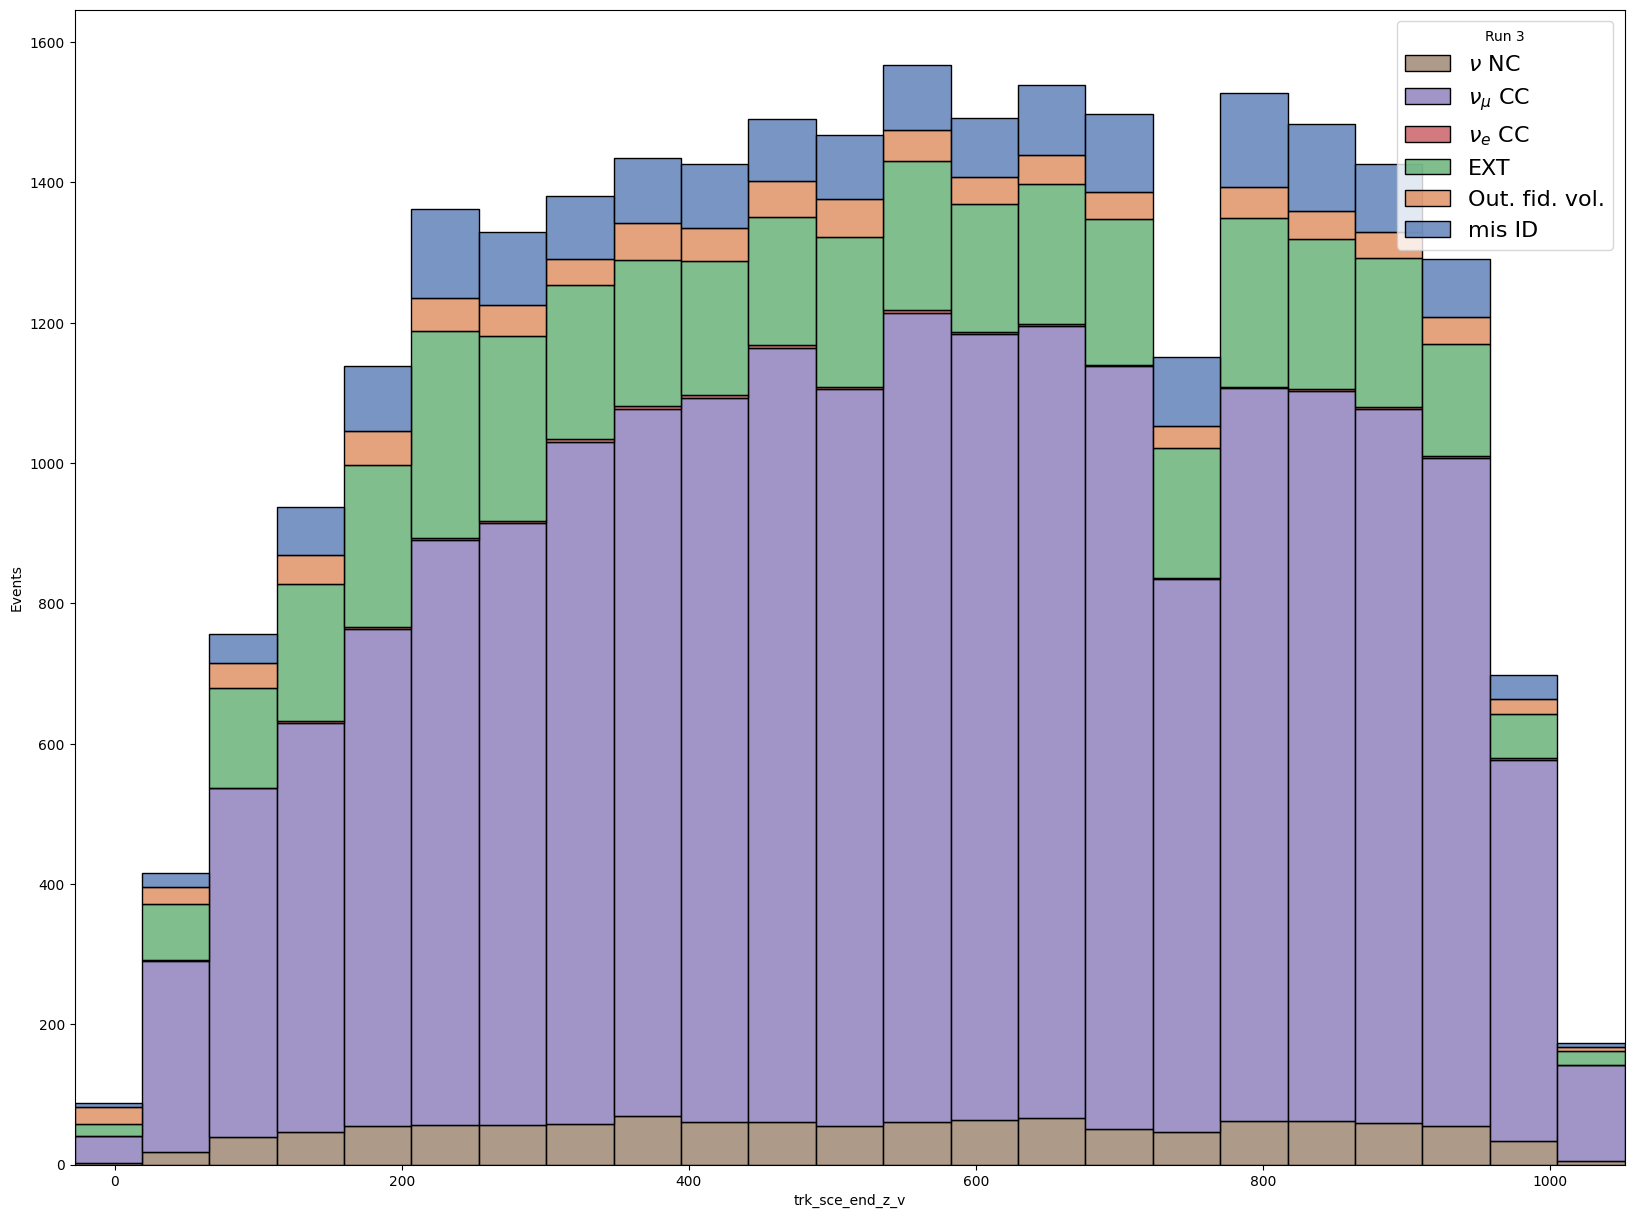

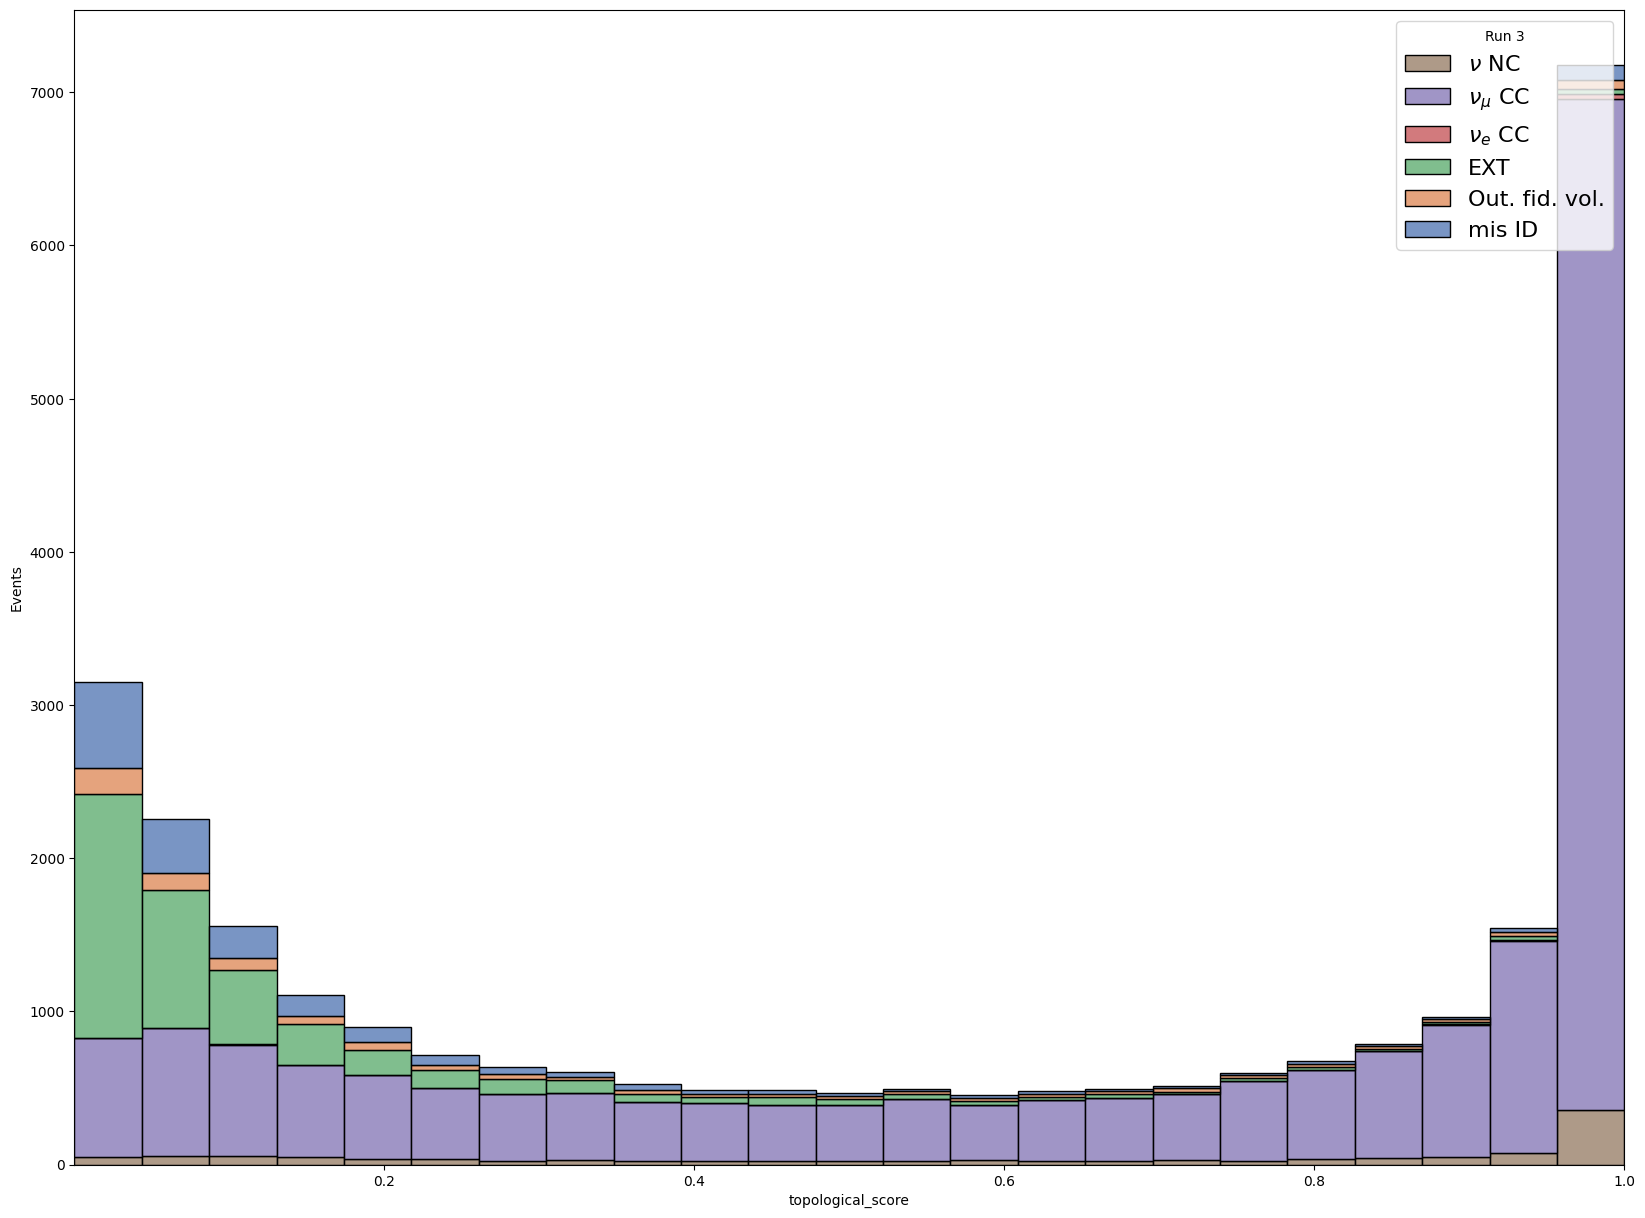

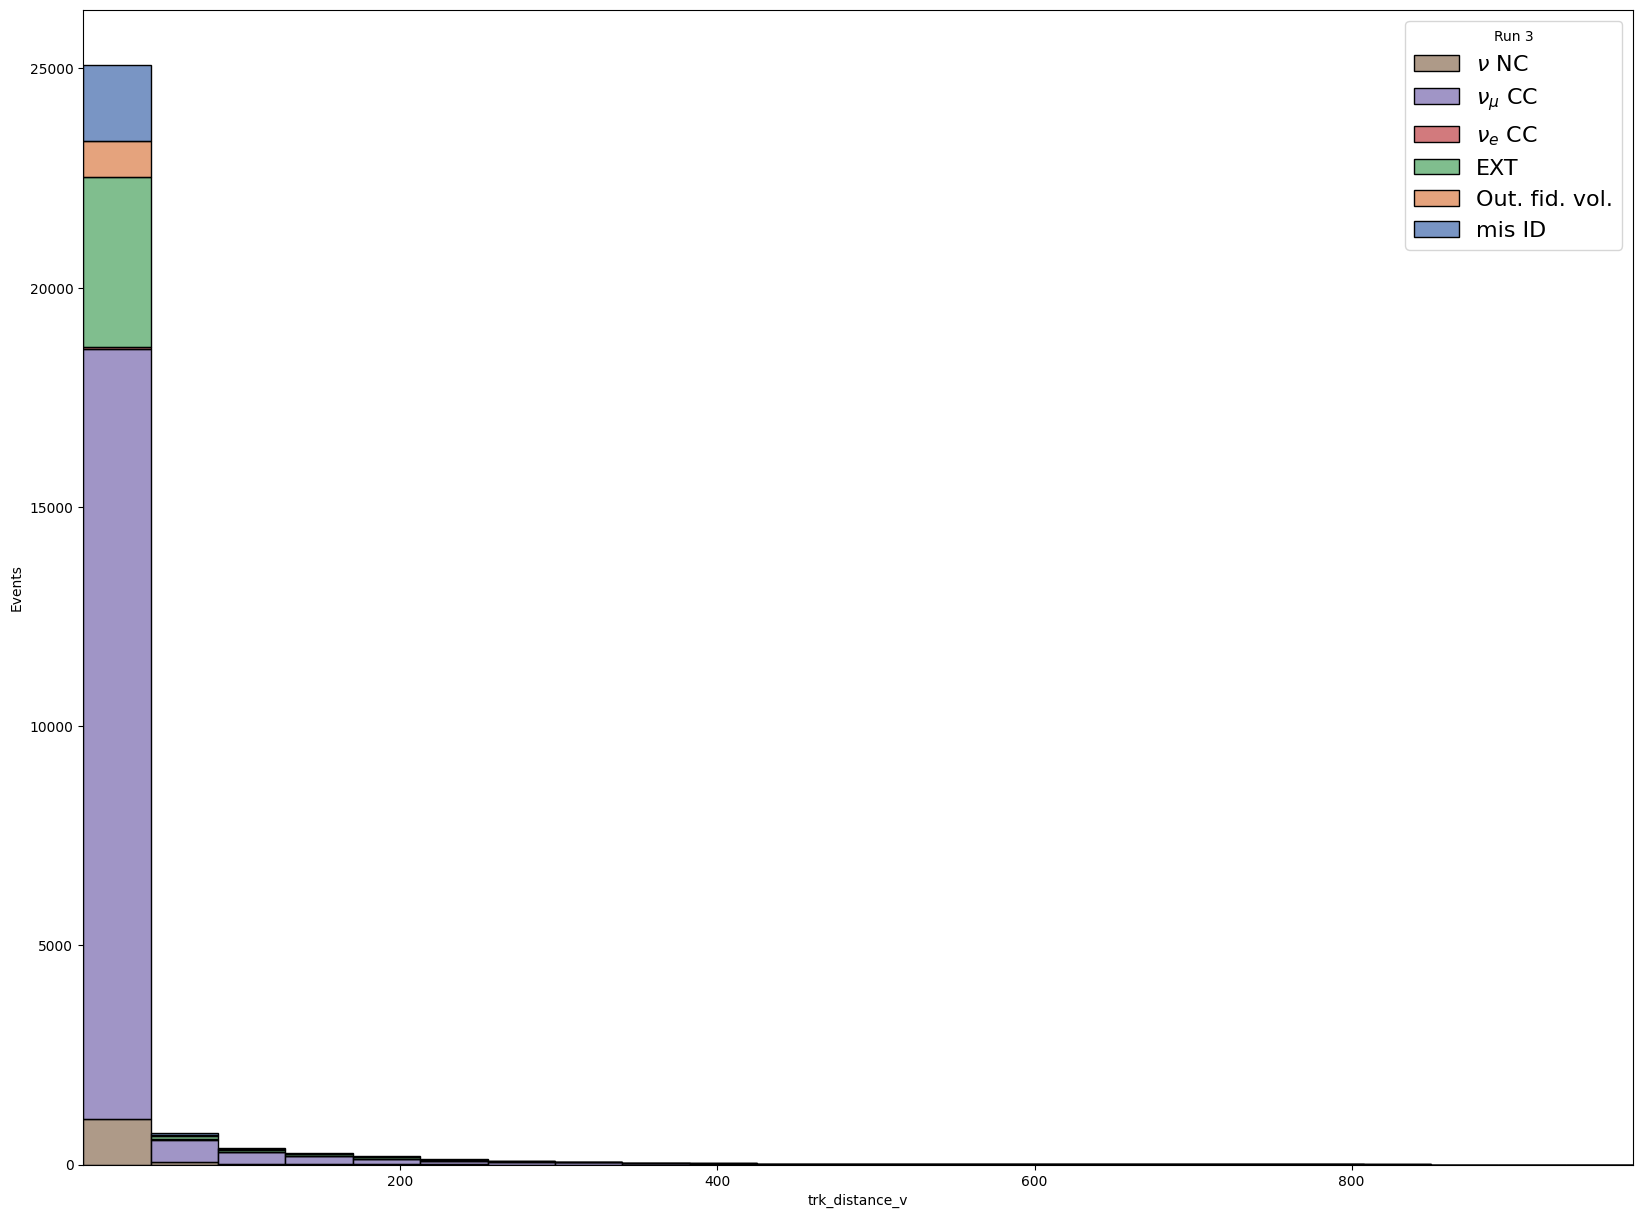

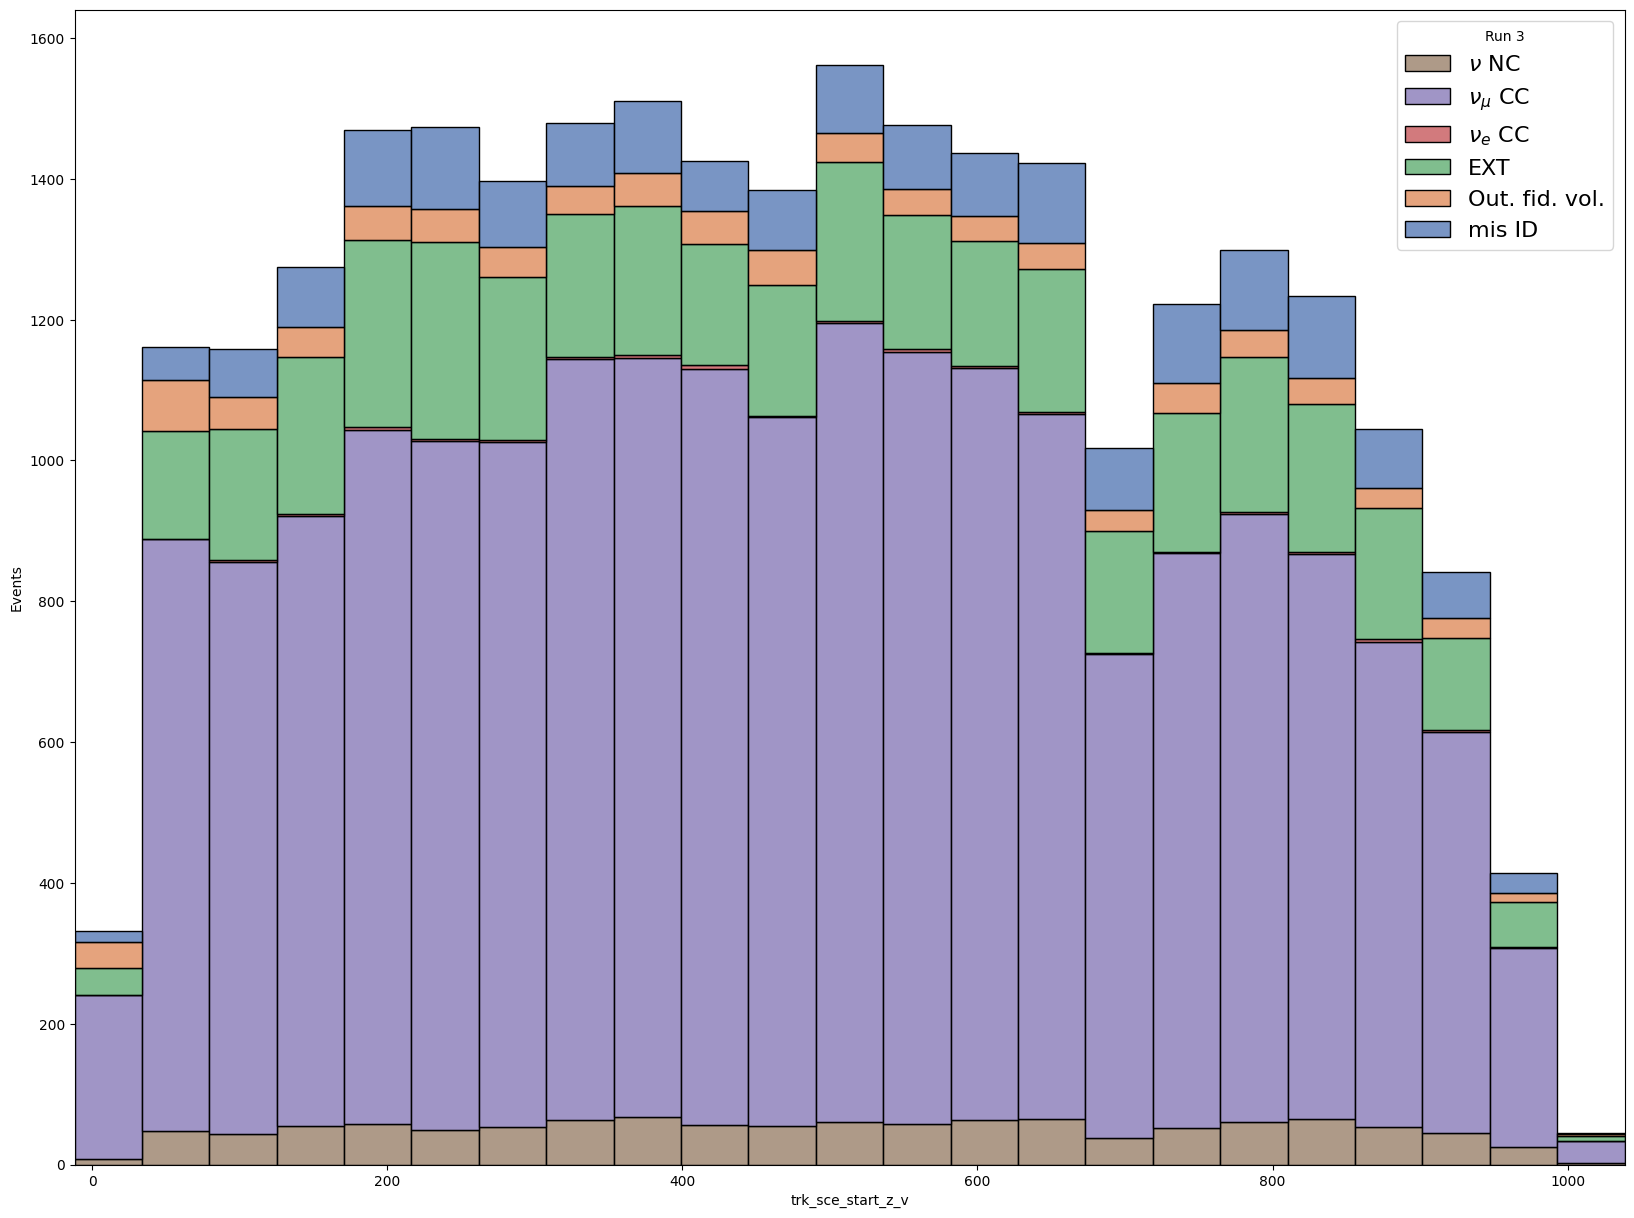

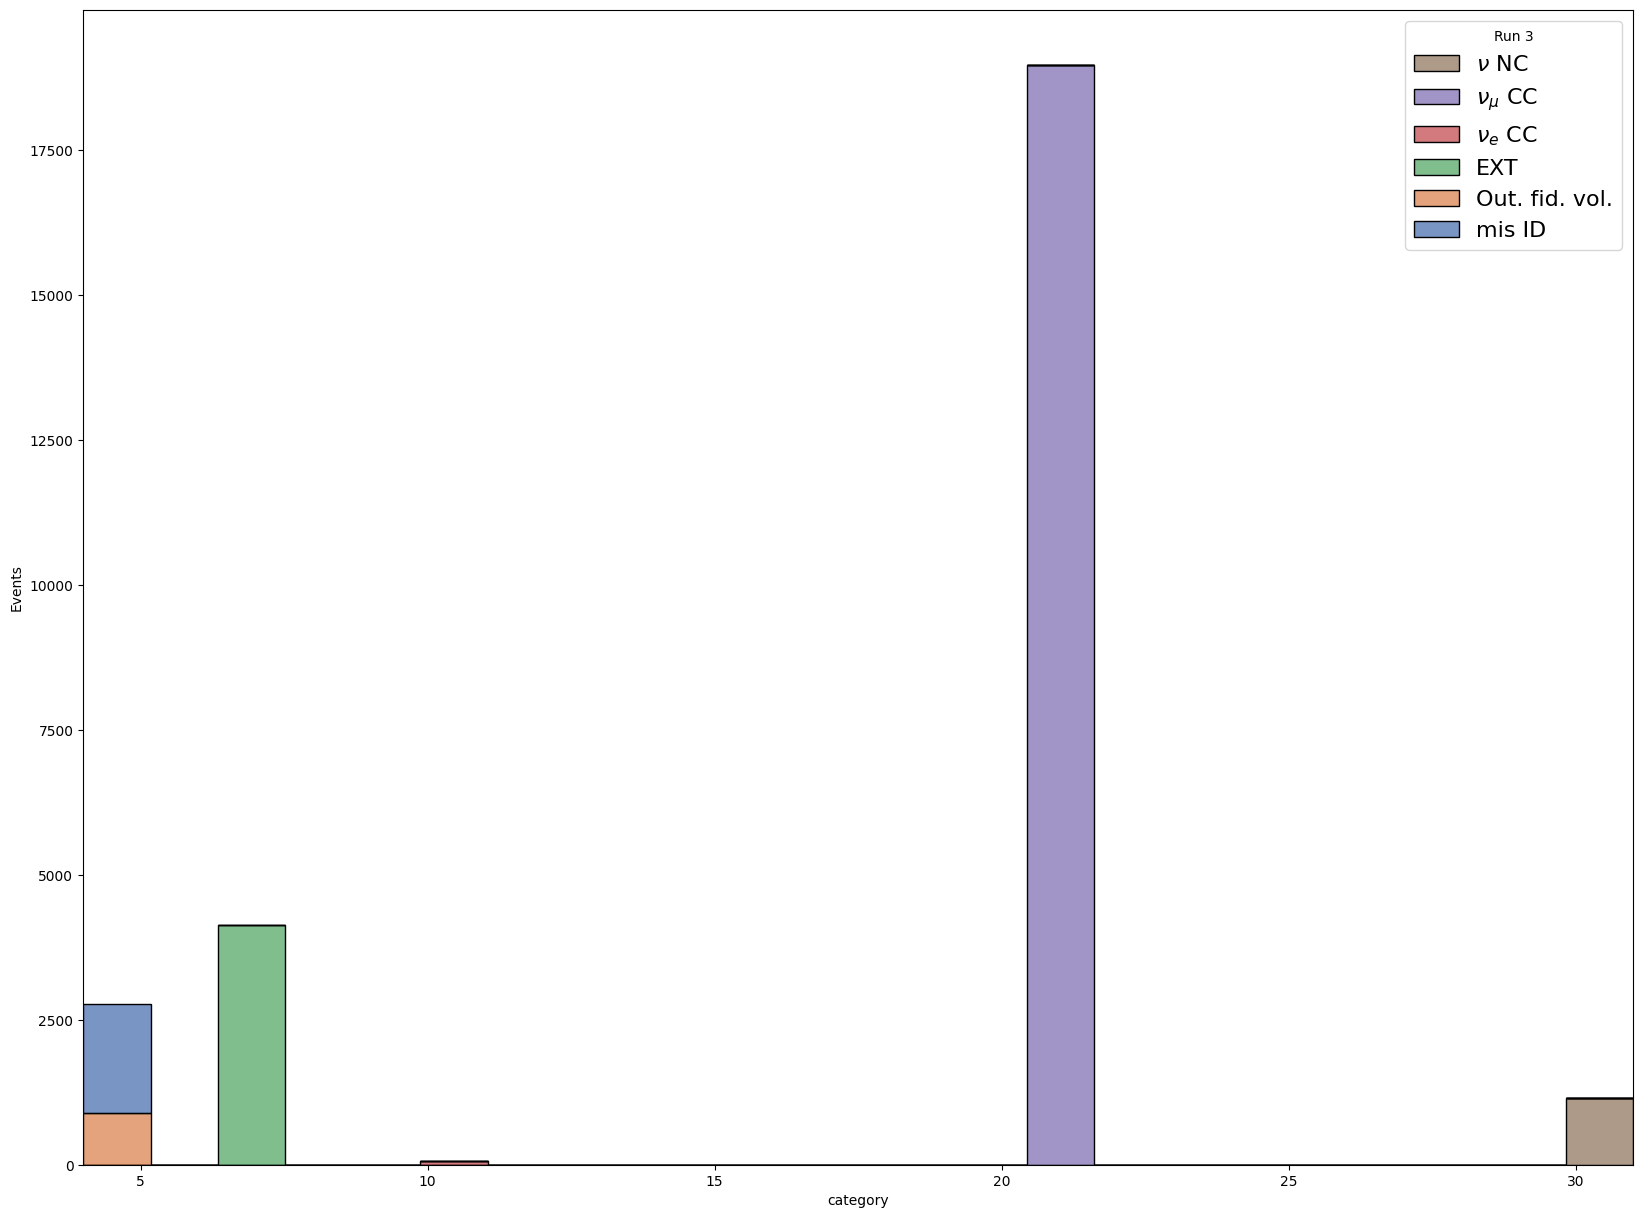

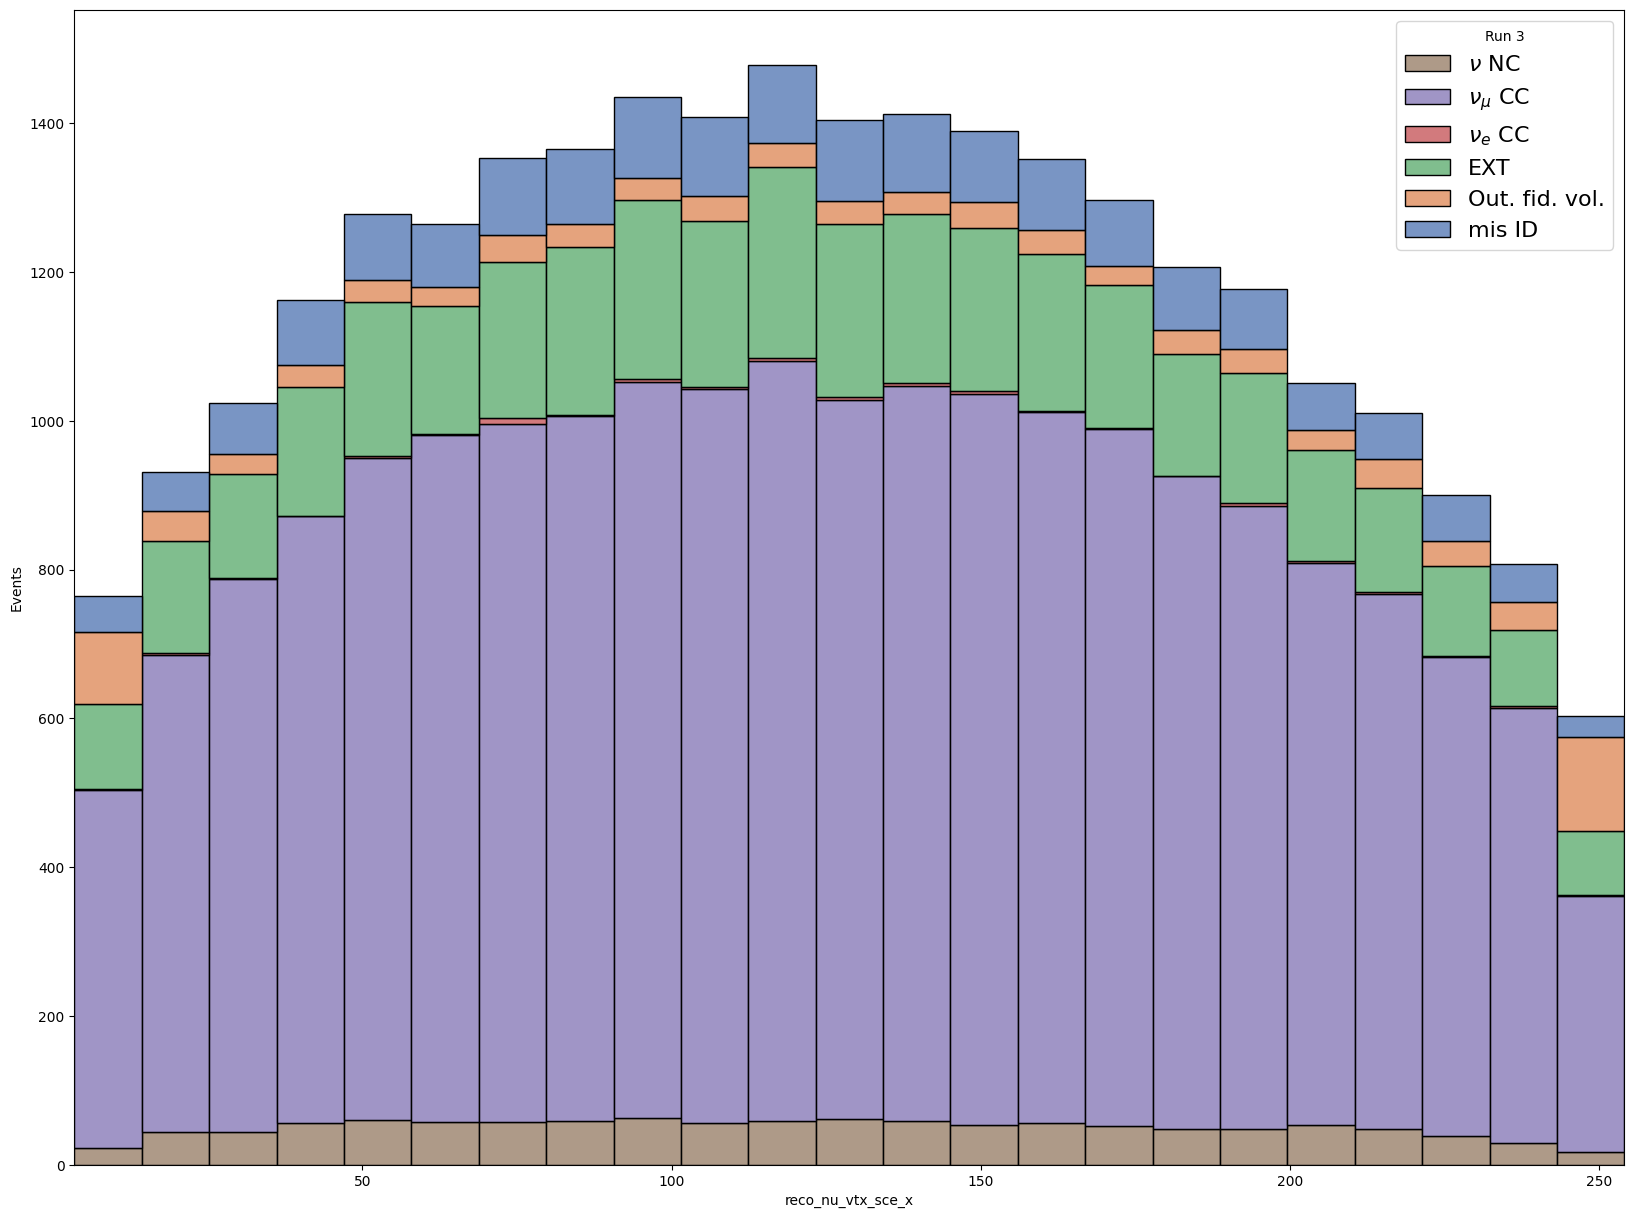

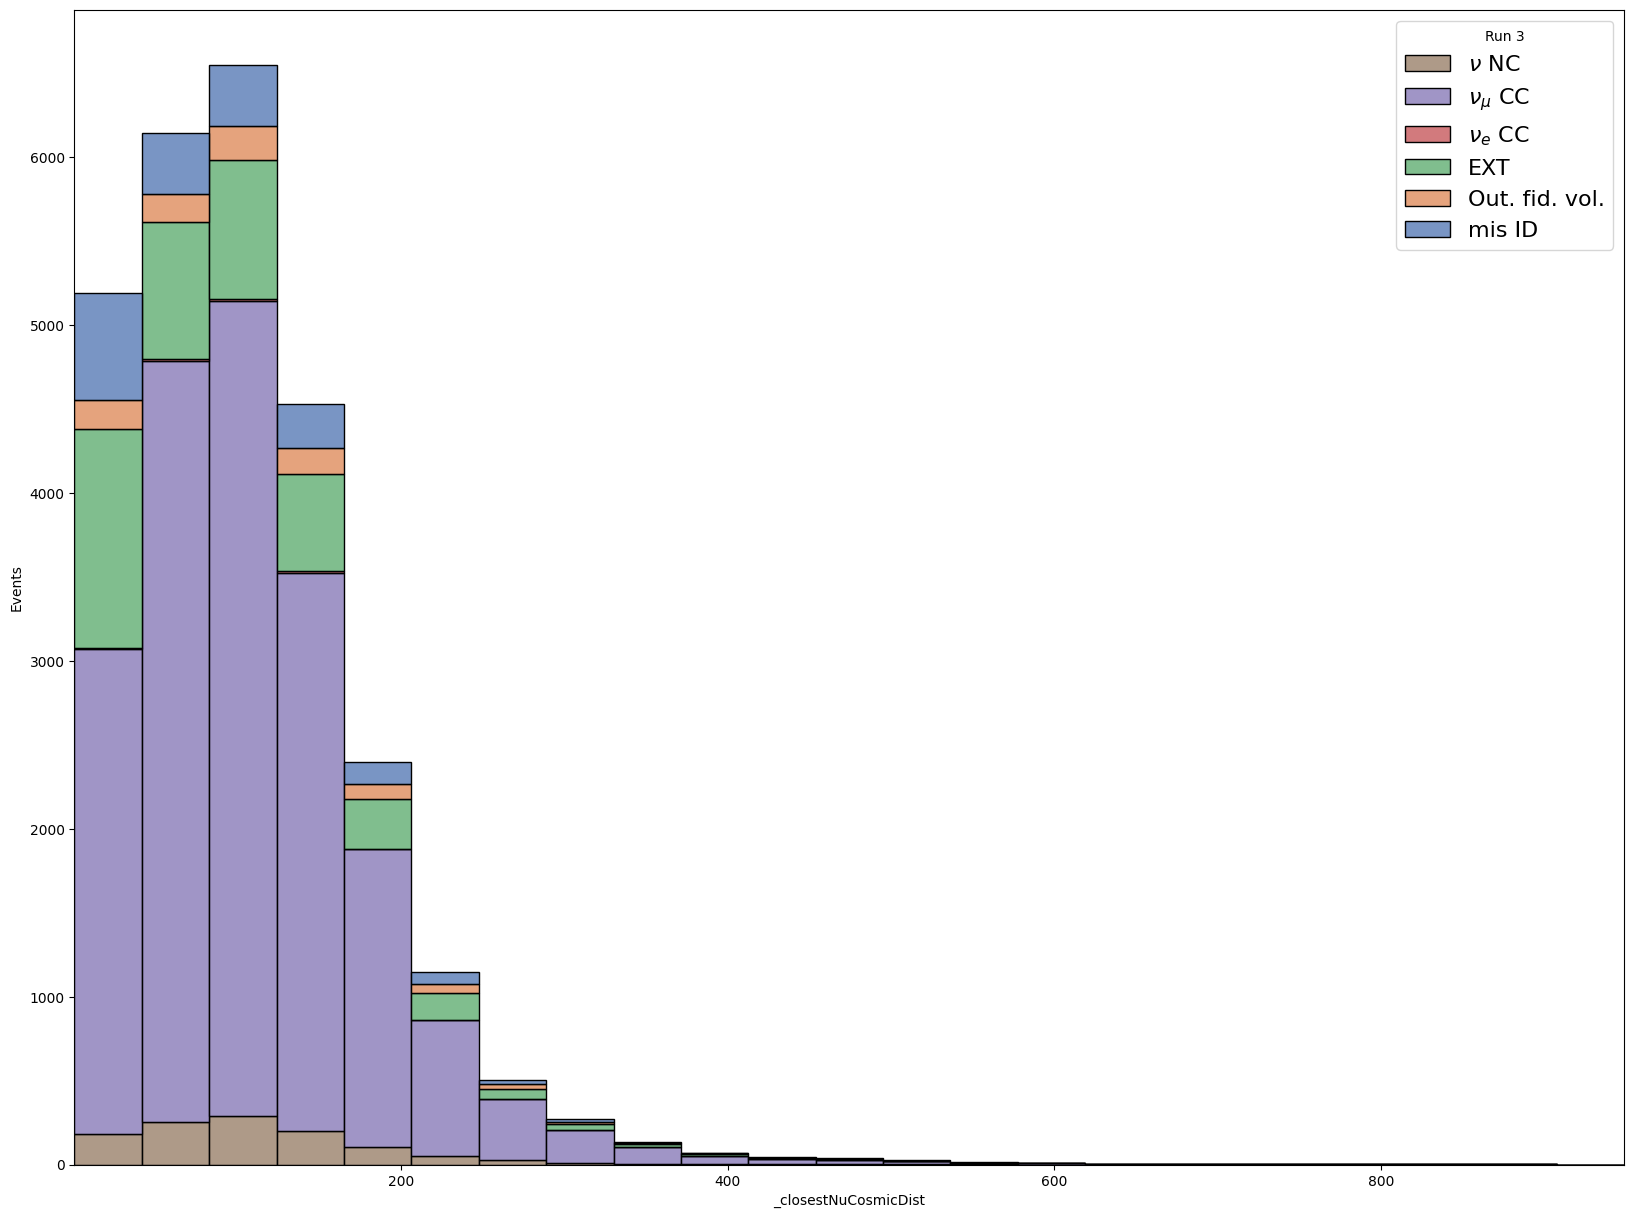

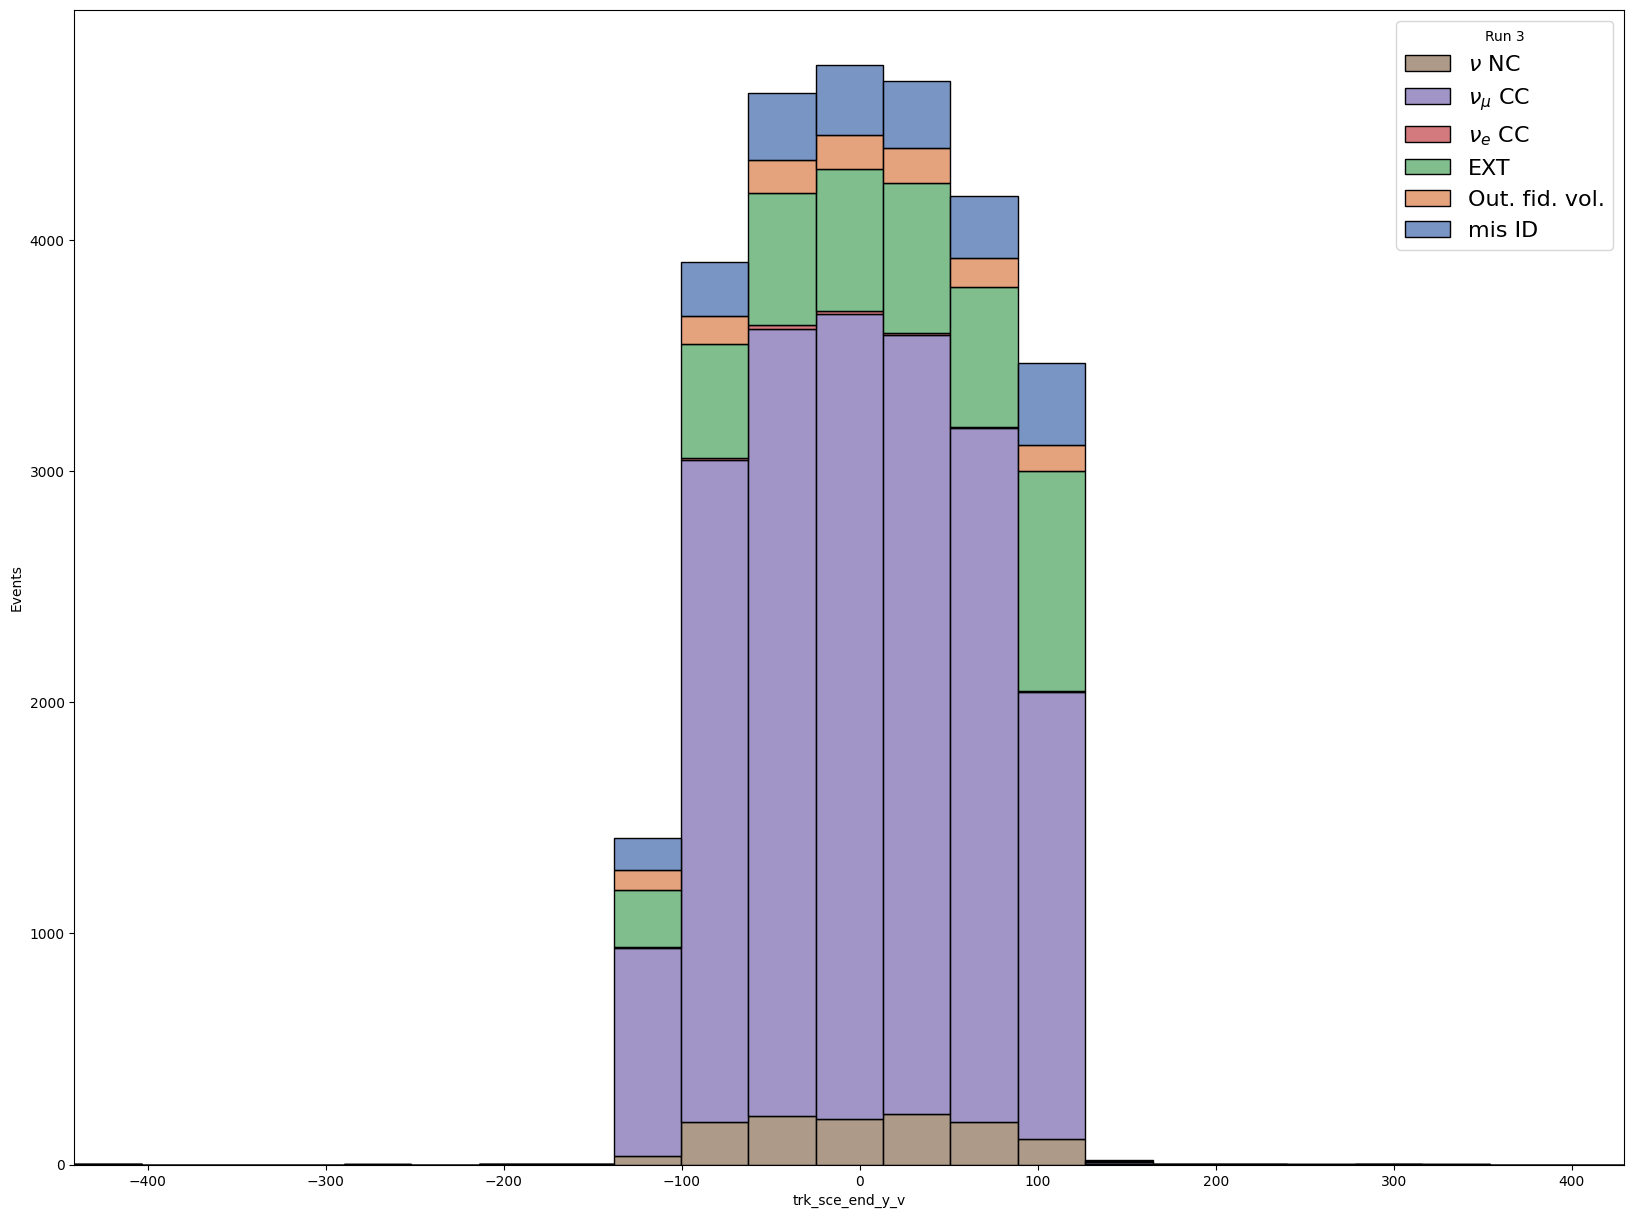

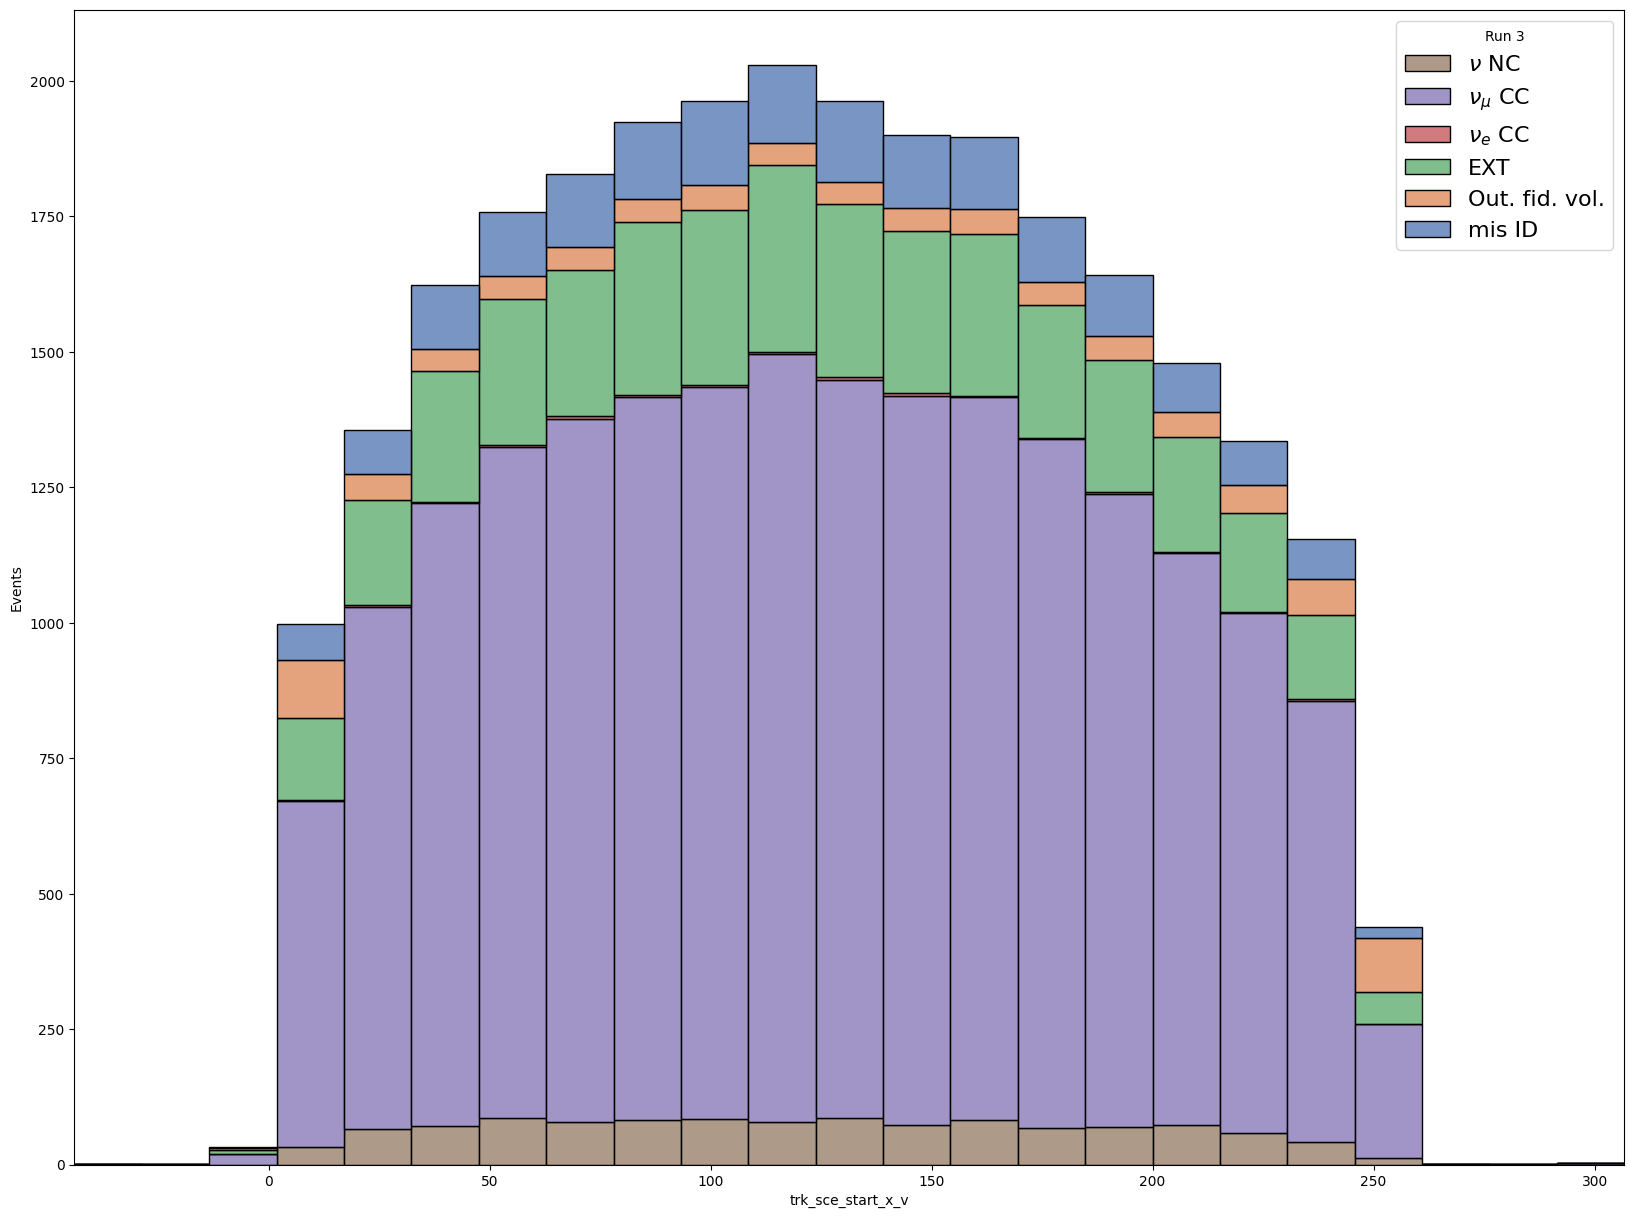

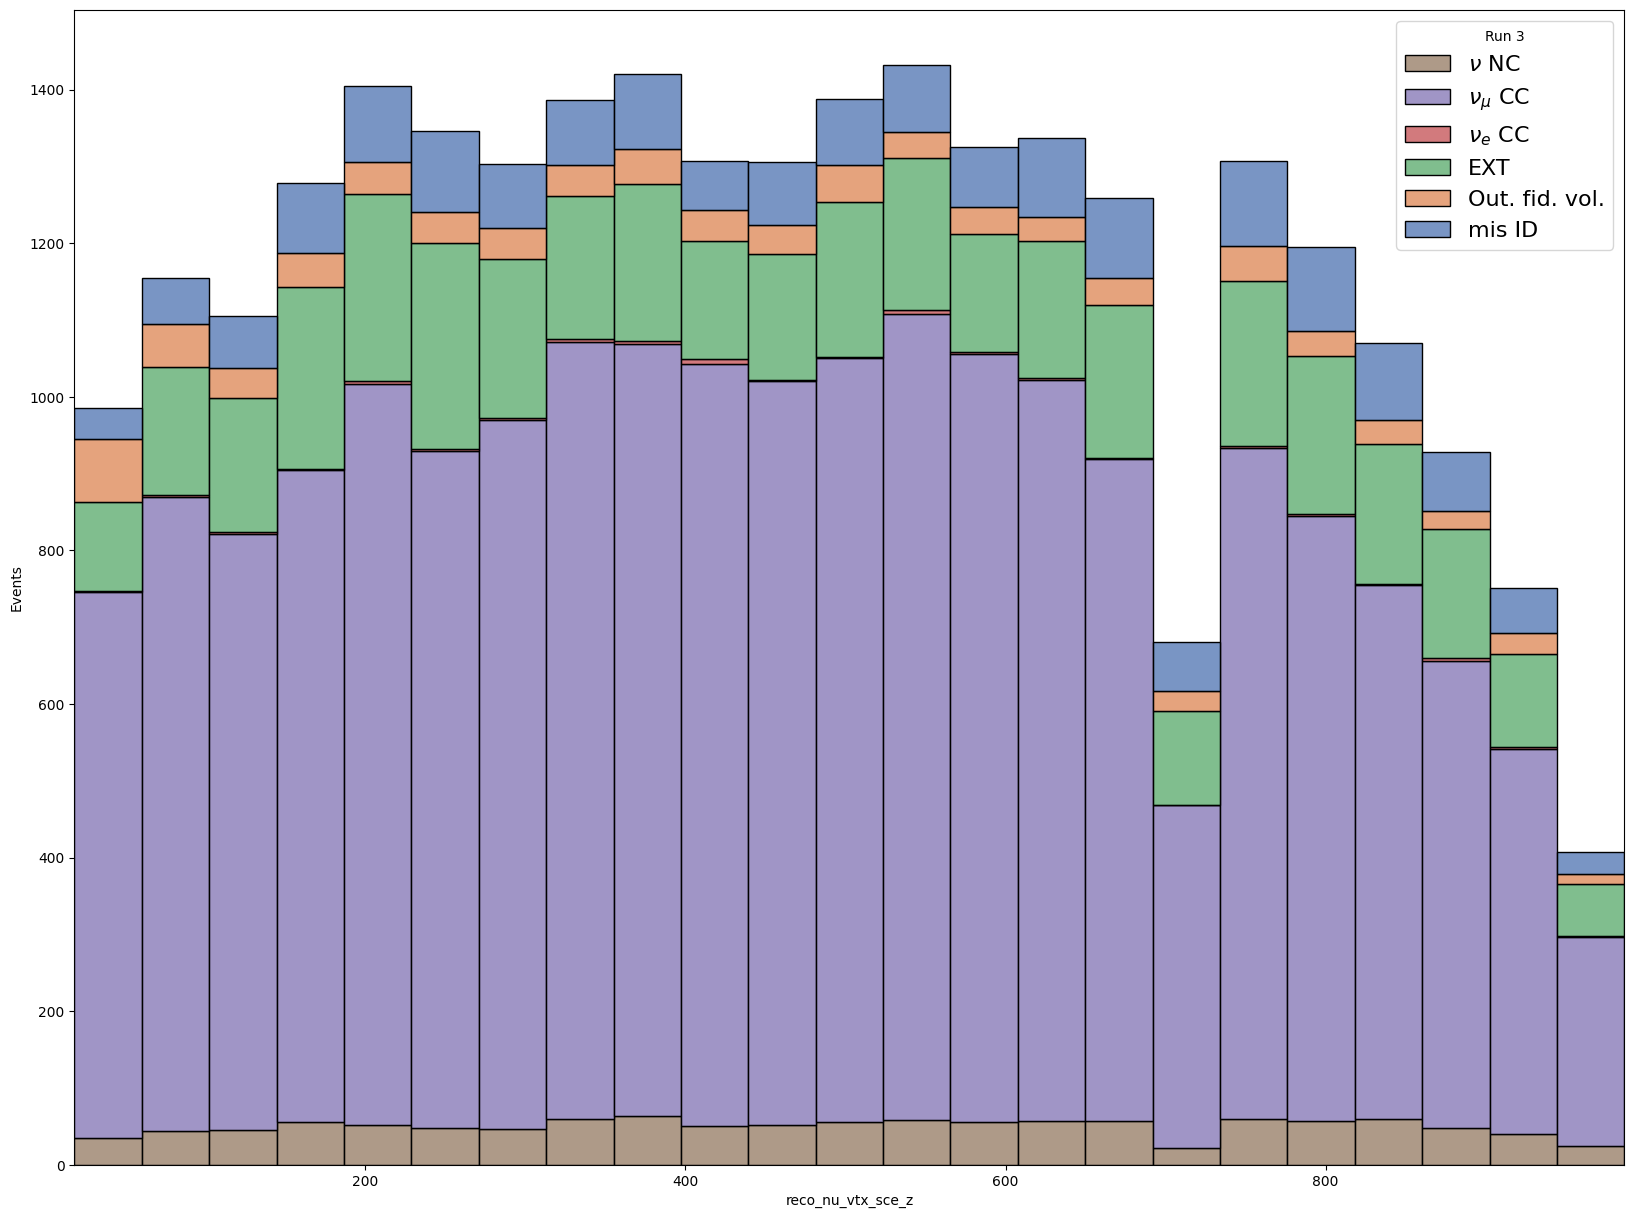

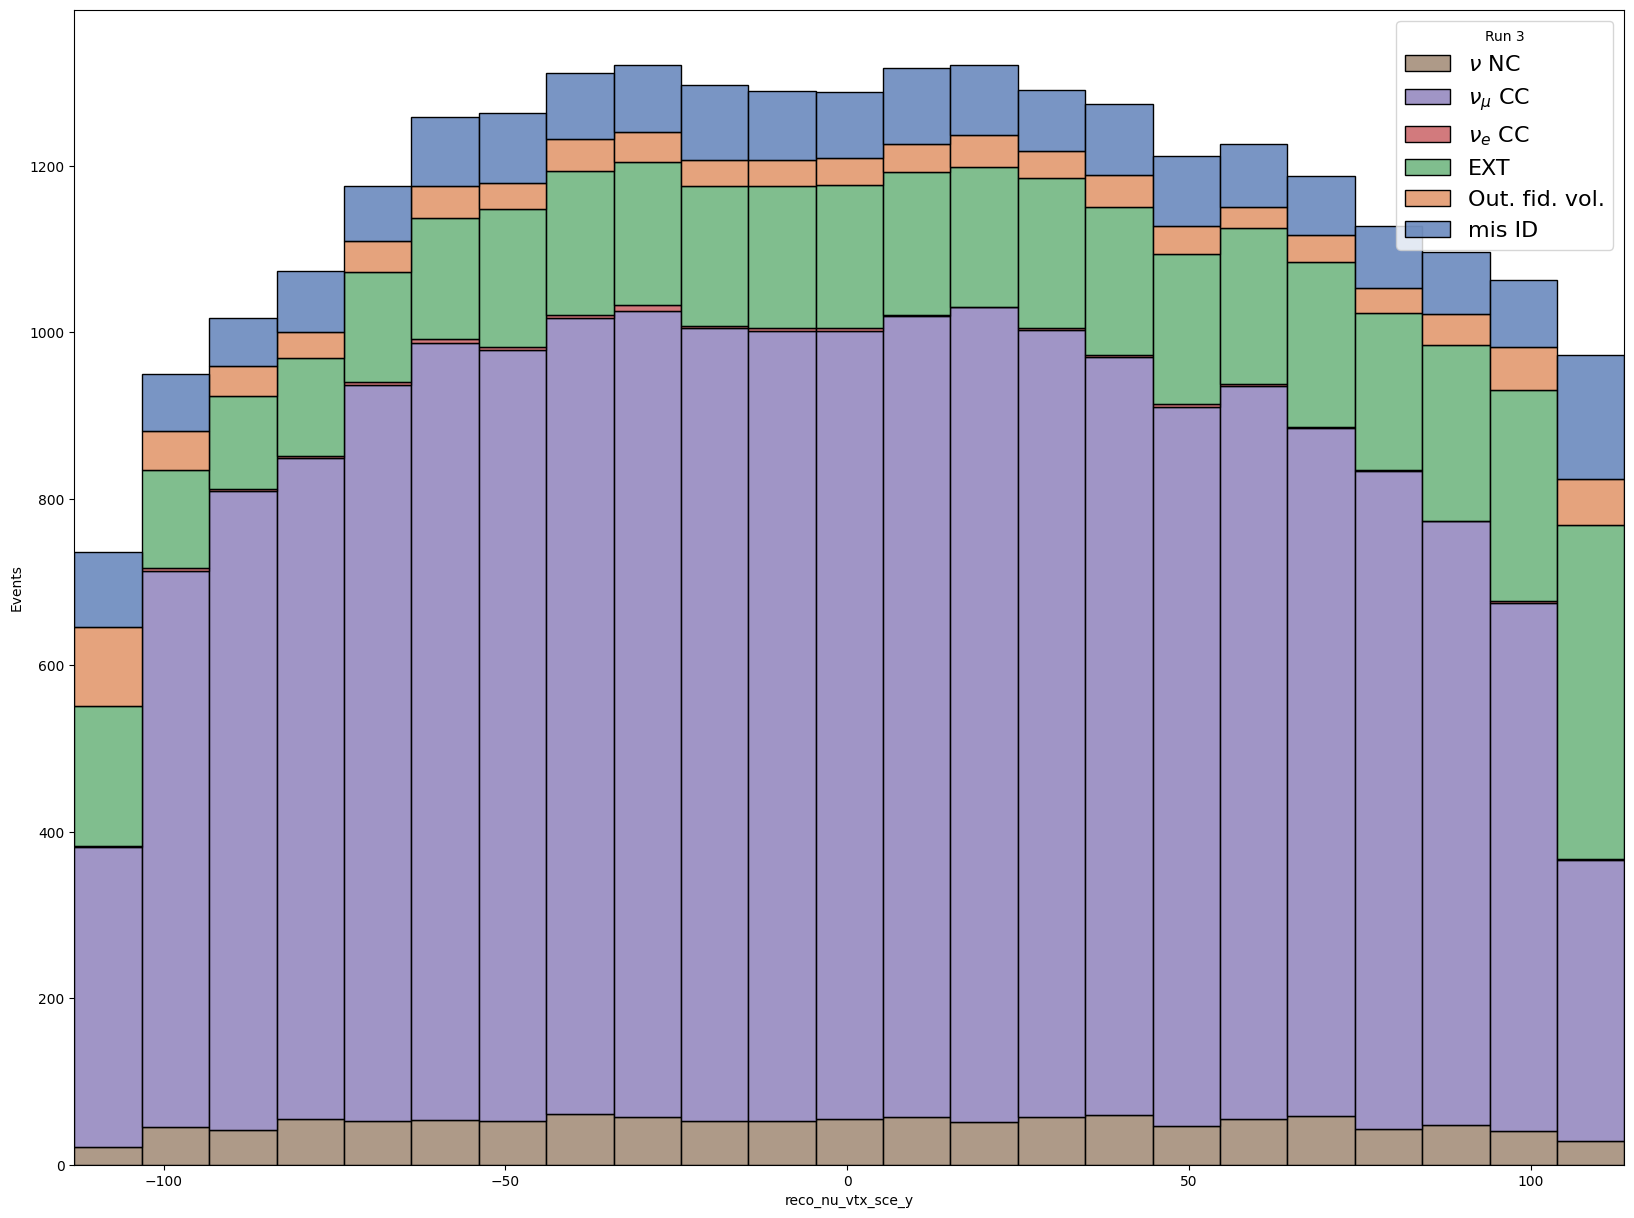

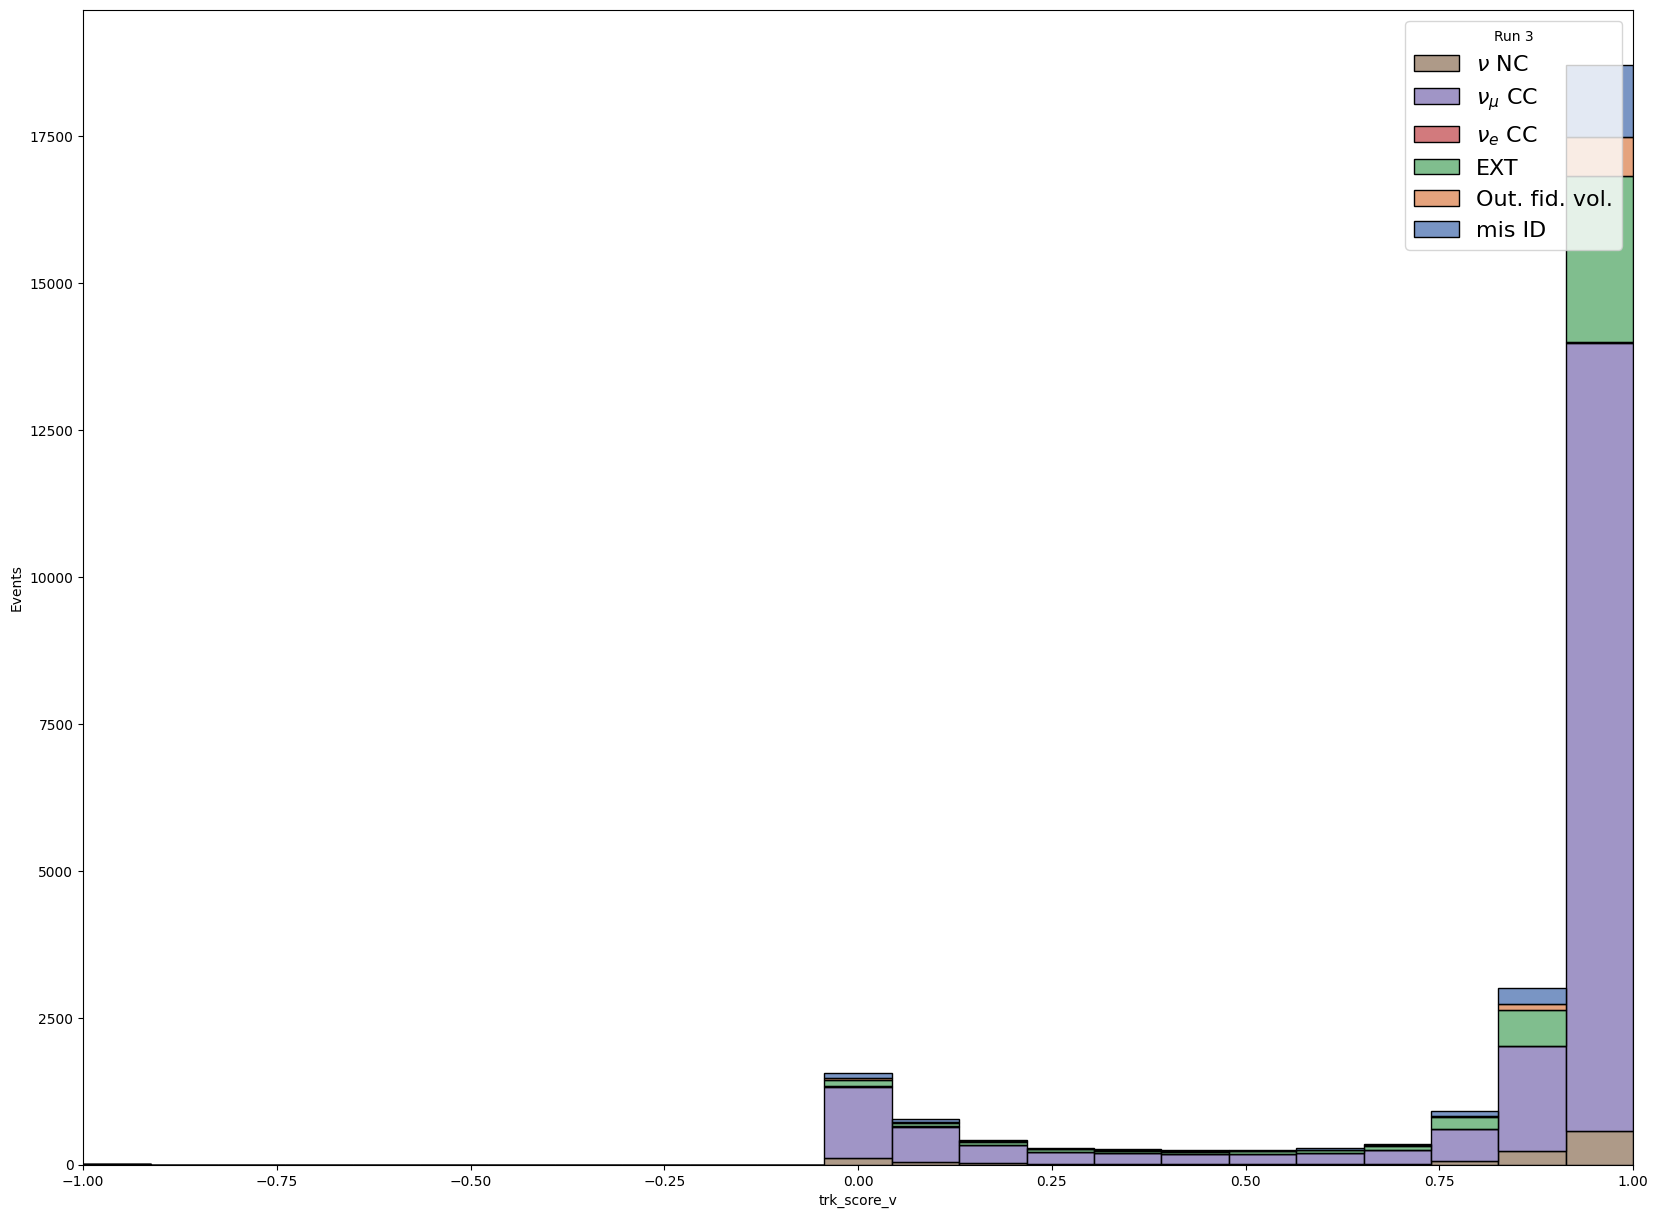

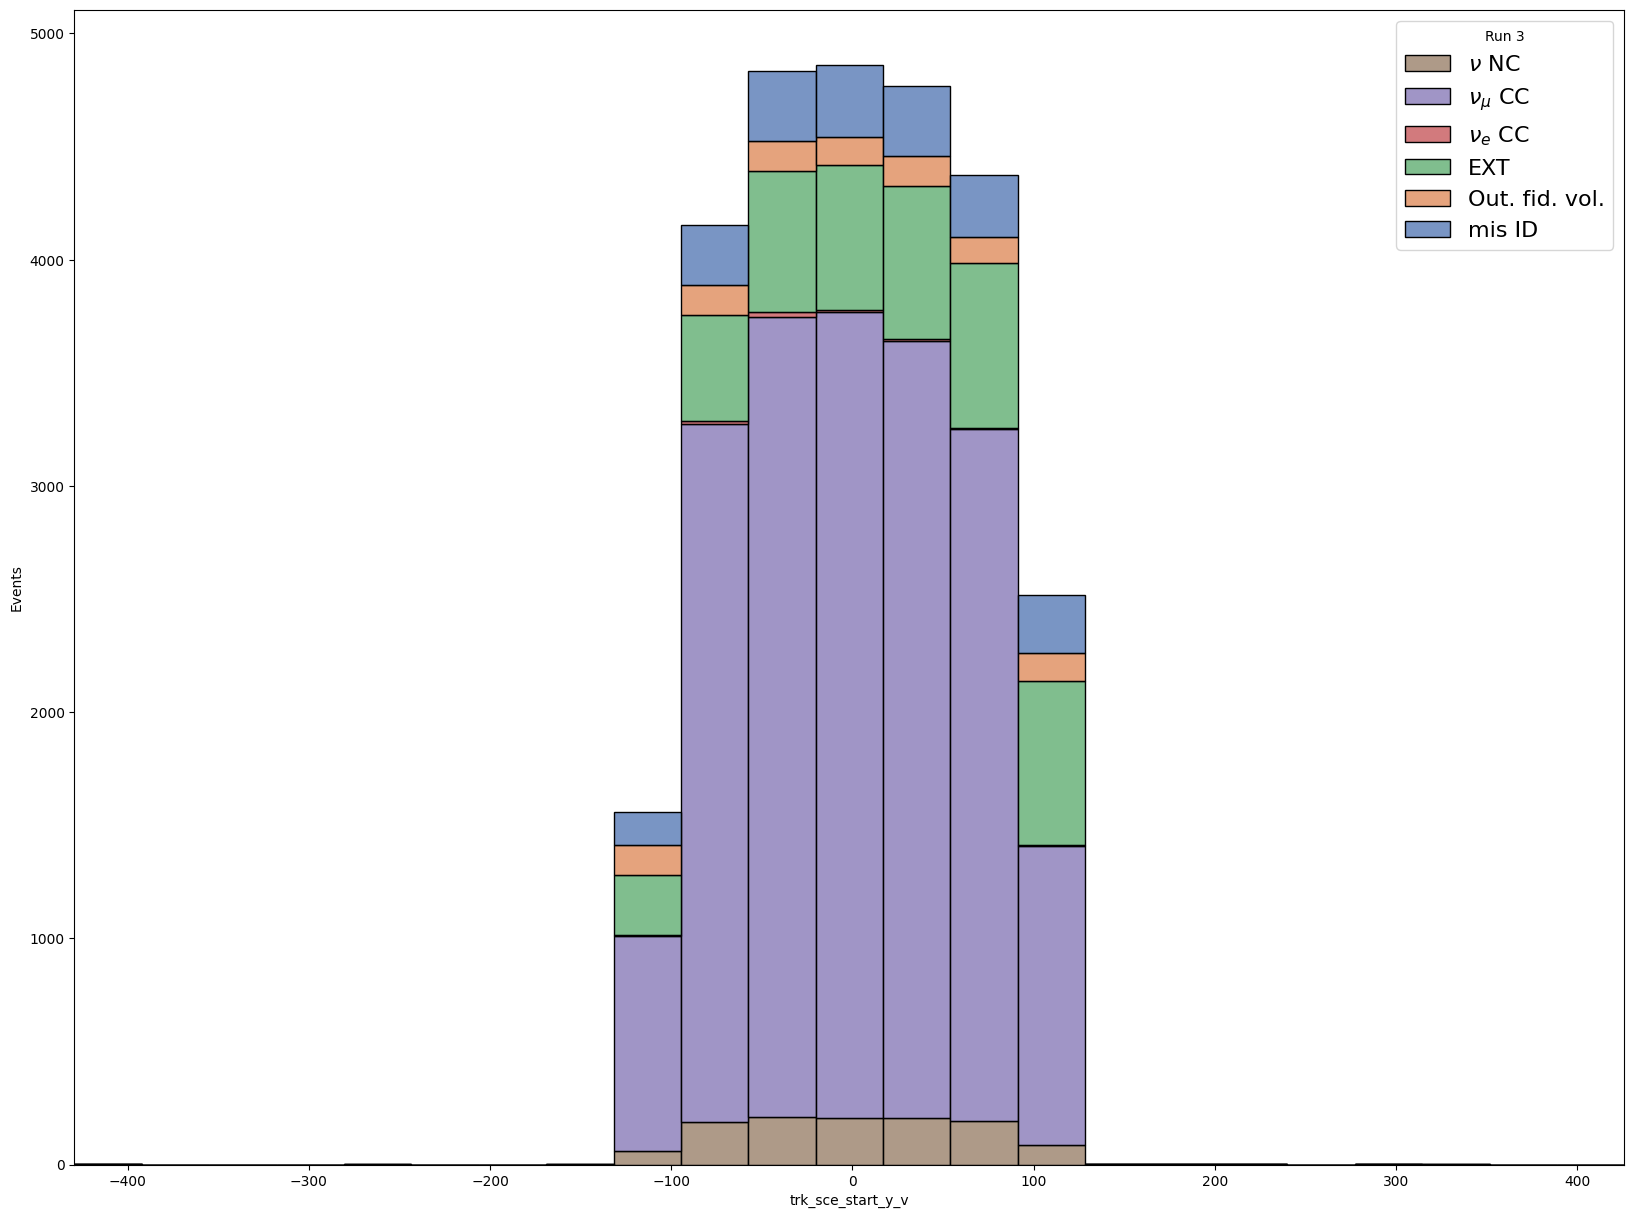

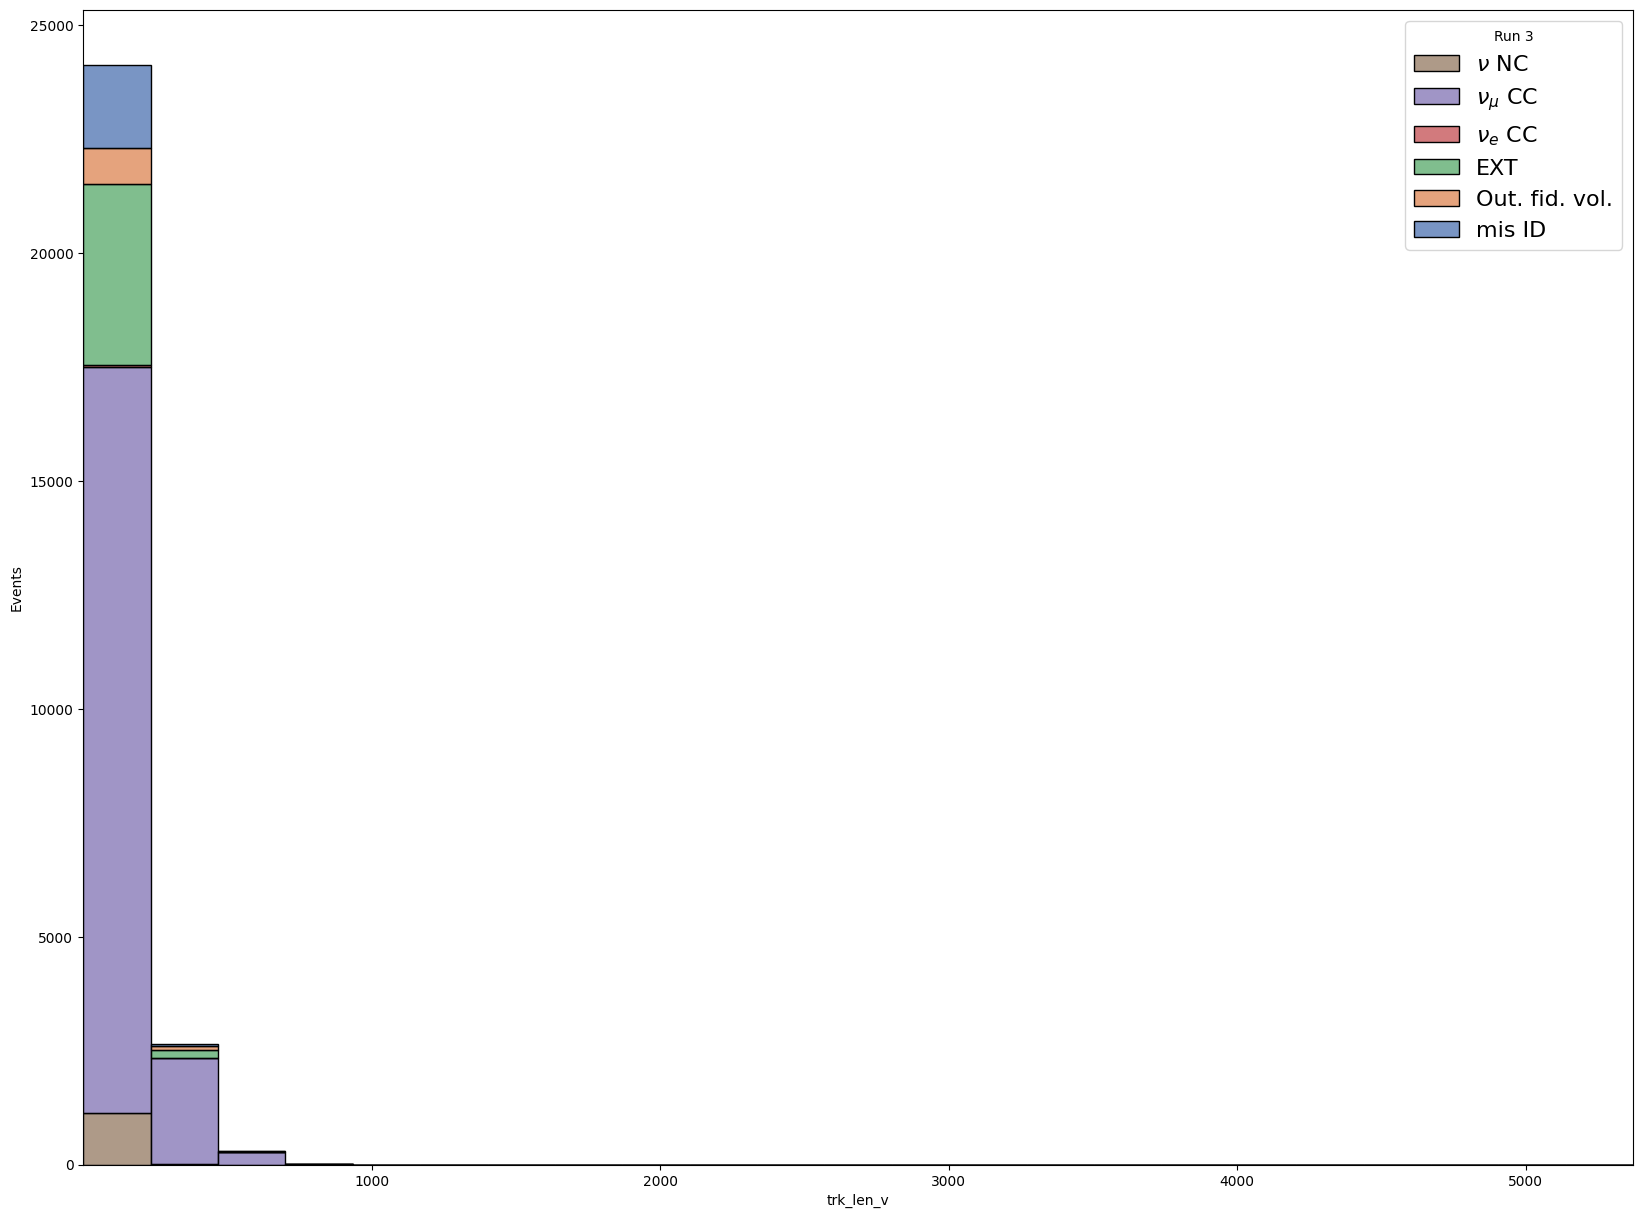

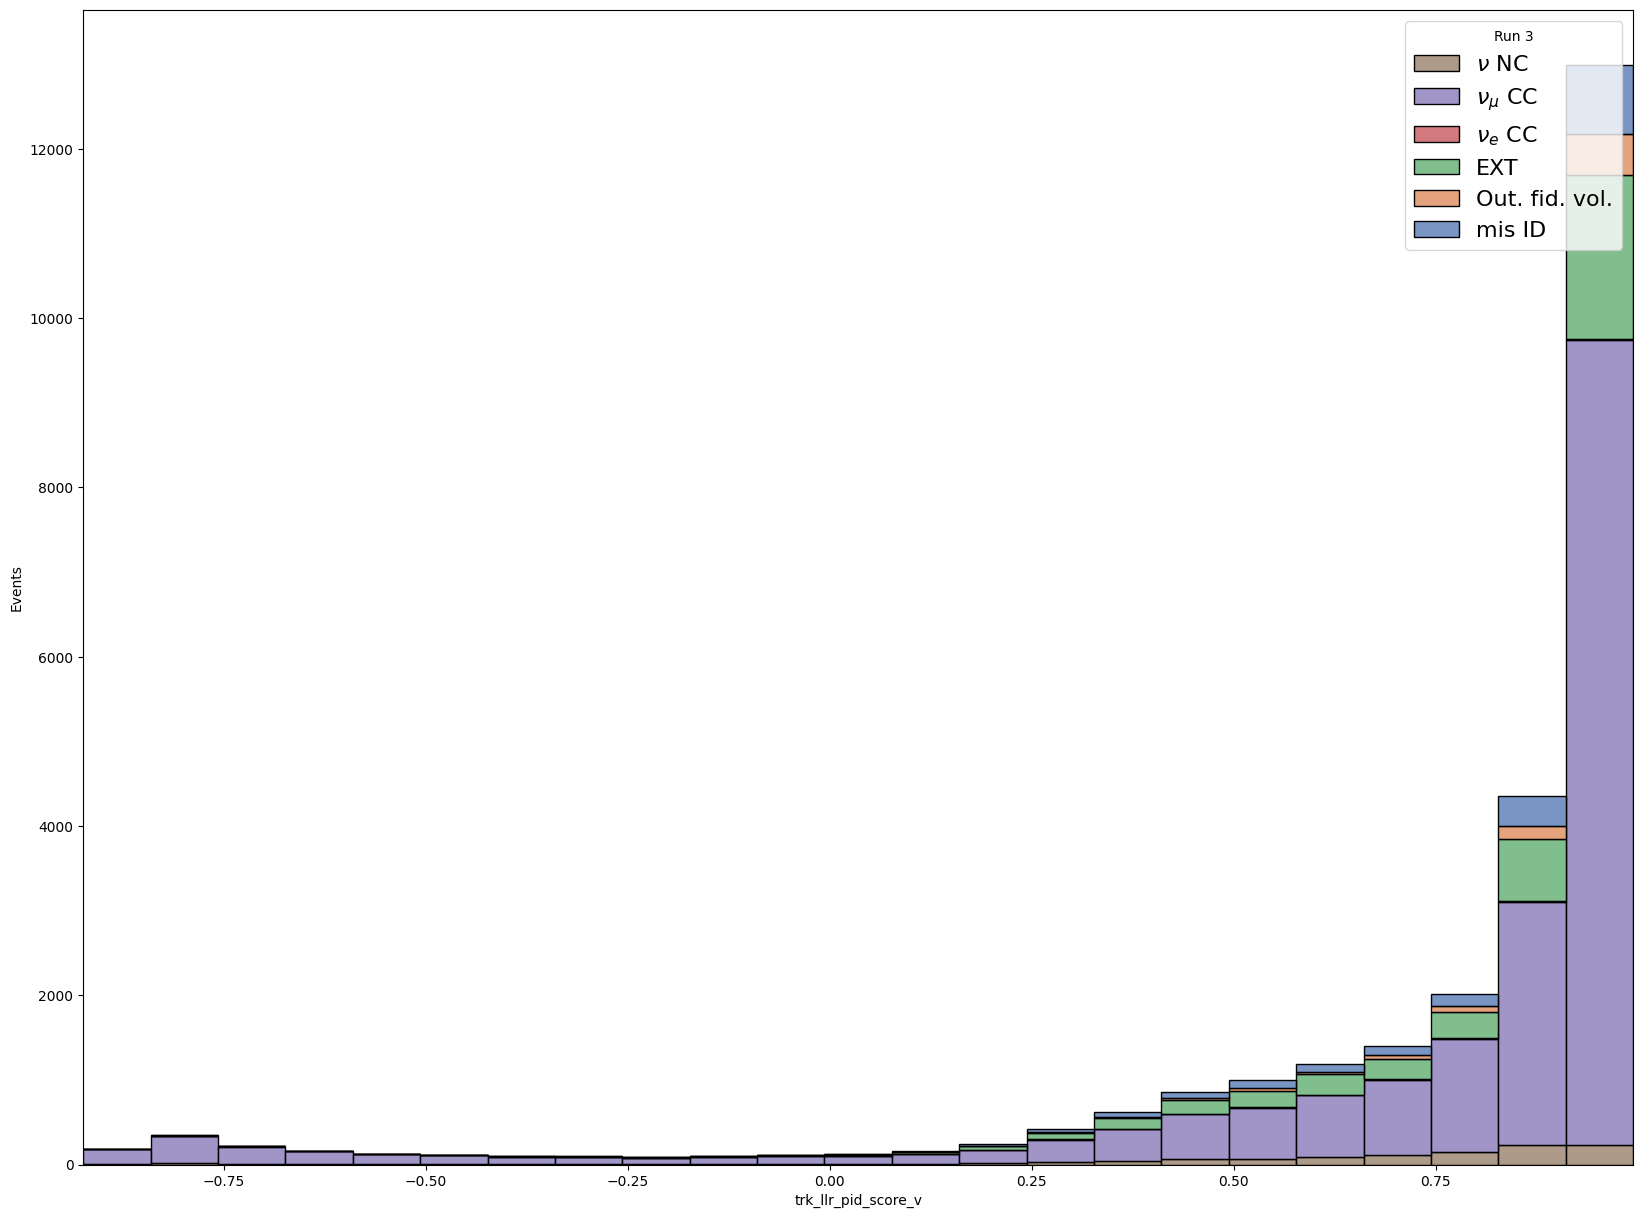

In [23]:
# Simple histogram plot of one variable.
#BIN = 23
#plt.figure(figsize=(20,15))
#i = sns.histplot(data=MC_EXT, x='trk_energy_tot', multiple="stack", hue="category", palette = 'deep', weights = MC_EXT['weight'], bins = BIN, legend = False)
#i.set(xlabel='trk_energy_tot', ylabel = "Events")

#plt.yscale('log')
#plt.xlim([np.min(MC_EXT['trk_energy_tot']), np.max(MC_EXT['trk_energy_tot'])])
#plt.legend(title='Run 3',fontsize=16, loc='upper right', labels=[r"$\nu$ NC", r"$\nu_{\mu}$ CC", r"$\nu_e$ CC", r"EXT", r"Out. fid. vol.", r"mis ID"])
#plt.show(i)

for variable in all_variables_to_plot:
    BIN = 23
    plt.figure(figsize=(20,15))
    i = sns.histplot(data=MC_EXT_cuts, x=variable, multiple="stack", hue="category", palette = 'deep', weights = MC_EXT_cuts['weight'], bins = BIN, legend = False)
    i.set(xlabel=variable, ylabel = "Events")

    #plt.yscale('log')
    plt.xlim([np.min(MC_EXT_cuts[variable]), np.max(MC_EXT_cuts[variable])])
    #plt.xticks(np.arange(np.min(MC_EXT[variable]), np.max(MC_EXT[variable]), 0.1))
    plt.legend(title='Run 3',fontsize=16, loc='upper right', labels=[r"$\nu$ NC", r"$\nu_{\mu}$ CC", r"$\nu_e$ CC", r"EXT", r"Out. fid. vol.", r"mis ID"])
    plt.show(i)

# Exercise 8: Check the purity and efficiency of the sample
It is recommended to plot purity and efficiency after each variable cut.

**HINT:** Function Selection() has commented lines of code that you may find useful for purpose of plotting changes in purity/efficiency after every cut.

[1.         0.99958394]
[0.72869615 0.72886765]


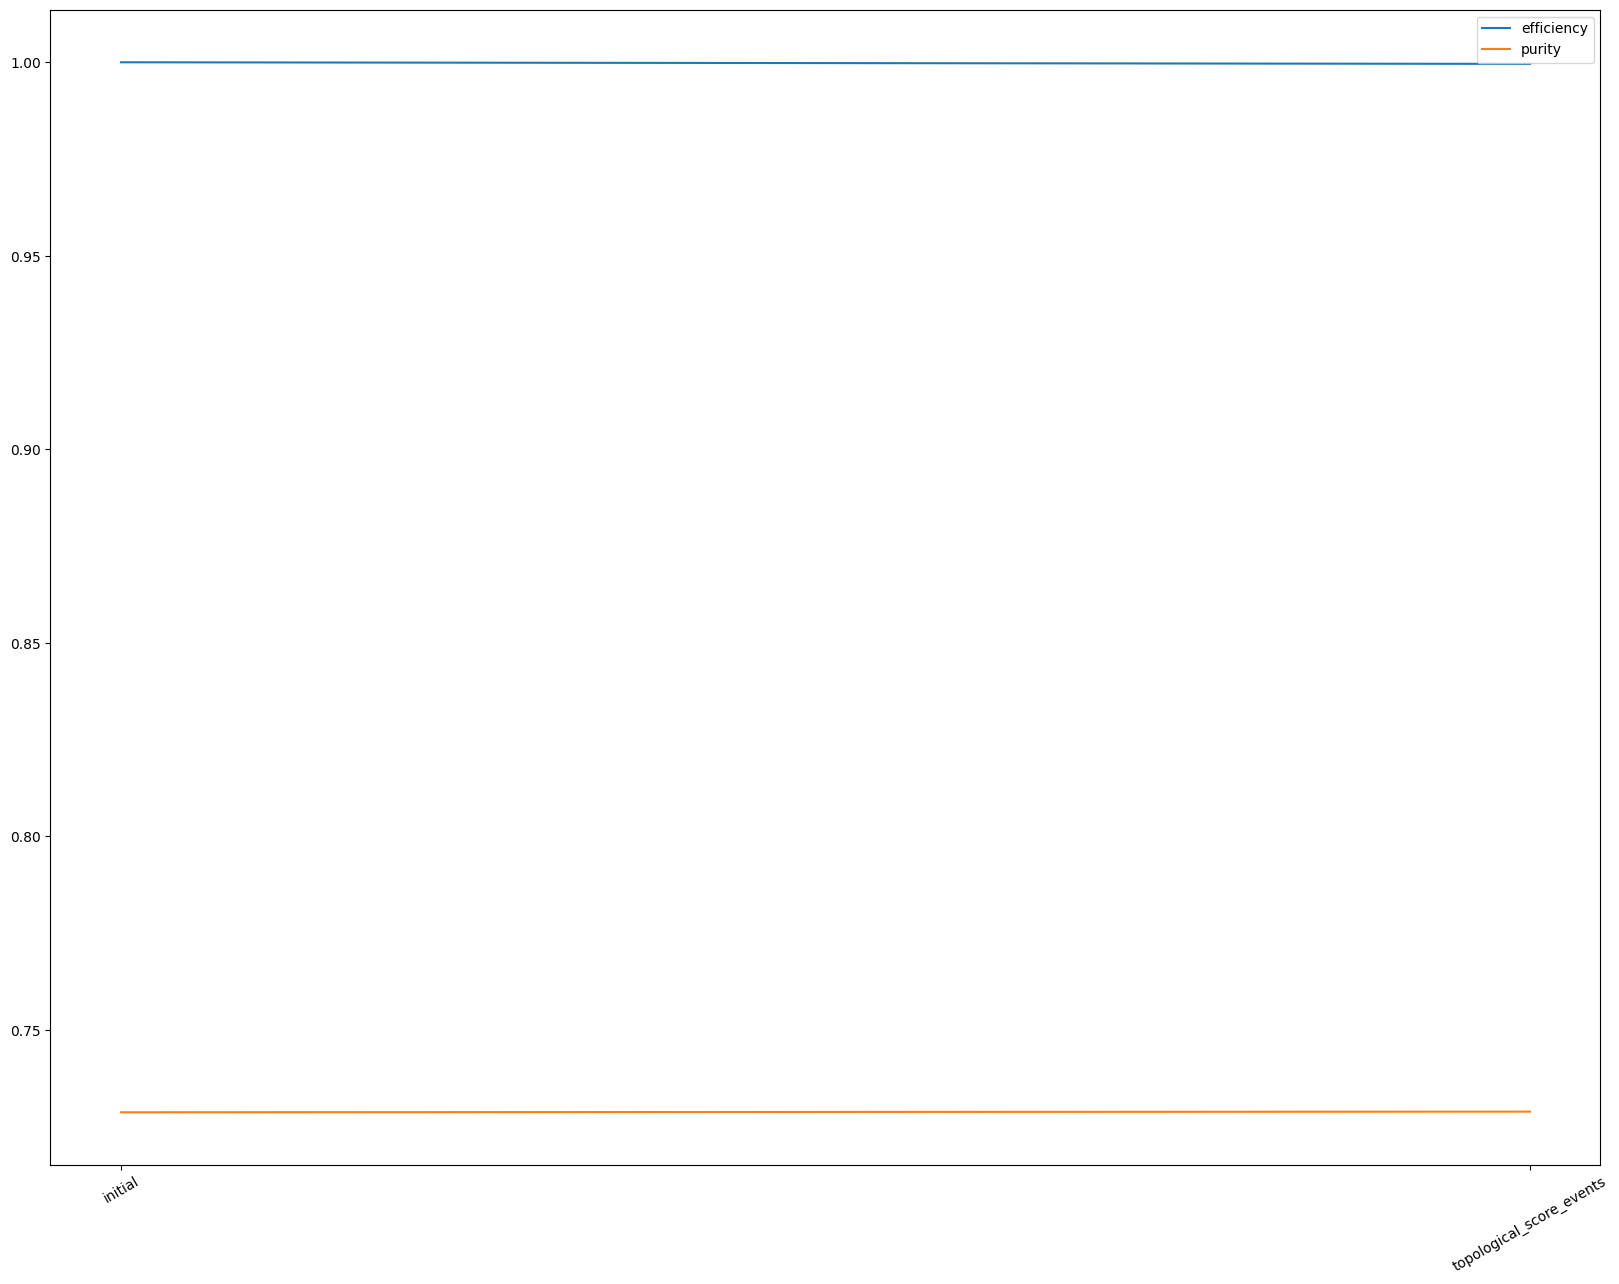

In [24]:
events = np.array(selections[1])
muon_events = np.array(selections[2])
#print(events)
efficiency = events/events[0]
purity = muon_events/events
print(efficiency)
print(purity)

cuts = np.array(['initial','topological_score_events'])
           #      'trk_sce_start_x_v_events', 'trk_sce_start_y_v_events', 'trk_sce_start_z_v_events', 'trk_sce_end_x_v_events', 
            #  'trk_sce_end_y_v_events', 'trk_sce_end_z_v_events', 'trk_distance_v_events', 'reco_nu_vtx_sce_x_events', 'reco_nu_vtx_sce_y_events',
             # 'reco_nu_vtx_sce_z_events', 'trk_len_v_events', 'trk_score_v_events', 'trk_llr_pid_score_v_events'])

plt.figure(figsize=(20,15))
plt.plot(np.linspace(1,2,2),efficiency,label="efficiency")
plt.plot(np.linspace(1,2,2),purity,label="purity")
plt.xticks(np.linspace(1,2,2), labels = cuts, rotation = 30)
plt.legend()
plt.show()

In [25]:
def Individual_Selections(frame):
    
    # Basic variables present in dataframe 
    trk_sce_start_x_v = frame['trk_sce_start_x_v']        # cm
    trk_sce_start_y_v = frame['trk_sce_start_y_v']        # cm
    trk_sce_start_z_v = frame['trk_sce_start_z_v']        # cm
    trk_sce_end_x_v = frame['trk_sce_end_x_v']            # cm
    trk_sce_end_y_v = frame['trk_sce_end_y_v']            # cm
    trk_sce_end_z_v = frame['trk_sce_end_z_v']            # cm
    reco_nu_vtx_sce_x = frame['reco_nu_vtx_sce_x']               # cm
    reco_nu_vtx_sce_y = frame['reco_nu_vtx_sce_y']               # cm
    reco_nu_vtx_sce_z = frame['reco_nu_vtx_sce_z']               # cm
    topological_score = frame['topological_score']          # N/A
    trk_score_v = frame['trk_score_v']                # N/A
    trk_distance_v = frame['trk_distance_v']               # cm
    trk_len_v = frame['trk_len_v']                    # cm
    trk_energy_tot = frame['trk_energy_tot']          # GeV 
    trk_llr_pid_score_v = frame['trk_llr_pid_score_v']
    
    
    
    # select the conditions you want to apply, here is an initial condition to get you started.
    trk_sce_start_x_v_selection = ((trk_sce_start_x_v > 5) & (trk_sce_start_x_v < 250))
    trk_sce_start_y_v_selection = ((trk_sce_start_y_v > -110) & (trk_sce_start_y_v < 110))
    trk_sce_start_z_v_selection = ((trk_sce_start_z_v > 30) & (trk_sce_start_z_v < 990))
    trk_sce_end_x_v_selection = ((trk_sce_end_x_v > 0) & (trk_sce_end_x_v < 250))
    trk_sce_end_y_v_selection = ((trk_sce_end_y_v > -120) & (trk_sce_end_y_v < 110))
    trk_sce_end_z_v_selection = ((trk_sce_end_z_v > 10) & (trk_sce_end_z_v < 1030))
    trk_distance_v_selection = (trk_distance_v < 10)
    reco_nu_vtx_sce_x_selection = ((reco_nu_vtx_sce_x > 5) & (reco_nu_vtx_sce_x < 250))
    reco_nu_vtx_sce_y_selection = ((reco_nu_vtx_sce_y > -110) & (reco_nu_vtx_sce_y < 105))
    reco_nu_vtx_sce_z_selection = ((reco_nu_vtx_sce_z > 30) & (reco_nu_vtx_sce_z < 980))
    trk_len_v_selection =  ((trk_len_v > 0) & (trk_len_v < 1037))
    trk_score_v_selection = (trk_score_v > 0.9)
    topological_score_selection = (topological_score > 0.9)
    trk_llr_pid_score_v_selection = (trk_llr_pid_score_v > 0.9)
    trk_energy_tot_selection = (trk_energy_tot < 2)
    
    
    # Apply selection on dataframe
    total_events = len(frame.index)
    muon_total_events = len(frame[frame['category']==21].index)
    
    frame1 = frame[trk_sce_start_x_v_selection]
    trk_sce_start_x_v_events = len(frame1.index)
    muon_trk_sce_start_x_v_events = len(frame1[frame1['category']==21].index)
    
    frame2 = frame[trk_sce_start_y_v_selection]
    trk_sce_start_y_v_events = len(frame2.index)
    muon_trk_sce_start_y_v_events = len(frame2[frame2['category']==21].index)
    
    frame3 = frame[trk_sce_start_z_v_selection]
    trk_sce_start_z_v_events = len(frame3.index)
    muon_trk_sce_start_z_v_events = len(frame3[frame3['category']==21].index)
    
    frame4 = frame[trk_sce_end_x_v_selection]
    trk_sce_end_x_v_events = len(frame4.index)
    muon_trk_sce_end_x_v_events = len(frame4[frame4['category']==21].index)
    
    frame5 = frame[trk_sce_end_y_v_selection]
    trk_sce_end_y_v_events = len(frame5.index)
    muon_trk_sce_end_y_v_events = len(frame5[frame5['category']==21].index)
    
    frame6 = frame[trk_sce_end_z_v_selection]
    trk_sce_end_z_v_events = len(frame6.index)
    muon_trk_sce_end_z_v_events = len(frame6[frame6['category']==21].index)
    
    frame7 = frame[trk_distance_v_selection]
    trk_distance_v_events = len(frame7.index)
    muon_trk_distance_v_events = len(frame7[frame7['category']==21].index)
    
    frame8 = frame[reco_nu_vtx_sce_x_selection]
    reco_nu_vtx_sce_x_events = len(frame8.index)
    muon_reco_nu_vtx_sce_x_events = len(frame8[frame8['category']==21].index)
    
    frame9 = frame[reco_nu_vtx_sce_y_selection]
    reco_nu_vtx_sce_y_events = len(frame9.index)
    muon_reco_nu_vtx_sce_y_events = len(frame9[frame9['category']==21].index)
    
    frame10 = frame[reco_nu_vtx_sce_z_selection]
    reco_nu_vtx_sce_z_events = len(frame10.index)
    muon_reco_nu_vtx_sce_z_events = len(frame10[frame10['category']==21].index)
    
    frame11 = frame[trk_len_v_selection]
    trk_len_v_events = len(frame11.index)
    muon_trk_len_v_events = len(frame11[frame11['category']==21].index)
    
    frame12 = frame[trk_score_v_selection]
    trk_score_v_events = len(frame12.index)
    muon_trk_score_v_events = len(frame12[frame12['category']==21].index)
    
    frame13 = frame[topological_score_selection]
    topological_score_events = len(frame13.index)
    muon_topological_score_events = len(frame13[frame13['category']==21].index)
    
    frame14 = frame[trk_llr_pid_score_v_selection]
    trk_llr_pid_score_v_events = len(frame14.index)
    muon_trk_llr_pid_score_v_events = len(frame14[frame14['category']==21].index)
    
    frame15 = frame[trk_energy_tot_selection]
    trk_energy_tot_events = len(frame15.index)
    muon_trk_energy_tot_events = len(frame15[frame15['category']==21].index)

    events = [trk_sce_start_x_v_events, trk_sce_start_y_v_events, trk_sce_start_z_v_events, trk_sce_end_x_v_events, 
              trk_sce_end_y_v_events, trk_sce_end_z_v_events, trk_distance_v_events, reco_nu_vtx_sce_x_events, reco_nu_vtx_sce_y_events,
              reco_nu_vtx_sce_z_events, trk_len_v_events, trk_score_v_events, topological_score_events, trk_llr_pid_score_v_events,
              trk_energy_tot_events]
    muon_events = [muon_trk_sce_start_x_v_events, muon_trk_sce_start_y_v_events, muon_trk_sce_start_z_v_events, muon_trk_sce_end_x_v_events, 
              muon_trk_sce_end_y_v_events, muon_trk_sce_end_z_v_events, muon_trk_distance_v_events, muon_reco_nu_vtx_sce_x_events, muon_reco_nu_vtx_sce_y_events,
              muon_reco_nu_vtx_sce_z_events, muon_trk_len_v_events, muon_trk_score_v_events, muon_topological_score_events, muon_trk_llr_pid_score_v_events,
              muon_trk_energy_tot_events]
    
    return events, muon_events

individual_selections = Individual_Selections(MC_EXT)

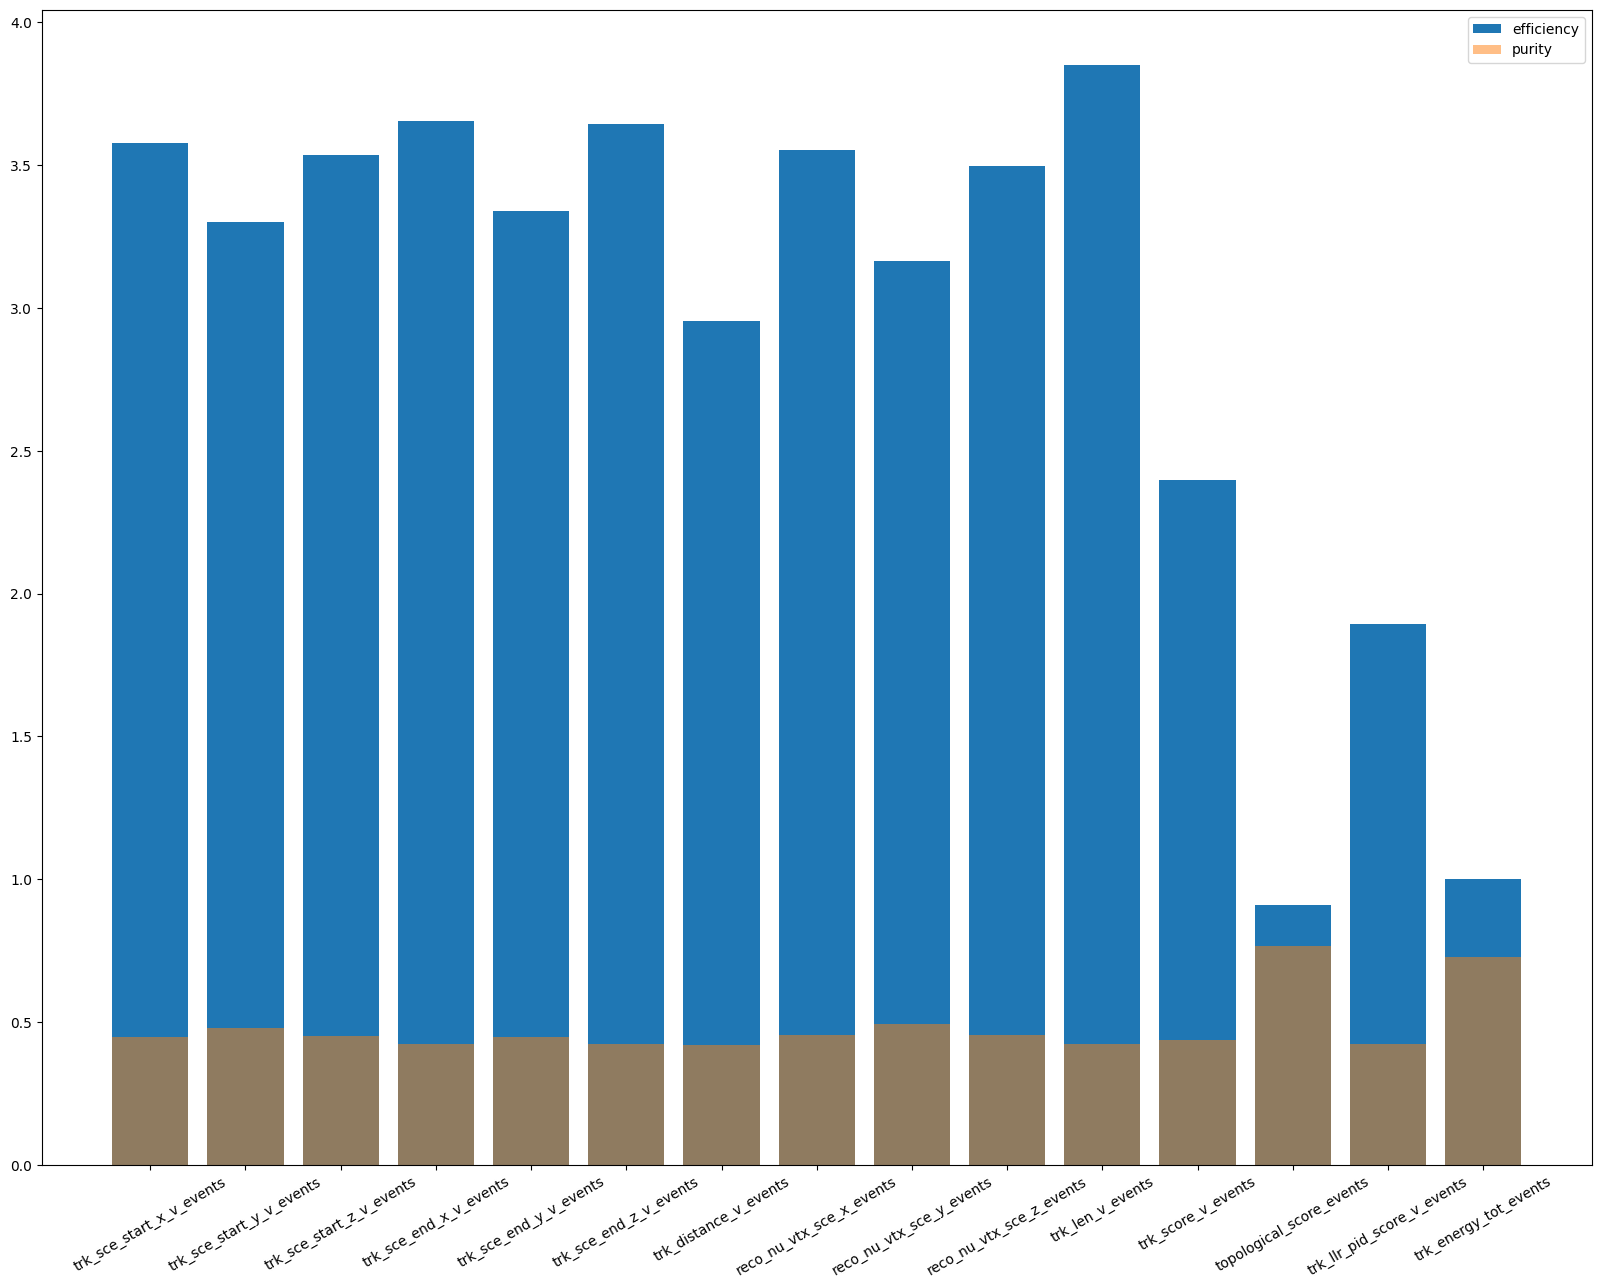

In [26]:
individual_events = np.array(individual_selections[0])
individual_muon_events = np.array(individual_selections[1])
#print(individual_events, individual_muon_events)
individual_efficiency = individual_events/events[0]
individual_purity = individual_muon_events/individual_events

individual_cuts = np.array(['trk_sce_start_x_v_events', 'trk_sce_start_y_v_events', 'trk_sce_start_z_v_events', 'trk_sce_end_x_v_events', 
              'trk_sce_end_y_v_events', 'trk_sce_end_z_v_events', 'trk_distance_v_events', 'reco_nu_vtx_sce_x_events', 'reco_nu_vtx_sce_y_events',
              'reco_nu_vtx_sce_z_events', 'trk_len_v_events', 'trk_score_v_events', 'topological_score_events', 'trk_llr_pid_score_v_events',
              'trk_energy_tot_events'])

plt.figure(figsize=(20,15))
plt.bar(np.linspace(1,15,15),individual_efficiency,label="efficiency")
plt.bar(np.linspace(1,15,15),individual_purity,label="purity",alpha=0.5)
plt.xticks(np.linspace(1,15,15), labels = individual_cuts, rotation = 30)
plt.legend()
plt.show()

# Exercise 9: Plot the energy spectrums here and normalise

Final representation of MC and data after applying the cuts.

In [27]:
def histogram_plot(MC_frame, variable, bins, name, scaling, xlims=[], plot_fig = True, plot_data = False, logscale = None, dataFrame = None, Stat_func = None):
    """
    MC_frame: pandas dataframe - MC dataframe
    variable: string - name of the variable
    bins: int - number of bins
    name: string - name of the plot. The plot is saved
    scaling: array/list - weights you want to apply on MC data
    plot_data: boolean - if True then plots data as well
    logscale: boolean - if True then y axis is log scale
    dataFrame: pandas dataframe - data dataframe
    """    
    #x = 0.5*(bins[1:]+ bins[:-1])
    if (isinstance(MC_frame,pd.core.frame.DataFrame) != True):
        
        print("\"MC_frame\" argument needs to be a pandas dataframe. Cannot plot.")
        
    
    else:
    
        
        fig_MC_temp = plt.figure(figsize=(15,10))

        temp_MC = sns.histplot(data=MC_frame, x= variable , weights = scaling, bins=bins, binrange=xlims, legend = False)
        bars = temp_MC.patches
        MC_heights = [patch.get_height() for patch in bars]
        x = [patch.get_x() for patch in bars]
        w = [patch.get_width() for patch in bars]
        new_bins = [start+w[0]/2 for start in x]
        plt.close(fig_MC_temp)
        
        if(Stat_func is None):
            UNC_frac = 0.15
            UNC = UNC_frac*np.array(MC_heights)  
            
        if(Stat_func is not None):
            UNC_stat = Stat_func(MC_heights)
            UNC_frac = np.sqrt((0.15**2)+(UNC_stat**2))
            UNC = UNC_frac*np.array(MC_heights)

        fig = plt.figure(figsize=(15,10))
        
        labels=[r"$\nu$ NC", r"$\nu_{\mu}$ CC", r"$\nu_e$ CC", r"EXT", r"Out. fid. vol.", r"mis ID", r"Uncertainty"]
        sns.histplot(data=MC_frame, x= variable , hue="category", multiple="stack", palette = 'deep', weights = scaling, bins=bins, binrange=xlims, legend = False)
        plt.bar(new_bins, 2*UNC, width = w, bottom = np.array(MC_heights)-UNC, color='grey', alpha=0.7, hatch='/')

        plt.legend(title='Run 3', loc='upper right', labels=[r"$\nu$ NC", r"$\nu_{\mu}$ CC", r"$\nu_e$ CC", r"EXT", r"Out. fid. vol.", r"mis ID",  r"Uncertainty"])
    
        if (isinstance(dataFrame,pd.core.frame.DataFrame) and plot_data == True):
            fig_data = plt.figure(figsize=(15,10))
            Data_fig = sns.histplot(data=dataFrame, x=variable, bins=bins, binrange=xlims, legend = False)
            bars = Data_fig.patches
        
            heights = [patch.get_height() for patch in bars]
            x = [patch.get_x() for patch in bars]
            w = [patch.get_width() for patch in bars]
            plt.close(fig_data)
            
            ## If these variables are deleted than data has 1 less bin than MC
            #del x[-1]
            #del heights[-1]
            
            new_bins = [start+w[0]/2 for start in x]
            #y_real = np.array(y_real)
            plt.errorbar(new_bins, heights , xerr=w[0]/2, fmt='.k')
            plt.legend(title='Run 3', loc='upper right', labels=[r"$\nu$ NC", r"$\nu_{\mu}$ CC", r"$\nu_e$ CC", r"EXT", r"Out. fid. vol.", r"mis ID",  r"Uncertainty", r"Data"])

    
        elif(isinstance(dataFrame,pd.core.frame.DataFrame) != True and plot_data == True):
            print("\"dataFrame\" argument needs to be a pandas dataframe." + "\n" + "Just plotting Monte Carlo.")
    
        if variable == 'trk_energy_tot':
            variable = r"Reconstructed $\nu_{\mu}$ energy (Gev)"
    
        if (logscale == True):
            plt.yscale('log')
            
        plt.xlabel(variable,fontsize = 20)
        plt.ylabel("Events",fontsize = 20)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        if (plot_fig == True):
            
            plt.savefig(name+'.jpg', dpi=300) 
            plt.show()
        else:
            plt.close()
        # return the heights of each bin for data and MC
        data_heights = heights

        return np.array(MC_heights), np.array(data_heights), np.array(UNC)

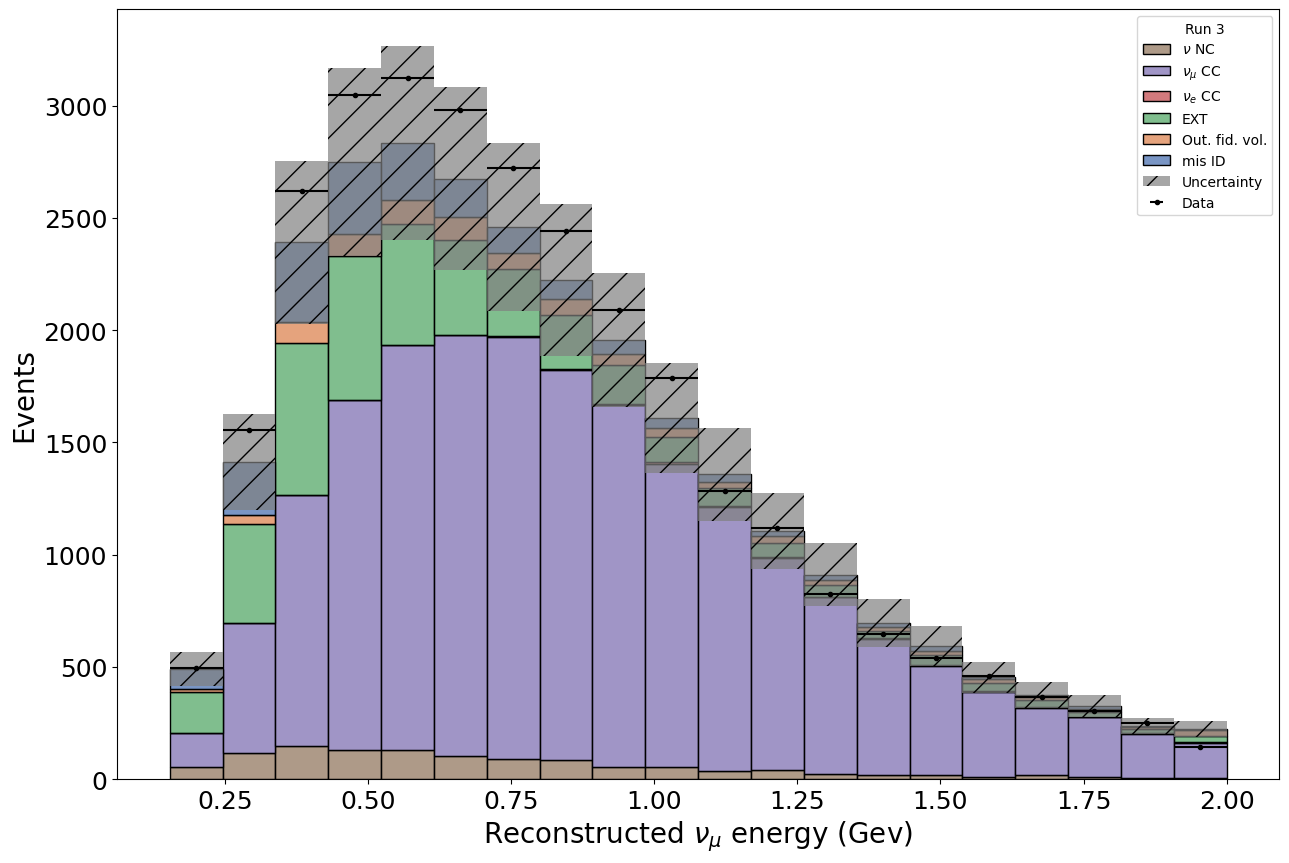

In [28]:
def poisson_error(x):
    return np.sqrt(np.mean(x))/np.mean(x)

energy_hist = Neutrino_functions.histogram_plot(MC_EXT_cuts, 'trk_energy_tot', 20, 'saved_figure_name', MC_EXT_cuts['weight'],xlims=[np.min(MC_EXT_cuts['trk_energy_tot']), np.max(MC_EXT_cuts['trk_energy_tot'])], plot_data = True, logscale = False, dataFrame = data_frame, Stat_func=poisson_error)

# Exercise 10: Oscillation and fitting

### a) Define functions requires for Oscillation analysis, test that they work!


In [29]:
# 2-flavor oscillation probability function
def oscillation_probability(theta, delta, L, E):
    return theta * (np.sin((1.27*delta*L)/E))**2

print(oscillation_probability(0,0,MC_EXT_cuts['true_L'],MC_EXT_cuts['true_E']))

0         0.0
1         0.0
13        0.0
14        0.0
18        0.0
         ... 
555596    0.0
555605    0.0
555606    0.0
555607    0.0
555615    0.0
Length: 144151, dtype: float64


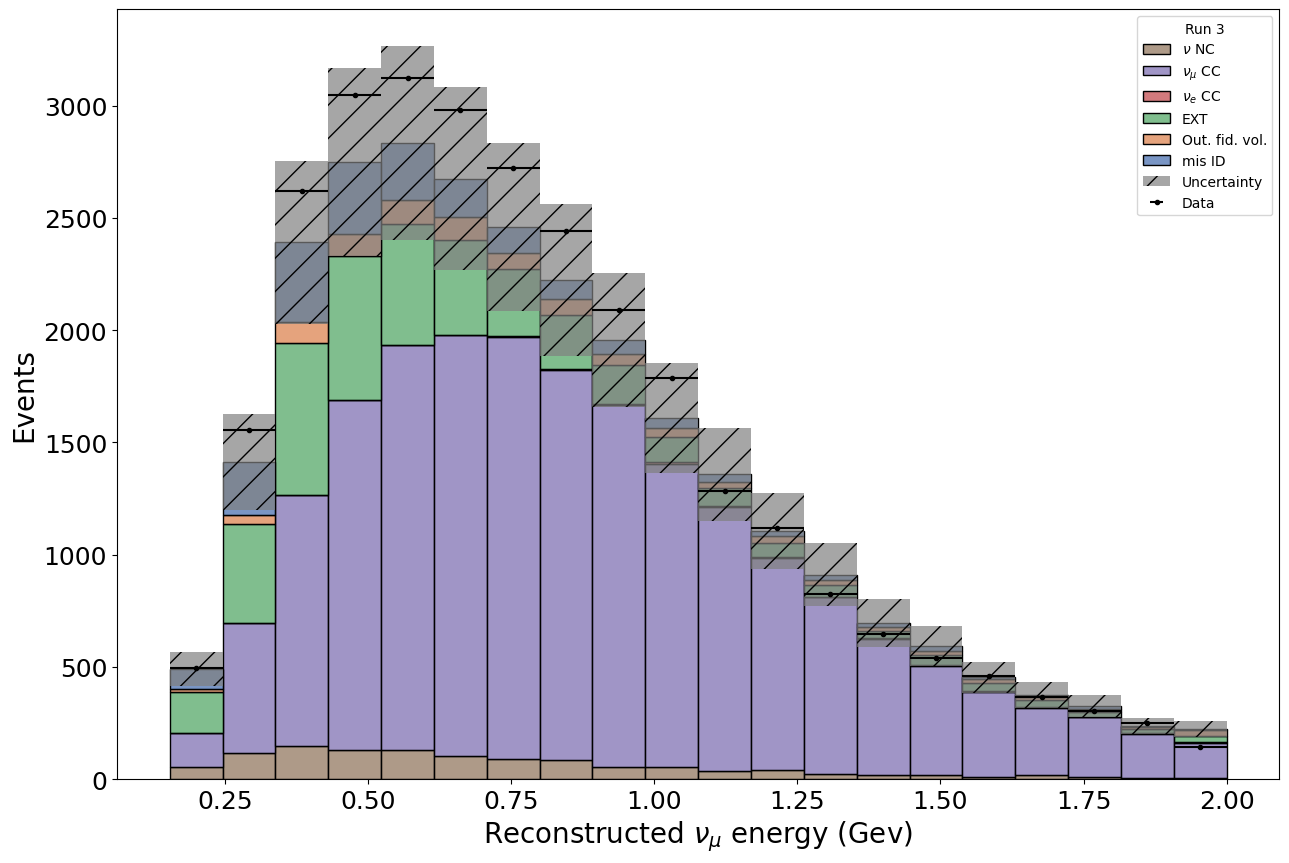

In [30]:
# muon disappearance application to reconstructed neutrino energy
disappearance = 1 - oscillation_probability(0,0,MC_EXT_cuts['true_L'],MC_EXT_cuts['true_E'])
print()


disappearance_energy_hist = histogram_plot(MC_EXT_cuts, 'trk_energy_tot', 20, 'saved_figure_name', disappearance*MC_EXT_cuts['weight'],xlims=[np.min(MC_EXT_cuts['trk_energy_tot']), np.max(MC_EXT_cuts['trk_energy_tot'])], plot_data = True, logscale = False, dataFrame = data_frame, Stat_func=poisson_error)

In [31]:
# chi squared function. mu is the observed datapoint. M is the predicted datapoint. sigma is the uncertainty of each datapoint associated 
def chi_squared(mu,M,sigma):
    return np.sum((mu-M)**2 / sigma**2)

print(chi_squared(disappearance_energy_hist[0],disappearance_energy_hist[1],disappearance_energy_hist[2]))

11.025506273638829


# Exercise 11/12: Oscillation parameter scan, contour plotting, closure test.

### Closure test, create your oscillation parameter scanning code, and find minimum values for chi squared!

C:\Users\louis\AppData\Local\Temp\ipykernel_21756\99312000.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  frame = frame[topological_score_selection]


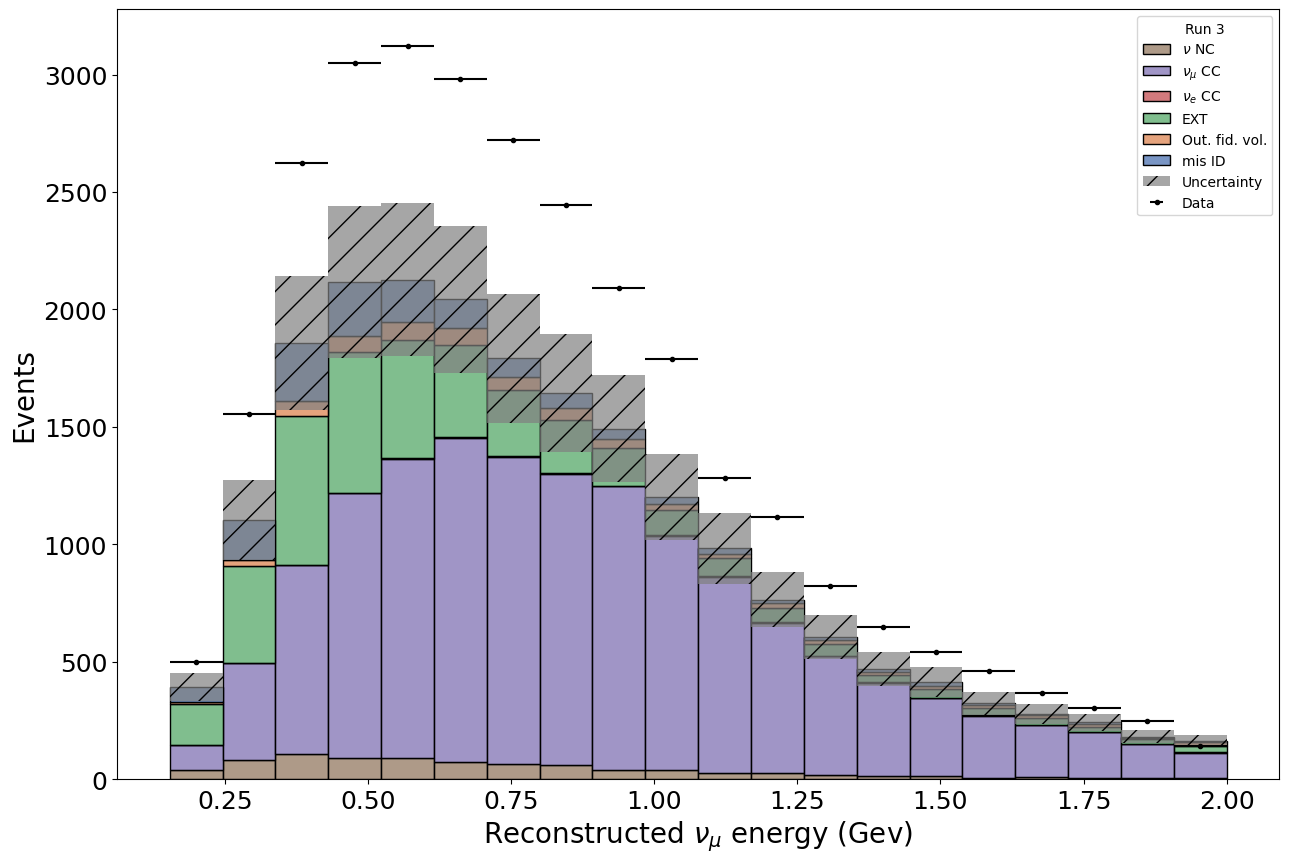

In [32]:
# Selection cuts on oscillated data. The dataset does not have oscillated data
oscillated_data_file = './true_data/oscillated_data.pkl'
oscillated_data = pd.read_pickle(oscillated_data_file)

oscillated_cuts = Selections(oscillated_data)[0]

oscillated_hist = histogram_plot(oscillated_cuts, 'trk_energy_tot', 20, 'saved_figure_name', oscillated_cuts['weight'],xlims=[np.min(oscillated_cuts['trk_energy_tot']), np.max(oscillated_cuts['trk_energy_tot'])], plot_data = True, logscale = False, dataFrame = data_frame, Stat_func=poisson_error)

In [33]:
# Function that oscillates and calculates chi squared for set delM21 and sin^2(2theta)
def oscillate_and_chi(delta,theta,L,E,oscillated_data):
    disappearance = 1 - oscillation_probability(theta,delta,L,E)
    #print(oscillation_probability(delta,theta,L,E))
    disappearance_hist = np.histogram(MC_EXT_cuts['trk_energy_tot'], bins=30, density=False, weights=disappearance*MC_EXT_cuts['weight'])
    
    oscillation_hist = np.histogram(oscillated_data['trk_energy_tot'], bins=30, density=False, weights=oscillated_data['weight'])

    # UNC is the uncertainty of the histogram bins. 15% Uncertinanty
    UNC = 0.15*np.array(disappearance_hist[0])
    #np.sqrt((0.15**2)+(poisson_error(disappearance_hist[0])**2))*np.array(disappearance_hist[0])
    #print(disappearance_hist[0])
    #print(oscillation_hist[0])

    return chi_squared(disappearance_hist[0],oscillation_hist[0],UNC)

print(oscillate_and_chi(11.111, 0.6, MC_EXT_cuts['true_L'], MC_EXT_cuts['true_E'], oscillated_cuts))

#print(chi_squared(disappearance_energy_hist[0],oscillated_hist[0],disappearance_energy_hist[2]))

1.8119989670099608


In [34]:
# Function that loops the above function across range of values of delM21 and sin^2(2theta)
def mesh(deltamin, deltamax, thetamin, thetamax, L,E,oscillated_data):
    delta_values = np.linspace(deltamin,deltamax,50)
    theta_values = np.linspace(thetamin,thetamax,50)
    chi_values = np.zeros((50,50))
    for delta in range(50):
        for theta in range(50):
            #print(oscillate_and_chi(delta_values[delta],theta_values[theta],L,E))
            chi_values[theta,delta] = oscillate_and_chi(delta_values[delta],theta_values[theta],L,E,oscillated_data)

    return chi_values

def contour_plot(deltamin, deltamax, thetamin, thetamax, chi_values):
    plt.figure(figsize=(8, 6))
    #ax2.set_title(r'A contour plot of $\chi^2$ values for varying $\lambda_{79Rb}$ and $\lambda_{79Sr}$')
    plt.xlabel('sin^2 2theta')
    plt.ylabel('delta')

    min_chi = np.min(chi_values)
    levels1 = np.linspace(0,5,20) + min_chi
    levels2 = [min_chi+1, min_chi+2.3, min_chi+5.99]
    
    XMESH, YMESH = np.meshgrid(np.linspace(thetamin,thetamax,50), np.linspace(deltamin,deltamax,50), copy=True, sparse=False, indexing='ij')
    contour_plot = plt.contourf(XMESH, YMESH, chi_values, levels1, cmap='jet')
    plt.colorbar()
    confidence_lines = plt.contour(XMESH, YMESH, chi_values, levels2)
    plt.clabel(confidence_lines, confidence_lines.levels[:1], fmt=r'$\chi^2_{min}$ + 1')
    plt.clabel(confidence_lines, confidence_lines.levels[1:2], fmt=r'$\chi^2_{min}$ + 2.3')
    plt.clabel(confidence_lines, confidence_lines.levels[2:3], fmt=r'$\chi^2_{min}$ + 5.99')
    #plt.xscale('log')
    #plt.yscale('log')

    minx, miny = np.where(chi_values == np.min(chi_values))
    print(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny])
    plt.plot(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny], 'ro')

    plt.show()

[0.55714286] [11.1122449]


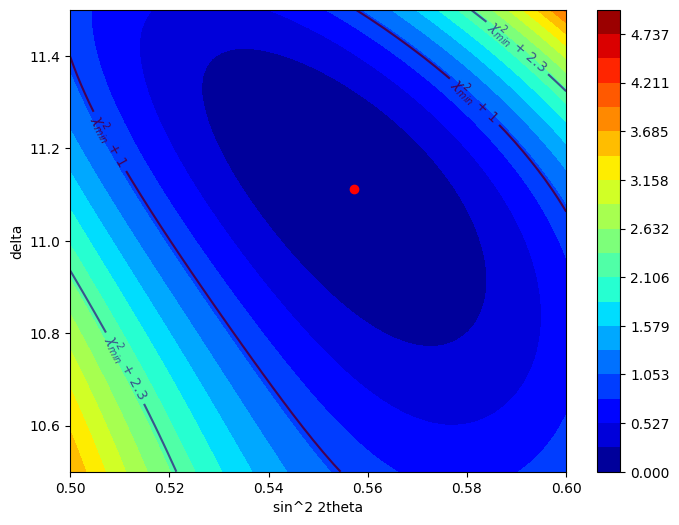

In [35]:
deltamin = 10.5
deltamax = 11.5
thetamin = 0.5
thetamax = 0.6

#del chi_values

#0.47km is length of neutrino travel

chi_values = mesh(deltamin, deltamax, thetamin, thetamax, 0.47, MC_EXT_cuts['true_E'], oscillated_cuts)
#print(chi_values)

#recommended values to use 10, 15, 0.5, 0.6

contour_plot(deltamin, deltamax, thetamin, thetamax, chi_values)

In [36]:
def mesh_data(deltamin, deltamax, thetamin, thetamax, L,E,oscillated_data):
    delta_values = np.linspace(deltamin,deltamax,50)
    theta_values = np.linspace(thetamin,thetamax,50)
    chi_values = np.zeros((50,50))
    for delta in range(50):
        for theta in range(50):
            #print(oscillate_and_chi(delta_values[delta],theta_values[theta],L,E))
            chi_values[theta,delta] = oscillate_and_chi_data(delta_values[delta],theta_values[theta],L,E,oscillated_data)

    return chi_values

def oscillate_and_chi_data(delta,theta,L,E,oscillated_data):
    disappearance = 1 - oscillation_probability(theta,delta,L,E)
    #print(oscillation_probability(delta,theta,L,E))
    disappearance_hist = np.histogram(MC_EXT_cuts['trk_energy_tot'], bins=30, density=False, weights=disappearance*MC_EXT_cuts['weight'])
    
    oscillation_hist = np.histogram(oscillated_data['trk_energy_tot'], bins=30, density=False)

    # UNC is the uncertainty of the histogram bins. 15% Uncertinanty
    UNC = 0.15*np.array(disappearance_hist[0])
    #np.sqrt((0.15**2)+(poisson_error(disappearance_hist[0])**2))*np.array(disappearance_hist[0])
    #print(disappearance_hist[0])
    #print(oscillation_hist[0])

    return chi_squared(disappearance_hist[0],oscillation_hist[0],UNC)

def contour_plot_data(deltamin, deltamax, thetamin, thetamax, chi_values):
    plt.figure(figsize=(8, 6))
    #ax2.set_title(r'A contour plot of $\chi^2$ values for varying $\lambda_{79Rb}$ and $\lambda_{79Sr}$')
    plt.xlabel('sin^2 2theta')
    plt.ylabel('delta')

    min_chi = np.min(chi_values)
    #levels1 = np.linspace(0,5,20) + min_chi
    levels2 = [min_chi+1, min_chi+2.3, min_chi+5.99]
    
    XMESH, YMESH = np.meshgrid(np.linspace(thetamin,thetamax,50), np.linspace(deltamin,deltamax,50), copy=True, sparse=False, indexing='ij')
    contour_plot = plt.contourf(XMESH, YMESH, chi_values, levels=20, cmap='jet')
    plt.colorbar()
    confidence_lines = plt.contour(XMESH, YMESH, chi_values, levels2)
    plt.clabel(confidence_lines, confidence_lines.levels[:1], fmt=r'$\chi^2_{min}$ + 1')
    plt.clabel(confidence_lines, confidence_lines.levels[1:2], fmt=r'$\chi^2_{min}$ + 2.3')
    plt.clabel(confidence_lines, confidence_lines.levels[2:3], fmt=r'$\chi^2_{min}$ + 5.99')
    plt.xscale('log')
    plt.yscale('log')

    minx, miny = np.where(chi_values == np.min(chi_values))
    print(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny])
    plt.plot(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny], 'ro')

    plt.show()

[0.001] [0.01]


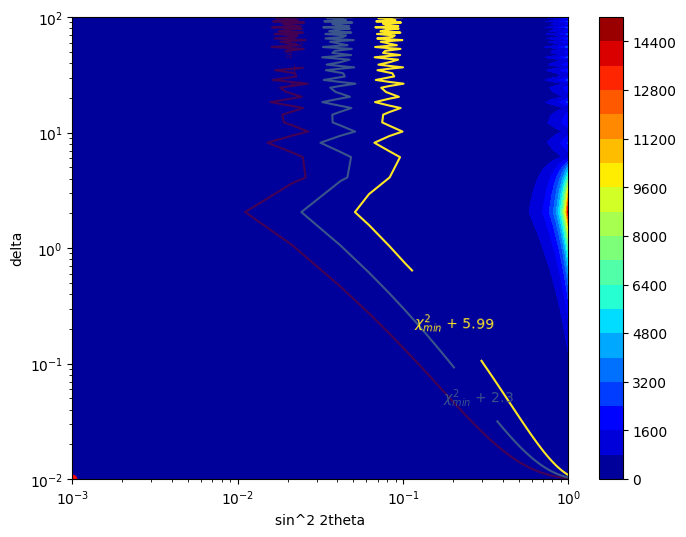

In [37]:
deltamin = 0.01
deltamax = 100
thetamin = 0.001
thetamax = 1

#del chi_values

#0.47km is length of neutrino travel

chi_values_data = mesh_data(deltamin, deltamax, thetamin, thetamax, 0.47, MC_EXT_cuts['true_E'], data_frame)
#print(chi_values)

#recommended values to use 10, 15, 0.5, 0.6

contour_plot_data(deltamin, deltamax, thetamin, thetamax, chi_values_data)

### Bonus: Minimise

Minimise your chi square value, determining the parameters of 'best fit'

### Confidence levels and parameter minima. 
Determine confidence levels, and find the parameter values that correspond to the lowest chi squared value within your range.with

In [38]:
# contour application, with correct confidence levels.

In [39]:
# find lowest chi squared value within range and plot with CL, or contourf plot.

# Exercise 13/14: 3+1 Framework Neutrino disappearance.

In [40]:
# Produce your new oscillation parameter, which should be sin^2(2*theta_ue)

theta_ue = ((5-np.sqrt(19))/5)*(1-np.sqrt(1-np.linspace(thetamin,thetamax,50)))

# Compare your result with MiniBooNE



In [41]:
def contour_plot_mini(deltamin, deltamax, theta_ue, chi_values):
    plt.figure(figsize=(8, 6))
    #ax2.set_title(r'A contour plot of $\chi^2$ values for varying $\lambda_{79Rb}$ and $\lambda_{79Sr}$')
    plt.xlabel('sin^2 2theta_ue')
    plt.ylabel('delta')

    min_chi = np.min(chi_values)
    #levels1 = np.linspace(0,5,20) + min_chi
    levels2 = [min_chi+1, min_chi+2.3, min_chi+5.99]
    
    XMESH, YMESH = np.meshgrid(theta_ue, np.linspace(deltamin,deltamax,50), copy=True, sparse=False, indexing='ij')
    contour_plot = plt.contourf(XMESH, YMESH, chi_values, levels=20, cmap='jet')
    plt.colorbar()
    confidence_lines = plt.contour(XMESH, YMESH, chi_values, levels2)
    plt.clabel(confidence_lines, confidence_lines.levels[:1], fmt=r'$\chi^2_{min}$ + 1')
    plt.clabel(confidence_lines, confidence_lines.levels[1:2], fmt=r'$\chi^2_{min}$ + 2.3')
    plt.clabel(confidence_lines, confidence_lines.levels[2:3], fmt=r'$\chi^2_{min}$ + 5.99')
    plt.xscale('log')
    plt.yscale('log')

    minx, miny = np.where(chi_values == np.min(chi_values))
    print(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny])
    plt.plot(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny], 'ro')

    plt.show()

Results are extracted from MiniBooNE (orange) and LSND (blue)

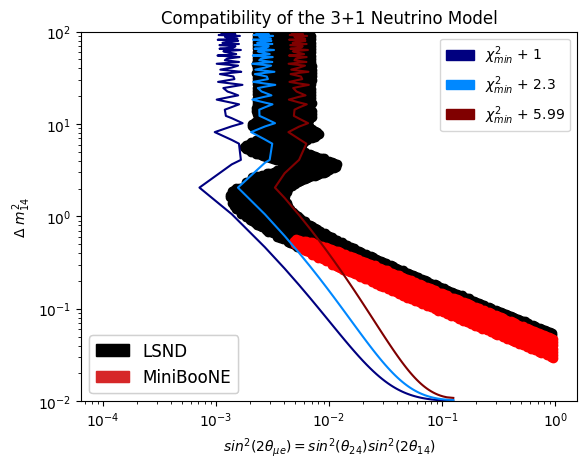

In [42]:
# Load data
LSND_data = pd.read_csv('./true_data/DataSet_LSND.csv').to_numpy()
MiniBooNE_data = pd.read_csv('./true_data/DataSet_MiniBooNE.csv').to_numpy()

# Plot data
plt.plot(LSND_data[:,0],LSND_data[:,1],'ko')
plt.plot(MiniBooNE_data[:,0],MiniBooNE_data[:,1],'ro')

min_chi = np.min(chi_values_data)
#levels1 = np.linspace(0,5,20) + min_chi
levels2 = [min_chi+1, min_chi+2.3, min_chi+5.99]
    
XMESH, YMESH = np.meshgrid(theta_ue, np.linspace(deltamin,deltamax,50), copy=True, sparse=False, indexing='ij')
#contour_plot = plt.contourf(XMESH, YMESH, chi_values, levels=20, cmap='jet')
#plt.colorbar()
confidence_lines = plt.contour(XMESH, YMESH, chi_values_data, levels2, cmap="jet")
#plt.clabel(confidence_lines, confidence_lines.levels[:1], inline=1, fmt=r'$\chi^2_{min}$ + 1')
#plt.clabel(confidence_lines, confidence_lines.levels[1:2], inline=1, fmt=r'$\chi^2_{min}$ + 2.3')
#plt.clabel(confidence_lines, confidence_lines.levels[2:3], inline=1, fmt=r'$\chi^2_{min}$ + 5.99')
#plt.xscale('log')
#plt.yscale('log')

legend_labels = [r'$\chi^2_{min}$ + 1', r'$\chi^2_{min}$ + 2.3', r'$\chi^2_{min}$ + 5.99']
legend_handles = []
for i, level in enumerate(levels2):
    legend_handles.append(mpatches.Patch(color=confidence_lines.collections[i].get_edgecolor(), label=legend_labels[i]))
legend = plt.legend(handles=legend_handles, loc='upper right')

minx, miny = np.where(chi_values_data == np.min(chi_values_data))
#print(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny])
#plt.plot(np.linspace(thetamin,thetamax,50)[minx], np.linspace(deltamin,deltamax,50)[miny], 'ro')

# Producing MiniBooNE/LSND legend
LSND_path = mpatches.Patch(color='black', label = 'LSND')
MINI_path = mpatches.Patch(color='tab:red', label = 'MiniBooNE')
first_legend = plt.legend(handles=[LSND_path, MINI_path], loc = 'lower left', fontsize = 12)
plt.gca().add_artist(first_legend)
plt.gca().add_artist(legend)

plt.title("Compatibility of the 3+1 Neutrino Model")
plt.xlabel(r'$sin^2(2\theta_{\mu e})=sin^2(\theta_{24})sin^2(2\theta_{14})$')
plt.ylabel(r'$\Delta$ $m_{14}^2$')
plt.xticks()
plt.yticks()
plt.yscale('log')
plt.xscale('log')
plt.show()